>  steps:
1. new labeled data with correct user ids: train and test
2. the model with laser emb only is tuned and a new one is build with the best parameters, the later is trained and tested again
3. the 3rd model is the iteration of 2nd that takes nr of epochs to train to be the nr of best epoch +1 of tuned model - maybe i'll implement

4. use of user embeddings + text embeddings: contruct a new model based on new embeddings


at the end the results are comapared

In [1]:
# #execute this cell, then press 'Restart and clear cell outputs' and execute all cells except this
# !pip install -U tensorflow==2.5.0
# !pip install -U numpy==1.18.5
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/d/anastasiacotov/data-with-convid-2023-4-6/data_with_convid_2023_4_6.xlsx
/kaggle/input/u2v-train-test-2023-4-6/test_U_bert_bert-base-multilingual-cased_run2.txt
/kaggle/input/u2v-train-test-2023-4-6/train_U_bert_bert-base-multilingual-cased_run2.txt
/kaggle/input/u2v-train-test-2023-4-6/test_U_bert_bert-base-multilingual-cased_mean.txt
/kaggle/input/u2v-train-test-2023-4-6/train_U_bert_bert-base-multilingual-cased_mean.txt
/kaggle/input/u2v-data-cs-aware/u2v_test.txt
/kaggle/input/u2v-data-cs-aware/u2v_train.txt
/kaggle/input/u2v-data-cs-aware/u2v_test.xlsx
/kaggle/input/u2v-data-cs-aware/u2v_train_lb.xlsb.xlsx
/kaggle/input/u2v-train-label-now-23-4-6-v2/u2v_train_label_now_23_4_6_v2.xlsx
/kaggle/input/output-u2v-train-bert/U_bert_bert-base-multilingual-cased_run2.txt
/kaggle/input/output-u2v-train-bert/U_bert_bert-base-multilingual-cased_mean.txt
/kaggle/input/output-u2v-test-bert/U_bert_bert-base-multilingual-cased_run2.txt
/kaggle/input/output-u2v-test-bert/U_bert_ber

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install sweetviz
!pip install contractions
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import contractions
import sweetviz as sv
import nltk
nltk.download('omw-1.4')
#importing the Lemming function from nltk library
from nltk.stem import WordNetLemmatizer
import re  
import collections
# Counting the number of words
from collections import Counter
import time

import tabulate
from tabulate import tabulate
import sweetviz as sv

#importing the Lemming function from nltk library
from nltk.stem import WordNetLemmatizer
import re  
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from keras.layers import Embedding, Input, Dense
from keras.models import Model

import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
from sklearn import preprocessing

import nltk # NLP  
from nltk.corpus import stopwords  
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer 
import re  

# visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

from tensorflow.keras import regularizers

#Tuner
from keras_tuner.tuners import RandomSearch

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers
# cross validation and metrics
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer
from unidecode import unidecode
from keras_tuner.tuners import RandomSearch

#metrics:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 13.5 MB/s eta 0:00:00


[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


> Import Datasets here

In [3]:
data_with_convid_2023_4_6 = pd.read_excel('/kaggle/input/u2v-train-label-now-23-4-6-v2/u2v_train_label_now_23_4_6_v2.xlsx')

print('train/test shape: ')
print(data_with_convid_2023_4_6.shape)

u2v_test = pd.read_excel('/kaggle/input/u2v-data-cs-aware/u2v_test.xlsx')
print(u2v_test.shape)

# count the number of tweets for each author
counts = u2v_test['author_id'].value_counts()
#it tells us there are 28/36 that have tweets in test set, bc of initial condition: only users that posted > 25tweets have 20 tweets in test set
print('counts: ', counts.shape)
print(counts)


#u2v_test['author_id'] they are already sorted
u2v_test = u2v_test.sort_values(by=['author_id'])
# u2v_test
# u2v_train_lb = pd.read_excel('/kaggle/input/u2v-data-cs-aware/u2v_train_lb.xlsb.xlsx')
# print(u2v_train_lb.shape)
# u2v_train_lb.columns
print('check type of ids')
print(data_with_convid_2023_4_6['tweet_id'])

# u2v_train_lb = pd.concat([u2v_train_lb, data_with_convid_2023_4_6])
u2v_train_lb = data_with_convid_2023_4_6
print(u2v_train_lb.columns)

# count null values in column 'label' = 0 means all raws labeled
null_count = u2v_train_lb['label'].isnull().sum()
print(null_count)

u2v_train_lb.drop_duplicates(subset='full_text', inplace=True)
u2v_train_lb.reset_index(drop=True, inplace=True)
print(u2v_train_lb.shape)
# u2v_train_lb.drop(columns=['Unnamed: 0','Unnamed: 0.1', 'Unnamed: 0.1.1', 'index', 'full_text1'], inplace=True)
# u2v_train_lb.shape
# count the number of tweets for each author
counts = u2v_train_lb['author_id'].value_counts()
print(counts.shape)
print(counts)
# author_ids = u2v_train_lb.groupby('author_id').filter(lambda x: len(x) < 40)['author_id'].tolist()
# author_ids = list(set(author_ids))
# author_ids
print(u2v_train_lb)


train/test shape: 
(3023, 32)
(560, 34)
counts:  (28,)
11791512               20
34204102               20
1281147967873978368    20
1273938586623188992    20
1238329176853114880    20
1192514152016830464    20
1151096599168372736    20
1118889805885190144    20
1049708851262619648    20
864648405586280448     20
852970607440527360     20
825809883161260032     20
823527947848056835     20
708914840711122945     20
2282264556             20
2187915589             20
1201114460             20
518338623              20
392714686              20
328929990              20
190566425              20
184762389              20
153365707              20
137795216              20
64812324               20
56187579               20
50026664               20
1290574179729891336    20
Name: author_id, dtype: int64
check type of ids
0       1065271090627399681
1        618380112497655809
2        930779402291564544
3        930382863555538945
4        925320401256898560
               ...         
3

due to the fact that too good results where after version 0 of the notebook, i expect that test set data was in train set, let\s check it

In [4]:
# find common values with the 'full_text_clean' column in both
if set(u2v_train_lb['full_text']).intersection(set(u2v_test['full_text'])):
    print("The two dataframes have common values in the 'full_text' column")
    # Filter out rows from train
    common_values = set(u2v_train_lb['full_text']).intersection(set(u2v_test['full_text']))
    u2v_train_lb = u2v_train_lb[~u2v_train_lb['full_text'].isin(common_values)]
    print(u2v_train_lb.shape)
else:
    print("The two dataframes do not have common values in the 'full_text' column")


The two dataframes do not have common values in the 'full_text' column


In [5]:
def data_save(data_to_u2v):
    data_to_u2v['tweet_id'] = data_to_u2v['tweet_id'].astype(str)
    data_to_u2v['conversation_id'] = data_to_u2v['conversation_id'].astype(str)
    data_to_u2v['author_id'] = data_to_u2v['author_id'].astype(str)
data_save(u2v_train_lb)
data_save(u2v_test)

> Look up on Data

new instructions on data 2023 4/ 4:
* remember to sort the txt by user id, or remember me it's unsorted -done
* filter small sentences - done
* check also word length and frequency - done

In [6]:
# u2v_train_lb = u2v_train_lb[u2v_train_lb['full_text'].str.split().str.len() >= 6].reset_index(drop=True)
# u2v_train_lb.shape
# data_save(u2v_train_lb)
# u2v_train_lb.to_excel('/kaggle/working/u2v_train_label_now_23_4_6_v2.xlsx', encoding='utf-f8')

In [7]:
import plotly.graph_objs as go

# Compute value counts for the label column
counts = u2v_train_lb['label'].value_counts()

# Create a pie chart using plotly
fig = go.Figure(data=[go.Pie(labels=counts.index, values=counts.values,
                             hole=0.6,  # set the size of the center hole
                             marker=dict(colors=['#2B4A9D','#008B8B',  '#CD5C5C']),  # set the color of the slices
                             textfont=dict(size=20))])  # set the size of the slice labels

# Customize the layout
fig.update_layout(title='Label Distribution in Training Set', 
                  font=dict(size=16),
                  margin=dict(l=50, r=50, t=50, b=50),
                  plot_bgcolor='white',
                  paper_bgcolor='white',
                  width=600,
                  height=600)

# Show the plot
fig.show()

In [8]:
import plotly.graph_objs as go

# Compute value counts for the label column
counts = u2v_test['label'].value_counts()

# Create a pie chart using plotly
fig = go.Figure(data=[go.Pie(labels=counts.index, values=counts.values,
                             hole=0.6,  # set the size of the center hole
                             marker=dict(colors=['#2B4A9D','#008B8B',  '#CD5C5C']),  # set the color of the slices
                             textfont=dict(size=20))])  # set the size of the slice labels

# Customize the layout
fig.update_layout(title='Label Distribution in Test Set', 
                  font=dict(size=16),
                  margin=dict(l=50, r=50, t=50, b=50),
                  plot_bgcolor='white',
                  paper_bgcolor='white',
                  width=600,
                  height=600)

# Show the plot
fig.show()

In [9]:
import plotly.graph_objs as go

# Count occurrences by author ID
counts = u2v_train_lb['author_id'].value_counts()

# Create a bar chart using plotly
fig = go.Figure(data=[go.Bar(x=counts.index, y=counts.values,
                             marker_color='#008B8B',  # set the color of the bars
                             text=counts.values,     # add labels to the bars
                             textposition='auto')])  # position the labels inside the bars
# Add total number of authors as a text annotation
total_authors = len(counts)
fig.add_annotation(text=f"Total Authors: {total_authors}", 
                   xref="paper", yref="paper",
                   x=0.95, y=0.95,
                   showarrow=False,
                   font=dict(size=16))
# Customize the layout
fig.update_layout(title='Number of tweets per Author ID in Training Data', 
                  xaxis_title='Author ID', 
                  yaxis_title='Number of Tweets',
                  font=dict(size=16),
                  margin=dict(l=50, r=50, t=50, b=50),
                  plot_bgcolor='#F8F8FF',
                  paper_bgcolor='#F8F8FF')
# Show the plot
fig.show()


In [10]:
import plotly.graph_objs as go

# Count occurrences by author ID
counts = u2v_test['author_id'].value_counts()

# Create a bar chart using plotly
fig = go.Figure(data=[go.Bar(x=counts.index, y=counts.values,
                             marker_color='#008B8B',  # set the color of the bars
                             text=counts.values,     # add labels to the bars
                             textposition='auto')])  # position the labels inside the bars

# # Add total number of authors as a text annotation
# total_authors = len(counts)
# fig.add_annotation(text=f"Total Authors: {total_authors}", 
#                    xref="paper", yref="paper",
#                    x=0.95, y=0.95,
#                    showarrow=False,
#                    font=dict(size=16))

# Customize the layout
fig.update_layout(title='Number of Tweets per Author ID in Test Data', 
                  xaxis_title='Author ID', 
                  yaxis_title='Number of Tweets',
                  font=dict(size=16),
                  margin=dict(l=50, r=50, t=50, b=50),
                  plot_bgcolor='#F8F8FF',
                  paper_bgcolor='#F8F8FF')
# Show the plot

fig.show()


In [11]:
import plotly.graph_objs as go

# Compute value counts for the label column
counts = u2v_train_lb['lang'].value_counts()
# Calculate the total count of languages
total_count = counts.sum()

# Filter out languages with percentage less than 2%
filtered_counts = counts[counts/total_count >= 0.034]

# Calculate the count and percentage of the "others" category
others_count = total_count - filtered_counts.sum()
others_percentage = others_count / total_count

# Add "others" to the filtered counts
filtered_counts['others'] = others_count

# Print the number of languages in the "others" category
num_others_languages = len(counts) - len(filtered_counts)
print(f"Number of languages in 'others': {num_others_languages}")


# Create a pie chart using plotly
fig = go.Figure(data=[go.Pie(labels=filtered_counts.index, values=filtered_counts.values,
                             hole=0.6,
                             marker=dict(colors=['#2B4A9D','#008B8B', '#CD5C5C', '#CCCCCC']),
                             textfont=dict(size=20))])

# Customize the layout
fig.update_layout(title='Language Distribution in Training Data',
                  margin=dict(l=50, r=50, t=50, b=50),
                  plot_bgcolor='white',
                  paper_bgcolor='white',
                  width=600,
                  height=600)

# Show the plot
fig.show()

Number of languages in 'others': 10


In [12]:
counts = u2v_test['lang'].value_counts()
# Calculate the total count of languages
total_count = counts.sum()

# Filter out languages with percentage less than 2%
filtered_counts = counts[counts/total_count >= 0.0304]

# Calculate the count and percentage of the "others" category
others_count = total_count - filtered_counts.sum()
others_percentage = others_count / total_count

# Add "others" to the filtered counts
filtered_counts['others'] = others_count

# Print the number of languages in the "others" category
num_others_languages = len(counts) - len(filtered_counts)
print(f"Number of languages in 'others': {num_others_languages}")


# Create a pie chart using plotly
fig = go.Figure(data=[go.Pie(labels=filtered_counts.index, values=filtered_counts.values,
                             hole=0.6,
                             marker=dict(colors=['#2B4A9D','#008B8B', '#CD5C5C', '#CCCCCC']),
                             textfont=dict(size=20))])

# Customize the layout
fig.update_layout(title='Language Distribution in Test Data',
                  margin=dict(l=50, r=50, t=50, b=50),
                  plot_bgcolor='white',
                  paper_bgcolor='white',
                  width=600,
                  height=600)

# Show the plot
fig.show()


Number of languages in 'others': 4


> Multilingual text cleanning

In [13]:
!pip install stopwordsiso
import stopwordsiso
from stopwordsiso import stopwords
stopwords = stopwords(['af', 'ar', 'hy', 'eu', 'bn', 'br', 'bg', 'ca', 'zh', 'hr', 'cs', 'da', 'nl', 'en', 'eo', 'et', 'fi', 'fr', 'gl', 'de', 'el', 'gu', 'ha', 'he', 'hi', 'hu', 'id', 'ga', 'it', 'ja', 'ko', 'ku', 'la', 'lt', 'lv', 'ms', 'mr', 'no', 'fa', 'pl', 'pt', 'ro', 'ru', 'sk', 'sl', 'so', 'st', 'es', 'sw', 'sv', 'th', 'tl', 'tr', 'uk', 'ur', 'vi', 'yo', 'zu'])  # German, Indonesian, and Chinese stopwords
# Removing stop words
def remove_stop_words(text):
    return ' '.join([word for word in text.split() if word not in stopwords])

#not removing the whole word because it can signalize #vulnerability #cyberattack, etc
def remove_hashtag(text):
    return re.sub(r'#', '', text)

def remove_dog(text):
    return re.sub(r'@\w+', '', text)

def remove_punctuations(text):
    return re.sub('\[[^]]*\]!?.,:;', '', text)

def remove_characters(text):
    return re.sub(r'[^\w\s]', ' ', text)

from unidecode import unidecode
def remove_diacritics(text):
    return unidecode(text)

def remove_url(text):
    return re.sub(r'http\S+', '', text)

def remove_urls(text):
    return re.sub(r'https:\S+', '', text)

def remove_contractions(text):
    return ' '.join([contractions.fix(word) for word in text.split()])

#defining the object for Lemmatization
lemmatizer = WordNetLemmatizer()
#defining a function for lemming
def lemmatize_words(text):
    return ' '.join(lemmatizer.lemmatize(word) for word in text.split())

def remove_emojis(text):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
#         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#         u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
#         u"\U000024C2-\U0001F251" this removes japanesse chr
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', text)

def clean_text(text):
    text = remove_url(text)
    text = remove_urls(text)
    text = remove_hashtag(text)
    text = remove_dog(text)
    text = remove_contractions(text)
    text = text.lower()
    text = remove_punctuations(text)
    text = remove_characters(text)# - this is good only for latin alphabets
    text = lemmatize_words(text)
    text = remove_emojis(text)
    text = remove_diacritics(text)
    return text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 2.9 MB/s eta 0:00:00


In [14]:
u2v_train = pd.DataFrame(u2v_train_lb)

print(u2v_train_lb['full_text'])
print(u2v_train['full_text'])


0       Sorry you can't make it Ciarán hopefully next ...
1       Сравнительный тест популярных антивирусов от р...
2       Забавно :) Джон Макафи вошел в команду украинс...
3       Обзор R-Vision Incident Response Platform (IRP...
4       Интервью с Алексеем Федоровым о новых угрозах,...
                              ...                        
3018    Radoslav Chudovský got the Dean's award of @FI...
3019    Today we introduce Juraj Smeriga's thesis on t...
3020    In July and August, we will present a series o...
3021    #KYPO cyber range hosted an #online training f...
3022    Martin Husák's and Tomas Jirsik's SoK paper on...
Name: full_text, Length: 3023, dtype: object
0       Sorry you can't make it Ciarán hopefully next ...
1       Сравнительный тест популярных антивирусов от р...
2       Забавно :) Джон Макафи вошел в команду украинс...
3       Обзор R-Vision Incident Response Platform (IRP...
4       Интервью с Алексеем Федоровым о новых угрозах,...
                           

In [15]:
import nltk
from nltk.stem import SnowballStemmer

# Initialize the Snowball stemmers for all available languages
nltk.download('snowball_data')
languages = {
    'ar': 'arabic',
    'da': 'danish',
    'nl': 'dutch',
    'en': 'english',
    'fi': 'finnish',
    'fr': 'french',
    'de': 'german',
    'hu': 'hungarian',
    'it': 'italian',
    'no': 'norwegian',
    'porter': 'porter',
    'pt': 'portuguese',
    'ro': 'romanian',
    'ru': 'russian',
    'es': 'spanish',
    'sv': 'swedish'
}


# Stemming function that applies stemming based on the language
def stem_text(text, language):
    if language in languages:
        stemmer = SnowballStemmer(languages[language.lower()])
        return ' '.join([stemmer.stem(word) for word in text.split()])
    else:
        return text



[nltk_data] Downloading package snowball_data to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package snowball_data is already up-to-date!


In [16]:
# u2v_train_lb['full_text_clean'] = u2v_train_lb.apply(lambda row: (clean_text(row['full_text'])&remove_stop_words(row['full_text'])) 
# if pd.isna(row['full_text_clean']) else row['full_text_clean'], axis=1)

u2v_train['full_text_clean'] = u2v_train['full_text']
u2v_train['full_text_clean'] = u2v_train['full_text_clean'].apply(clean_text)
u2v_train['full_text_clean'] = u2v_train['full_text_clean'].apply(remove_stop_words)
u2v_train.reset_index(inplace=True, drop=True)
print(u2v_train['full_text_clean'])
# u2v_train_lb['full_text_clean'] = u2v_train_lb.apply(lambda row: (clean_text(row['full_text'])&remove_stop_words(row['full_text'])) 
# if pd.isna(row['full_text_clean']) else row['full_text_clean'], axis=1)
u2v_test['full_text_clean'] = u2v_test['full_text']
u2v_test['full_text_clean'] = u2v_test['full_text_clean'].apply(clean_text)
u2v_test['full_text_clean'] = u2v_test['full_text_clean'].apply(remove_stop_words)
u2v_test.reset_index(inplace=True, drop=True)


0                                                  ciaran
1       sravnitel'nyi populiarnykh antivirusov ot razr...
2       zabavno dzhon makafi voshel komandu ukrainskog...
3       obzor vision incident response platform irp dl...
4       interv'iu alekseem fedorovym novykh ugrozakh b...
                              ...                        
3018    radoslav chudovsky dean award thesis modeling ...
3019    introduce juraj smeriga thesis application mac...
3020    july august series excellent thesis created co...
3021    kypo cyber range hosted online training 21 eme...
3022    martin husak tomas jirsik paper contemporary i...
Name: full_text_clean, Length: 3023, dtype: object


In [17]:
u2v_test['full_text_clean']

0                       random recipe password generator
1      ransomware biggest threat gchq cybersecurity c...
2                  2024 keynote cybersecurity conference
3      account update failed description considered m...
4      viasat residential broadband service eastern e...
                             ...                        
555         analiza cyberataku ukrainskie zasoby rzadowe
556    csirt poparl zawieszenie csirt rosji bialorusi...
557    cyber threat intelligence czesc obszarze cyber...
558    zostala wydana najnowsza wersja przegladarki g...
559    apple wydalo aktualizacje najnowsza wersja 15 ...
Name: full_text_clean, Length: 560, dtype: object

In [18]:
# Apply stemming to the dataset
# u2v_train['full_text_clean'] = u2v_train.apply(lambda row: stem_text(row['full_text_clean'], row['lang']), axis=1)
# u2v_test['full_text_clean'] = u2v_test.apply(lambda row: stem_text(row['full_text_clean'], row['lang']), axis=1)

# u2v_test['full_text_clean']

In [19]:
# count null values in column 'full_text_clean' = 0 means all text is cleaned
null_count = u2v_train['full_text_clean'].isnull().sum()
print(null_count)


0


we see that in the clean text there are rows with few words, better to eliminate them

0                                                  ciaran
1       sravnitel'nyi populiarnykh antivirusov ot razr...
2       zabavno dzhon makafi voshel komandu ukrainskog...
3       obzor vision incident response platform irp dl...
4       interv'iu alekseem fedorovym novykh ugrozakh b...
                              ...                        
3018    radoslav chudovsky dean award thesis modeling ...
3019    introduce juraj smeriga thesis application mac...
3020    july august series excellent thesis created co...
3021    kypo cyber range hosted online training 21 eme...
3022    martin husak tomas jirsik paper contemporary i...
Name: full_text_clean, Length: 3023, dtype: object
(2909, 32)


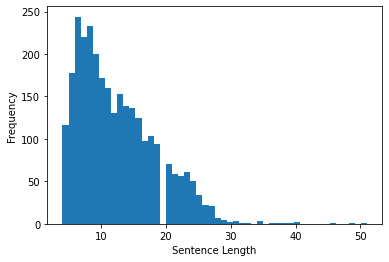

In [20]:
print(u2v_train['full_text_clean'])
u2v_train = u2v_train_lb[u2v_train_lb['full_text_clean'].str.split().str.len() >= 4].reset_index(drop=True)
print(u2v_train.shape)
u2v_test = u2v_test.sort_values(by=['author_id'])
u2v_test.reset_index(inplace=True, drop=True)
u2v_test.head()

# Calculate the length of each sentence
sentences = u2v_train['full_text_clean']
sentence_lengths = [len(sentence.split()) for sentence in sentences]
# Plot a histogram of sentence lengths
plt.hist(sentence_lengths, bins=50)
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

In [21]:
u2v_train_small_sentences = u2v_train[u2v_train['full_text_clean'].str.split().str.len() <= 5]
# u2v_train_small_sentences['label']

****need another processing because japanese text got filtered as using symbols****

In [22]:
# count the number of tweets for each author
counts = u2v_train['author_id'].value_counts()
print(counts.shape)
u2v_train = u2v_train.sort_values(by=['author_id'])
u2v_train.reset_index(inplace=True, drop=True)
u2v_train

(36,)


Unnamed: 0            author_id lang      conversation_id  \
0            672  1049708851262619648   es  1260629843143778304   
1            596  1049708851262619648   es  1109086761840504832   
2            597  1049708851262619648   ca  1623746786681622529   
3            646  1049708851262619648   es  1529195547181056002   
4            575  1049708851262619648   es  1549048322513858560   
...          ...                  ...  ...                  ...   
2904         549   864648405586280448   ja  1450990828877332482   
2905         547   864648405586280448   ja  1514406544540311554   
2906         563   864648405586280448   ja  1200221498872487937   
2907         571   864648405586280448   ja  1511556437901967363   
2908         570   864648405586280448   ja  1524218357247283200   

                    created_at   edit_history_tweet_ids  \
0     2020-05-13T17:55:50.000Z  ['1260629843143778304']   
1     2019-03-22T13:37:44.000Z  ['1109086761840504832']   
2     2023-02-09T18:12:56.000Z  ['1623746786681622529']   
3     2022-05-24T20:20:04.000Z  ['1529195547181056002']   
4     2022-07-18T15:07:54.000Z  ['1549048322513858560']   
...                        ...                      ...   
2904  2021-10-21T01:02:26.000Z  ['1450990828877332482']   
2905  2022-04-14T00:53:51.000Z  ['1514406544540311554']   
2906  2019-11-29T01:14:39.000Z  ['1200221498872487937']   
2907  2022-04-06T04:08:32.000Z  ['1511556437901967363']   
2908  2022-05-11T02:42:29.000Z  ['1524218357247283200']   

                                              full_text  label  \
0     Si tu sitio en internet lo tienes con #WordPre...      0   
1     ¡Aviso de Seguridad! Nueva variante de Ransomw...      1   
2     #cybersecurity advisory on ESXiARgs ransomware...      1   
3     👋 Hola ! Hoy te contamos lo que es #ingeniería...      0   
4     🤓 Recuerda! con el Multifactor de Autenticació...      0   
...                                                 ...    ...   
2904  メルカリをかたるフィッシングメールの報告が多数ありました。\n\n件名：メルカリ事務局からの...      1   
2905  au PAYをかたるフィッシングメールの報告がありました。\n\n件名：【au PAY】残高...      1   
2906  本日、UCカードをかたる不審なメールを多数確認しています。\n\n件名：UC CARD アッ...      1   
2907  UC CARDをかたるフィッシングメールの報告が複数ありました。\n\n件名：uccardカ...      1   
2908  JCBをかたるフィッシングメールの報告がありました。\n\n件名1：【JCB会員サービス】異...      1   

                                          entities.urls  \
0     [{'start': 94, 'end': 117, 'url': 'https://t.c...   
1     [{'start': 114, 'end': 137, 'url': 'https://t....   
2     [{'start': 56, 'end': 79, 'url': 'https://t.co...   
3     [{'start': 240, 'end': 263, 'url': 'https://t....   
4     [{'start': 175, 'end': 198, 'url': 'https://t....   
...                                                 ...   
2904  [{'start': 141, 'end': 164, 'url': 'https://t....   
2905  [{'start': 97, 'end': 120, 'url': 'https://t.c...   
2906  [{'start': 127, 'end': 150, 'url': 'https://t....   
2907  [{'start': 97, 'end': 120, 'url': 'https://t.c...   
2908  [{'start': 116, 'end': 139, 'url': 'https://t....   

                                   entities.annotations  ...  user_mentions  \
0     [{'start': 39, 'end': 47, 'probability': 0.965...  ...            NaN   
1     [{'start': 39, 'end': 53, 'probability': 0.562...  ...            NaN   
2                                                   NaN  ...            NaN   
3                                                   NaN  ...            NaN   
4     [{'start': 52, 'end': 60, 'probability': 0.688...  ...            NaN   
...                                                 ...  ...            ...   
2904  [{'start': 34, 'end': 40, 'probability': 0.392...  ...            NaN   
2905  [{'start': 0, 'end': 5, 'probability': 0.4405,...  ...            NaN   
2906                                                NaN  ...            NaN   
2907                                                NaN  ...            NaN   
2908  [{'start': 0, 'end': 2, 'probability': 0.5496,...  ...            NaN   

      screen_name  description  user_loca

> save to text - for the user2vec

In [23]:
u2v_train[['author_id', 'full_text_clean']].to_csv('u2v_train_v_2023_4_6.txt', sep='\t', index=False)
u2v_train.to_excel('u2v_train_v_2023_4_6.xlsx', encoding='utf-f8')
u2v_test[['author_id', 'full_text_clean']].to_csv('u2v_test_v_2023_4_6.txt', sep='\t', index=False)
u2v_test.to_excel('u2v_test_v2023_4_6.xlsx', encoding='utf-f8')

we could see in the new dataset

In [24]:
# Compute value counts for the label column
counts = u2v_train['label'].value_counts()


# Create a pie chart using plotly
fig = go.Figure(data=[go.Pie(labels=counts.index, values=counts.values,
                             hole=0.6,  # set the size of the center hole
                             marker=dict(colors=['#2B4A9D','#008B8B',  '#CD5C5C']),  # set the color of the slices
                             textfont=dict(size=20))])  # set the size of the slice labels

# Customize the layout
fig.update_layout(title='Label Distribution in Training Set', 
                  font=dict(size=16),
                  margin=dict(l=50, r=50, t=50, b=50),
                  plot_bgcolor='white',
                  paper_bgcolor='white')

# Show the plot
fig.show()

In [25]:
# Compute value counts for the label column
counts = u2v_test['label'].value_counts()


# Create a pie chart using plotly
fig = go.Figure(data=[go.Pie(labels=counts.index, values=counts.values,
                             hole=0.6,  # set the size of the center hole
                             marker=dict(colors=['#2B4A9D','#008B8B',  '#CD5C5C']),  # set the color of the slices
                             textfont=dict(size=20))])  # set the size of the slice labels

# Customize the layout
fig.update_layout(title='Label Distribution in Test Set', 
                  font=dict(size=16),
                  margin=dict(l=50, r=50, t=50, b=50),
                  plot_bgcolor='white',
                  paper_bgcolor='white')

# Show the plot
fig.show()

In [26]:
#data.to_csv('data_v2.csv',encoding = 'utf-8-sig')

In [27]:
# seed initialization
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

> LASER

In [28]:
!pip install -q laserembeddings laserembeddings[zh] laserembeddings[ja]
!pip install -q ftfy

In [29]:
!pip install fastcache
# import fasttext
import ftfy
import html
import laserembeddings
import sys

from fastcache import clru_cache
from laserembeddings import Laser
from typing import List, Union
from urllib.parse import unquote

  Preparing metadata (setup.py) ... - done
  Created wheel for fastcache: filename=fastcache-1.1.0-cp37-cp37m-linux_x86_64.whl size=46643 sha256=7af1bc5750cda84fed99efb90815c9fb405c79add9af5fa7ef17b531406b2f2b
  Stored in directory: /root/.cache/pip/wheels/ed/3a/69/4ac4d0d090ee49ab41ce5369f57f8f219f82b541de50a80ea9
Successfully built fastcache


LASER Embeddings This encodes each of the strings as a LASER embedding (1024 dimentional vector)

In [30]:
%%bash
# DOCS: https://github.com/facebookresearch/LASER/blob/master/install_models.sh
mkdir -p models/laser/
# for FILE in bilstm.eparl21.2018-11-19.pt eparl21.fcodes eparl21.fvocab bilstm.93langs.2018-12-26.pt 93langs.fcodes 93langs.fvocab; do
for FILE in bilstm.93langs.2018-12-26.pt 93langs.fcodes 93langs.fvocab; do
    wget -cq https://dl.fbaipublicfiles.com/laser/models/$FILE -O models/laser/$FILE
done

In [31]:
!pip install config
#from src.utils.fasttest_model import language_detect
# from src.utils.punkt_tokenizer import punkt_tokenize_sentences

config = {
    "laser": {
        "base_dir":  "./models/laser",
        "bpe_codes": "./models/laser/93langs.fcodes",
        "bpe_vocab": "./models/laser/93langs.fvocab",
        "encoder":   "./models/laser/bilstm.93langs.2018-12-26.pt",
    }
}

In [32]:
# Instantiate encoder
# BUG: CUDA GPU memory is exceeded if both laser and labse are loaded together 
# @clru_cache(None)
def get_laser_model():
    laser_model = Laser(
        bpe_codes = config['laser']['bpe_codes'],
        bpe_vocab = config['laser']['bpe_vocab'],
        encoder   = config['laser']['encoder'],
        tokenizer_options = None,
        embedding_options = None
    )
    return laser_model

def laser_encode(text: Union[str, List[str]], lang='autodetect', normalize=True) -> np.ndarray:
    """
    Encodes a corpus of text using LASER
    :param text: Large block of text (will be tokenized), or list of pre-tokenized sentences
    :param lang: 2 digit language code (optional autodetect)
    :return:     embedding matrix
    """
    laser_model = get_laser_model()
    
    if isinstance(text, str):
        # sentences = punkt_tokenize_sentences(text, lang=lang)
        sentences = ['text']

    else:
        sentences = list(text)

    embedding = laser_model.embed_sentences(sentences, lang=lang)
    
    if normalize:
        embedding = embedding / np.sqrt(np.sum(embedding**2, axis=1)).reshape(-1,1)
        
    return embedding

In [33]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
lb = LabelBinarizer()

In [34]:
def plot_history(history):
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('binary_accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [35]:
accuracy_list = []
loss_list = []
precision_list = []
recall_list = []
f1_score_list = []
auc_roc_list = []
mcc_list = []
model_name = []
training_time = []

In [36]:
import time
class TrainingTimeCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        end_time = time.time()
        elapsed_time = end_time - self.start_time
        print("Training time:", elapsed_time, "seconds")
        training_time.append(elapsed_time)

In [37]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import classification_report
# Compute confusion matrix
def confusion(predictions):
    cm = confusion_matrix(y_test1, predictions)
    accuracies = cm.diagonal()/cm.sum(axis=1)
    print(accuracies)
    print()

    # Calculate the average accuracy across all classes
    avg_accuracy = accuracies.mean()
    # Print the average accuracy
    print(avg_accuracy)
    print()
    
    # Print confusion matrix
    classes = np.unique(y_test1)
    print("Confusion matrix:")
    print(cm)
    print()

    # Print normalized confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix:")
    print(cm_norm)
    print()

    print("Classification report:")
    print(classification_report(y_test1, predictions, target_names=[f"label {c}" for c in classes]))
    
    auc_roc = roc_auc_score(y_test1, predictions) # y_pred_prob is the predicted probability of class 1
    mcc = matthews_corrcoef(y_test1, predictions)
    print("AUC-ROC:", auc_roc)
    print("MCC:", mcc)
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test1, predictions, average='macro')
    print("precision:", precision)
    print("recall:", recall)
    print("f1_score:", f1_score)

    precision_list.append(precision)
    recall_list.append(recall)
    f1_score_list.append(f1_score)
    auc_roc_list.append(auc_roc)
    mcc_list.append(mcc)
    model_name.append(m)

def results(model, x, y, x_t, y_t):    
    print('Train Accuracy: ')
    model.evaluate(x, y, verbose =1)

    print('Test Accuracy: ')
    loss, accuracy = model.evaluate(x_t , y_t , verbose =1)
    # Print the evaluation results
    print('Test loss:', loss)
    print('Test accuracy:', accuracy)
    accuracy_list.append(accuracy)
    loss_list.append(loss)
    
    prediction = model.predict(x_t)
    for i in range(len(prediction)):
        if (prediction[i] < 0.5):
            prediction[i] = 0
        else: 
            prediction[i] = 1
    confusion(prediction)


> Model
TensorFlow's Keras API provides a wide range of optimizers, including:

* Stochastic Gradient Descent (SGD)
* Adam
* Adagrad
* Adadelta
* RMSprop
* Nadam
* Adamax

L2 regularization, also known as weight decay, is a regularization technique that adds a penalty term to the loss function of the model to discourage large weights. This is done by adding the sum of the squares of all the weights in the model to the loss function, multiplied by a hyperparameter λ, which controls the strength of the regularization. This penalty term helps to prevent overfitting by encouraging the model to learn smaller weights.

In [38]:
epochs = 250
batch_size = 32
# Initialize counter for saved models
num_saved_models = 1
# epochs = 200
max_len = 1024
        
callback = tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)

def build_model(sh):    
    # Build the model
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(sh,)),
        tf.keras.layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(8, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid),
    ])
    model.compile(loss = tf.keras.losses.BinaryCrossentropy(), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  metrics =  [ tf.keras.metrics.BinaryAccuracy() ])
    print(model.summary())
    return model


def model_fit(model,x, y, x_v, y_v):
    global num_saved_models, m
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10, restore_best_weights=True)
    history = model.fit(x, y, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_split=0.2, 
                        validation_data=([x_v,y_v]),
                        verbose=0,
                        callbacks=[callback,TrainingTimeCallback()])
    
    plot_history(history)
    model.save(f"model_{m}_{num_saved_models}.h5")
    
    # Increment the counter for saved models
    num_saved_models += 1

The restore_best_weights parameter is set to True, which means that the weights of the best model found during training will be restored when the training stops.

> let's try to use the other embeddings

In [39]:
#the paths of our 4 embedding files
#test
emb_path_1 = r"/kaggle/input/u2v-train-test-2023-4-6/test_U_bert_bert-base-multilingual-cased_run2.txt"
emb_path_2 = r"/kaggle/input/u2v-train-test-2023-4-6/test_U_bert_bert-base-multilingual-cased_mean.txt"
#train
emb_path_3 = r"/kaggle/input/u2v-train-test-2023-4-6/train_U_bert_bert-base-multilingual-cased_run2.txt"
emb_path_4 = r"/kaggle/input/u2v-train-test-2023-4-6/train_U_bert_bert-base-multilingual-cased_mean.txt"

# read embeddings file
def from_u2v_to_dict(emb_path):
    with open(emb_path) as f:
        l = f.readline()
        l = f.readlines()
         # load embeddings from text file to a dictionary of arrays
        emb_by_uid = {}
        for e in l:
            e = e.split(' ', 1)
            emb_by_uid[int(e[0])] = np.fromstring(e[1], dtype=float, sep=' ')

        df = pd.DataFrame.from_dict(emb_by_uid, columns=None, orient='index')
        print(df.shape)
        return df
    
    
u2v_test_em = from_u2v_to_dict(emb_path_1)
u2v_train_em = from_u2v_to_dict(emb_path_3)
u2v_test_em_mean = from_u2v_to_dict(emb_path_2)
u2v_train_em_mean = from_u2v_to_dict(emb_path_4)

u2v_test_em1 = from_u2v_to_dict(emb_path_1)
u2v_train_em1 = from_u2v_to_dict(emb_path_3)
u2v_test_em_mean1 = from_u2v_to_dict(emb_path_2)
u2v_train_em_mean1 = from_u2v_to_dict(emb_path_4)

word_embeddings_train = u2v_train_em.to_numpy()
word_embeddings_test = u2v_test_em.to_numpy()


(28, 768)
(35, 768)
(28, 768)
(35, 768)
(28, 768)
(35, 768)
(28, 768)
(35, 768)


In [40]:
def look_for_nan(arrays):
    nan_positions = np.argwhere(np.isnan(arrays))
    print(nan_positions)

In [41]:
look_for_nan(word_embeddings_train)
look_for_nan(word_embeddings_test)

[]
[]


In [42]:
u2v_train_em1 = pd.DataFrame(u2v_train_em1)
u2v_train_em1 = u2v_train_em1.reset_index().rename(columns={'index': 'author_id'})
u2v_test_em1 = pd.DataFrame(u2v_train_em1)
# u2v_test_em1 = u2v_test_em1.reset_index().rename(columns={'index': 'author_id'})
u2v_test_em1

author_id         0         1         2         3         4  \
0            2187915589 -0.062271 -0.123938 -0.122418  0.137653 -0.153643   
1   1273938586623188992  0.177294 -0.018487 -0.123848  0.203774 -0.190446   
2             518338623 -0.185226  0.130046  0.142591 -0.116097  0.035553   
3   1118889805885190144 -0.101126  0.143539 -0.002998 -0.186475  0.086015   
4   1192514152016830464  0.183686 -0.024366  0.021004  0.001269 -0.215370   
5              56187579  0.023889  0.122496 -0.167817 -0.091253 -0.023621   
6             495814279 -0.229104 -0.134560  0.041918  0.197674 -0.215751   
7   1151096599168372736  0.036510  0.050611 -0.057233 -0.048102 -0.043578   
8             190566425  0.290938 -0.174342 -0.139067  0.192958 -0.007256   
9             392714686 -0.007571  0.064493  0.013315 -0.032235  0.017735   
10  1290574179729891336  0.191529 -0.037703 -0.056120  0.130120  0.064384   
11  1281147967873978368  0.007809 -0.044805 -0.128786 -0.131671  0.082890   
12  1238329176853114880 -0.103029 -0.112164  0.094256  0.120411  0.108253   
13           2364250093  0.053726 -0.049932 -0.029401  0.030135  0.054781   
14             11791512 -0.118528  0.068644  0.136366 -0.162103 -0.160587   
15   852970607440527360  0.171541  0.028801 -0.220063  0.040376 -0.139644   
16            184762389 -0.067502 -0.048015  0.143434  0.062809 -0.133220   
17   864648405586280448 -0.074015 -0.094954  0.084116 -0.231415  0.094391   
18   823527947848056835 -0.194304  0.125560  0.119222 -0.082747  0.144602   
19            153365707  0.031361  0.064532  0.014430 -0.047426 -0.038902   
20            137795216  0.064050 -0.125375  0.273891 -0.051710 -0.228332   
21            153826056  0.016158  0.092268  0.112920 -0.116660 -0.076971   
22            126727783 -0.122162 -0.074009 -0.145841 -0.023625 -0.125540   
23             26594542  0.076250  0.110510  0.084231 -0.052398  0.154901   
24            601041417  0.090527  0.087328 -0.006313 -0.055011  0.124696   
25           2787968336  0.073277  0.204685 -0.093382 -0.191617  0.160256   
26  1049708851262619648 -0.038324 -0.156717  0.048480  0.056736 -0.104177   
27             34204102 -0.132626  0.129348  0.162412 -0.138496  0.133842   
28           2282264556  0.178984 -0.066616  0.006275  0.156550  0.075201   
29           1201114460  0.160122 -0.156374 -0.145986  0.128198 -0.112877   
30             64812324 -0.022023 -0.166608 -0.013277 -0.041243 -0.061322   
31             50026664 -0.112809 -0.139125 -0.102095  0.033332  0.056106   
32   708914840711122945  0.196822 -0.075148  0.196796  0.064888 -0.222114   
33            328929990 -0.078299  0.018415  0.031250  0.015815 -0.091062   
34   825809883161260032 -0.053900  0.178101  0.067365  0.065159  0.239004   

           5         6         7         8  ...       758       759       760  \
0  -0.134735  0.031528 -0.152743 -0.116630  ...  0.137036 -0.147054 -0.168650   
1   0.155441  0.010278  0.103233 -0.149015  ...  0.118640 -0.144944 -0.127572   
2  -0.226501 -0.237831 -0.149266 -0.161653  ... -0.152854  0.148334  0.071823   
3   0.182541  0.136301  0.134679  0.200393  ...  0.008113  0.155613 -0.053153   
4   0.104916 -0.022272  0.053129 -0.211899  ...  0.148126 -0.025289  0.164768   
5   0.156082 -0.124032 -0.177697  0.139051  ... -0.060599  0.128011  0.049243   
6  -0.024175  0.079658  0.183361 -0.118499  ...  0.028312 -0.060357  0.153197   
7  -0.050341 -0.054699 -0.058811  0.014910  ... -0.055631  0.053485  0.050289   
8  -0.306527  0.121462  0.272155 -0.041102  ...  0.172687 -0.211609  0.259319   
9   0.078447 -0.037730 -0.020886  0.069850  ... -0.068648  0.068292 -0.051821   
10  0.144251 -0.199060 -0.165422  0.179052  ...  0.123332 -0.082533 -0.022357   
11  0.067627  0.093093 -0.160688  0.144907  ...  0.010151 -0.109473 -0.096612   
12  0.151432 -0.122972  0.003579 -0.093815  ...  0.137792 -0.131455 -0.096467   
13  0.046382 -0.047027  0.007044 -0.054518  ...  0.050848  0.045674 -0.006024   
14 -0.058952 -0.145297 -0.

In [43]:
u2v_test['full_text_clean']

0                      hola ingenieria social explicamos
1      uber cayo trampa ingenieria social tecnica usa...
2      hola conoces practica telefonica fraudulenta l...
3                        listos listos ofertas navidenas
4      cuidado felicitaciones electronicas ciberdelin...
                             ...                        
555    Ben Ri Shui Wu Shu Guo Shui Ting wokataruhuits...
556    Ben Xue noshisutemuwoWei Zhuang shitahuitsushi...
557    Ben Xue Wan emotettoSi warerumerugaDuo Shu Jie...
558    Zi Wei Dui Da Gui Mo Jie Zhong senta wokataruh...
559    Xue Nei webYue Lan Zhong pasokongauirusuniGan ...
Name: full_text_clean, Length: 560, dtype: object

In [44]:
u2v_train.columns
# Select columns to include in new train dataframe
df_new_train = pd.DataFrame({'author_id': u2v_train['author_id'], 'full_text_clean': u2v_train['full_text_clean'], 'label': u2v_train['label']})

# Print new dataframe
print(df_new_train)

# Select columns to include in new test dataframe
df_new_test = pd.DataFrame({'author_id': u2v_test['author_id'], 'full_text_clean': u2v_test['full_text_clean'], 'label': u2v_test['label']})

# Print new dataframe
print(df_new_test)

                author_id                                    full_text_clean  \
0     1049708851262619648  sitio internet wordpress siguientes recomendac...   
1     1049708851262619648  aviso seguridad variante ransomware cuidado de...   
2     1049708851262619648  cybersecurity advisory esxiargs ransomware cam...   
3     1049708851262619648  hola contamos ingenieria social manipulacion p...   
4     1049708851262619648  recuerda multifactor autenticacion office365 a...   
...                   ...                                                ...   
2904   864648405586280448  merukariwokataruhuitsushingumerunoBao Gao gaDu...   
2905   864648405586280448  paywokataruhuitsushingumerunoBao Gao gaarimash...   
2906   864648405586280448  Ben Ri uckadowokataruBu Shen nameruwoDuo Shu Q...   
2907   864648405586280448  uc cardwokataruhuitsushingumerunoBao Gao gaFu ...   
2908   864648405586280448  jcbwokataruhuitsushingumerunoBao Gao gaarimash...   

      label  
0         0  
1         1

In [45]:
df_new_train['author_id'] = df_new_train['author_id'].astype(str)
df_new_test['author_id'] = df_new_test['author_id'].astype(str)
u2v_train_em1['author_id'] = u2v_train_em1['author_id'].astype(str)
u2v_test_em1['author_id'] = u2v_test_em1['author_id'].astype(str)


In [46]:
# merge on author_id column
result_train = pd.merge(df_new_train, u2v_train_em1, on='author_id', how='left')
print('Train: ')
print(result_train.head())
result_test = pd.merge(df_new_test, u2v_test_em1, on='author_id', how='left')
print('Test: ')
print(result_test.head())

Train: 
             author_id                                    full_text_clean  \
0  1049708851262619648  sitio internet wordpress siguientes recomendac...   
1  1049708851262619648  aviso seguridad variante ransomware cuidado de...   
2  1049708851262619648  cybersecurity advisory esxiargs ransomware cam...   
3  1049708851262619648  hola contamos ingenieria social manipulacion p...   
4  1049708851262619648  recuerda multifactor autenticacion office365 a...   

   label         0         1        2         3         4         5         6  \
0      0 -0.038324 -0.156717  0.04848  0.056736 -0.104177 -0.036362  0.221375   
1      1 -0.038324 -0.156717  0.04848  0.056736 -0.104177 -0.036362  0.221375   
2      1 -0.038324 -0.156717  0.04848  0.056736 -0.104177 -0.036362  0.221375   
3      0 -0.038324 -0.156717  0.04848  0.056736 -0.104177 -0.036362  0.221375   
4      0 -0.038324 -0.156717  0.04848  0.056736 -0.104177 -0.036362  0.221375   

   ...       758      759       760      7

In [47]:
print(result_train.iloc[2176])
result_train[result_train['author_id'] == '37888607']

author_id                                                   37888607
full_text_clean    verizon admitted marketing vendor data breach ...
label                                                              1
0                                                                NaN
1                                                                NaN
                                         ...                        
763                                                              NaN
764                                                              NaN
765                                                              NaN
766                                                              NaN
767                                                              NaN
Name: 2176, Length: 771, dtype: object


author_id                                    full_text_clean  label   0  \
2176  37888607  verizon admitted marketing vendor data breach ...      1 NaN   

       1   2   3   4   5   6  ...  758  759  760  761  762  763  764  765  \
2176 NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

      766  767  
2176  NaN  NaN  

[1 rows x 771 columns]

In [48]:
result_train = result_train.drop(index=2176)

result_train.to_excel('result_train.xlsx', index=False, encoding='utf-8-sig')
result_test.to_excel('result_test.xlsx', index=False, encoding='utf-8-sig')


we won't change the test set:

In [49]:
X_test1 = result_test['full_text_clean']
y_test1 = result_test['label']
X_test1 = laser_encode(X_test1)
y_test1 = lb.fit_transform(y_test1)

#changeble vectors
X_train = result_train['full_text_clean']
y_train = result_train['label']
X_train = laser_encode(X_train)
y_train = lb.fit_transform(y_train)
X_train.shape

(2908, 1024)

(2181, 1024)
(727, 1024)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (N

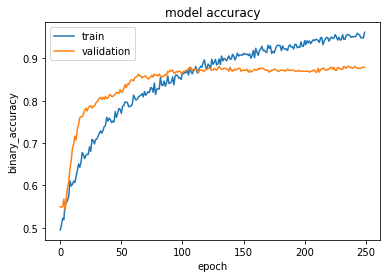

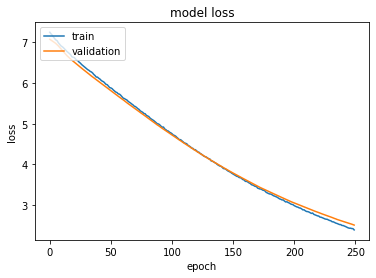

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.3502 - binary_accuracy: 0.9711
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 2.5741 - binary_accuracy: 0.8482
Test loss: 2.5740973949432373
Test accuracy: 0.8482142686843872
[0.86629526 0.8159204 ]

0.8411078313169529

Confusion matrix:
[[311  48]
 [ 37 164]]

Normalized confusion matrix:
[[0.86629526 0.13370474]
 [0.1840796  0.8159204 ]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.89      0.87      0.88       359
     label 1       0.77      0.82      0.79       201

    accuracy                           0.85       560
   macro avg       0.83      0.84      0.84       560
weighted avg       0.85      0.85      0.85       560

AUC-ROC: 0.8411078313169528
MCC: 0.6746979436147338
precision: 0.8336315332899589
recall: 0.8411078313169529
f1_score: 0.836981276820176
(2181, 1024)
(727, 1024)
Model: "sequential_1"
_____________

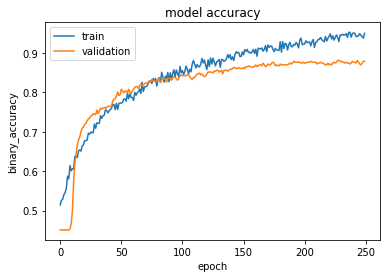

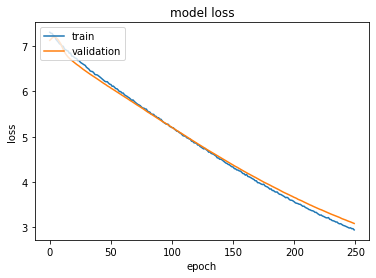

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.8981 - binary_accuracy: 0.9679
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 3.1370 - binary_accuracy: 0.8554
Test loss: 3.1369776725769043
Test accuracy: 0.8553571701049805
[0.8551532  0.85572139]

0.8554372981887222

Confusion matrix:
[[307  52]
 [ 29 172]]

Normalized confusion matrix:
[[0.8551532  0.1448468 ]
 [0.14427861 0.85572139]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.91      0.86      0.88       359
     label 1       0.77      0.86      0.81       201

    accuracy                           0.86       560
   macro avg       0.84      0.86      0.85       560
weighted avg       0.86      0.86      0.86       560

AUC-ROC: 0.8554372981887222
MCC: 0.6960566705394643
precision: 0.8407738095238095
recall: 0.8554372981887222
f1_score: 0.8464325010579771
(2181, 1024)
(727, 1024)
Model: "sequential_2"
____________

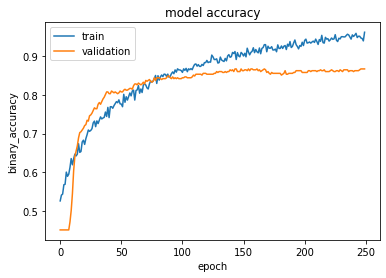

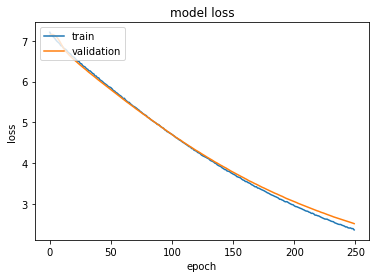

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.3348 - binary_accuracy: 0.9670
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 2.5647 - binary_accuracy: 0.8357
Test loss: 2.564697265625
Test accuracy: 0.8357142806053162
[0.8189415  0.86567164]

0.8423065729846588

Confusion matrix:
[[294  65]
 [ 27 174]]

Normalized confusion matrix:
[[0.8189415  0.1810585 ]
 [0.13432836 0.86567164]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.92      0.82      0.86       359
     label 1       0.73      0.87      0.79       201

    accuracy                           0.84       560
   macro avg       0.82      0.84      0.83       560
weighted avg       0.85      0.84      0.84       560

AUC-ROC: 0.8423065729846588
MCC: 0.6639555729723464
precision: 0.8219606616353186
recall: 0.8423065729846588
f1_score: 0.8278074866310161
(2181, 1024)
(727, 1024)
Model: "sequential_3"
________________

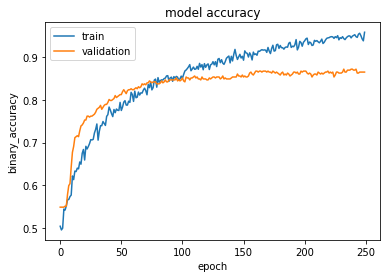

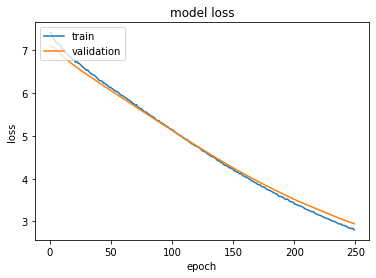

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.7598 - binary_accuracy: 0.9674
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 3.0008 - binary_accuracy: 0.8464
Test loss: 3.000839948654175
Test accuracy: 0.8464285731315613
[0.8551532  0.83084577]

0.8429994872434485

Confusion matrix:
[[307  52]
 [ 34 167]]

Normalized confusion matrix:
[[0.8551532  0.1448468 ]
 [0.16915423 0.83084577]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.90      0.86      0.88       359
     label 1       0.76      0.83      0.80       201

    accuracy                           0.85       560
   macro avg       0.83      0.84      0.84       560
weighted avg       0.85      0.85      0.85       560

AUC-ROC: 0.8429994872434485
MCC: 0.6743253283912505
precision: 0.8314251663787677
recall: 0.8429994872434485
f1_score: 0.8361904761904762
(2181, 1024)
(727, 1024)
Model: "sequential_4"
_____________

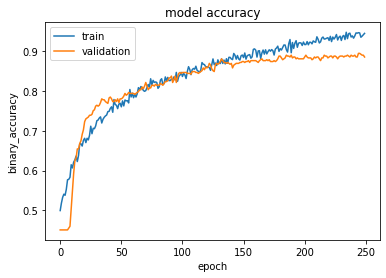

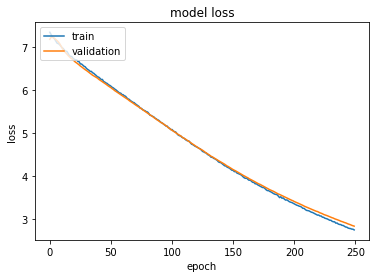

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.6815 - binary_accuracy: 0.9670
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 2.9292 - binary_accuracy: 0.8250
Test loss: 2.9292163848876953
Test accuracy: 0.824999988079071
[0.7994429  0.87064677]

0.8350448315525437

Confusion matrix:
[[287  72]
 [ 26 175]]

Normalized confusion matrix:
[[0.7994429  0.2005571 ]
 [0.12935323 0.87064677]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.92      0.80      0.85       359
     label 1       0.71      0.87      0.78       201

    accuracy                           0.82       560
   macro avg       0.81      0.84      0.82       560
weighted avg       0.84      0.82      0.83       560

AUC-ROC: 0.8350448315525436
MCC: 0.6473773881103875
precision: 0.8127174658198704
recall: 0.8350448315525437
f1_score: 0.8177083333333335
(2181, 1024)
(727, 1024)
Model: "sequential_5"
_____________

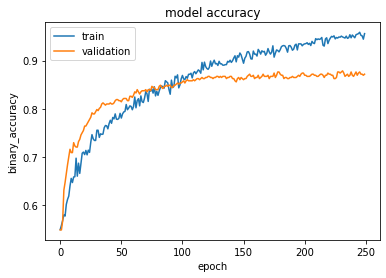

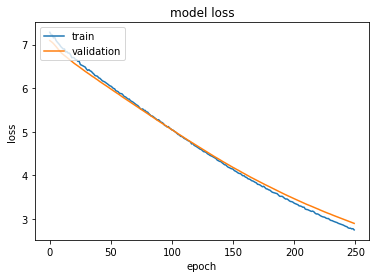

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.7001 - binary_accuracy: 0.9716
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 2.9343 - binary_accuracy: 0.8500
Test loss: 2.934342622756958
Test accuracy: 0.8500000238418579
[0.86908078 0.8159204 ]

0.84250058897712

Confusion matrix:
[[312  47]
 [ 37 164]]

Normalized confusion matrix:
[[0.86908078 0.13091922]
 [0.1840796  0.8159204 ]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.89      0.87      0.88       359
     label 1       0.78      0.82      0.80       201

    accuracy                           0.85       560
   macro avg       0.84      0.84      0.84       560
weighted avg       0.85      0.85      0.85       560

AUC-ROC: 0.8425005889771199
MCC: 0.678082646725312
precision: 0.8356169964285229
recall: 0.84250058897712
f1_score: 0.8387362185288794
(2181, 1024)
(727, 1024)
Model: "sequential_6"
__________________

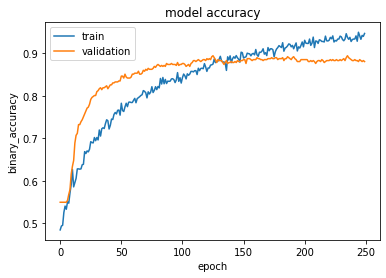

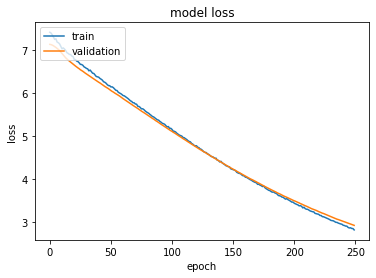

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.7791 - binary_accuracy: 0.9674
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 3.0110 - binary_accuracy: 0.8500
Test loss: 3.010995864868164
Test accuracy: 0.8500000238418579
[0.8913649 0.7761194]

0.8337421527460191

Confusion matrix:
[[320  39]
 [ 45 156]]

Normalized confusion matrix:
[[0.8913649 0.1086351]
 [0.2238806 0.7761194]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.88      0.89      0.88       359
     label 1       0.80      0.78      0.79       201

    accuracy                           0.85       560
   macro avg       0.84      0.83      0.84       560
weighted avg       0.85      0.85      0.85       560

AUC-ROC: 0.8337421527460191
MCC: 0.672082479153432
precision: 0.8383561643835616
recall: 0.8337421527460191
f1_score: 0.8359283442156371
(2181, 1024)
(727, 1024)
Model: "sequential_7"
____________________

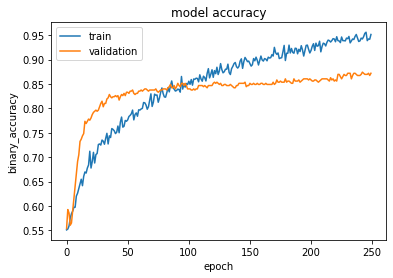

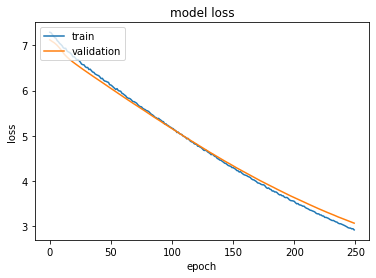

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.8850 - binary_accuracy: 0.9697
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 3.1182 - binary_accuracy: 0.8446
Test loss: 3.118229389190674
Test accuracy: 0.8446428775787354
[0.86350975 0.81094527]

0.837227511467731

Confusion matrix:
[[310  49]
 [ 38 163]]

Normalized confusion matrix:
[[0.86350975 0.13649025]
 [0.18905473 0.81094527]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.89      0.86      0.88       359
     label 1       0.77      0.81      0.79       201

    accuracy                           0.84       560
   macro avg       0.83      0.84      0.83       560
weighted avg       0.85      0.84      0.85       560

AUC-ROC: 0.837227511467731
MCC: 0.6670228227805692
precision: 0.8298362611147256
recall: 0.837227511467731
f1_score: 0.8331455421571212
(2181, 1024)
(727, 1024)
Model: "sequential_8"
________________

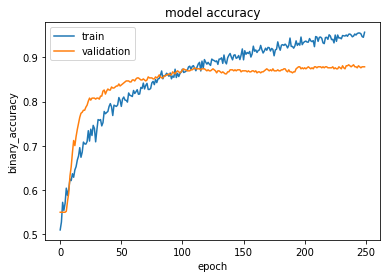

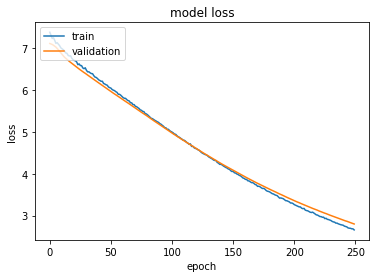

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.6127 - binary_accuracy: 0.9716
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 2.8528 - binary_accuracy: 0.8393
Test loss: 2.8527910709381104
Test accuracy: 0.8392857313156128
[0.86350975 0.7960199 ]

0.8297648249005668

Confusion matrix:
[[310  49]
 [ 41 160]]

Normalized confusion matrix:
[[0.86350975 0.13649025]
 [0.2039801  0.7960199 ]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.88      0.86      0.87       359
     label 1       0.77      0.80      0.78       201

    accuracy                           0.84       560
   macro avg       0.82      0.83      0.83       560
weighted avg       0.84      0.84      0.84       560

AUC-ROC: 0.8297648249005668
MCC: 0.6541131441002956
precision: 0.8243705612126665
recall: 0.8297648249005668
f1_score: 0.8268636207488835
(2181, 1024)
(727, 1024)
Model: "sequential_9"
____________

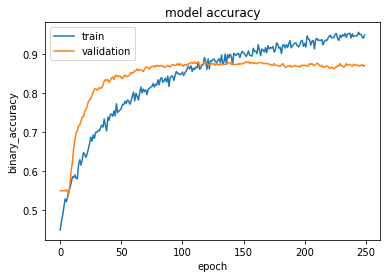

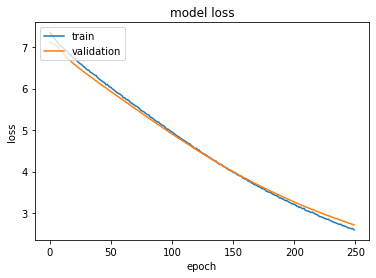

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.5501 - binary_accuracy: 0.9674
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 2.7711 - binary_accuracy: 0.8643
Test loss: 2.771120548248291
Test accuracy: 0.8642857074737549
[0.86629526 0.86069652]

0.8634958910184454

Confusion matrix:
[[311  48]
 [ 28 173]]

Normalized confusion matrix:
[[0.86629526 0.13370474]
 [0.13930348 0.86069652]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.92      0.87      0.89       359
     label 1       0.78      0.86      0.82       201

    accuracy                           0.86       560
   macro avg       0.85      0.86      0.86       560
weighted avg       0.87      0.86      0.87       560

AUC-ROC: 0.8634958910184454
MCC: 0.7134750139807731
precision: 0.8501047798288819
recall: 0.8634958910184454
f1_score: 0.8555113458900854


In [50]:
epochs = 250
for i in range(0, 10):
    # train - validation split:
    X_train1, X_val1, y_train1, y_val1  = train_test_split(X_train, y_train, test_size=0.25, random_state=0)
    print(X_train1.shape)
    print(X_val1.shape)

    m = 'laser_em_batchnorm_l2'
    model1 = build_model(1024)
    model_fit(model1, X_train1, y_train1, X_val1, y_val1)
    results(model1, X_train1, y_train1, X_test1, y_test1)
    i += 1

is it better without batchnormalization??????

In [51]:
def build_model(sh):    
    # Build the model
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(sh,)),
        tf.keras.layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)),
#             tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)),
#             tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)),
#             tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(8, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)),
#             tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid),
    ])
    model.compile(loss = tf.keras.losses.BinaryCrossentropy(), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  metrics =  [ tf.keras.metrics.BinaryAccuracy() ])
    print(model.summary())
    return model



Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_40 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_41 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_42 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 8)               

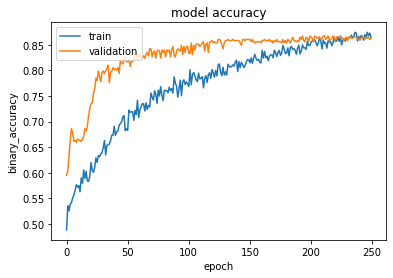

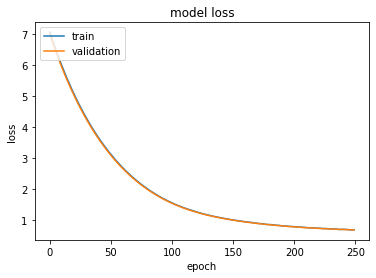

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 0.6584 - binary_accuracy: 0.9000
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 0.7231 - binary_accuracy: 0.8411
Test loss: 0.7231332659721375
Test accuracy: 0.8410714268684387
[0.8356546  0.85074627]

0.8432004323784975

Confusion matrix:
[[300  59]
 [ 30 171]]

Normalized confusion matrix:
[[0.8356546  0.1643454 ]
 [0.14925373 0.85074627]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.91      0.84      0.87       359
     label 1       0.74      0.85      0.79       201

    accuracy                           0.84       560
   macro avg       0.83      0.84      0.83       560
weighted avg       0.85      0.84      0.84       560

AUC-ROC: 0.8432004323784976
MCC: 0.6692712772670167
precision: 0.8262845849802372
recall: 0.8432004323784975
f1_score: 0.832165383100024
Model: "sequential_11"
_____________________________________

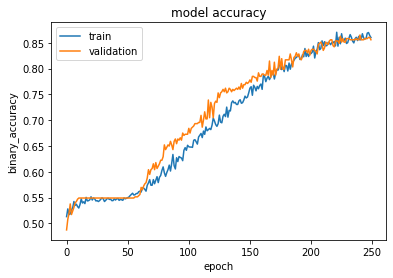

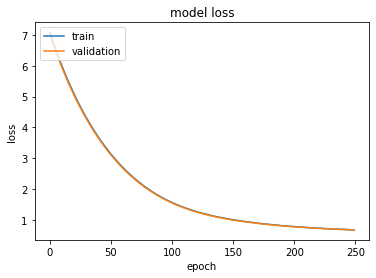

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 0.6573 - binary_accuracy: 0.9005
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 0.6829 - binary_accuracy: 0.8446
Test loss: 0.682897686958313
Test accuracy: 0.8446428775787354
[0.89972145 0.74626866]

0.8229950525921923

Confusion matrix:
[[323  36]
 [ 51 150]]

Normalized confusion matrix:
[[0.89972145 0.10027855]
 [0.25373134 0.74626866]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.86      0.90      0.88       359
     label 1       0.81      0.75      0.78       201

    accuracy                           0.84       560
   macro avg       0.84      0.82      0.83       560
weighted avg       0.84      0.84      0.84       560

AUC-ROC: 0.8229950525921921
MCC: 0.6579287214034669
precision: 0.8350439882697946
recall: 0.8229950525921923
f1_score: 0.8282517423353111
Model: "sequential_12"
_____________________________________

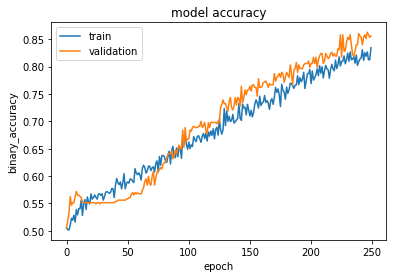

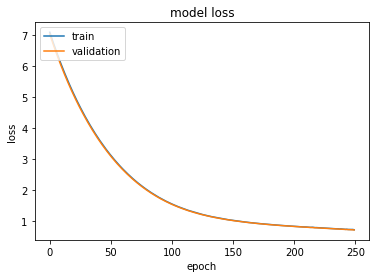

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 0.6943 - binary_accuracy: 0.8735
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 0.7083 - binary_accuracy: 0.8321
Test loss: 0.7083432674407959
Test accuracy: 0.8321428298950195
[0.89415042 0.72139303]

0.8077717263265844

Confusion matrix:
[[321  38]
 [ 56 145]]

Normalized confusion matrix:
[[0.89415042 0.10584958]
 [0.27860697 0.72139303]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.85      0.89      0.87       359
     label 1       0.79      0.72      0.76       201

    accuracy                           0.83       560
   macro avg       0.82      0.81      0.81       560
weighted avg       0.83      0.83      0.83       560

AUC-ROC: 0.8077717263265844
MCC: 0.6295174154223525
precision: 0.8219043063588004
recall: 0.8077717263265844
f1_score: 0.8137454710144927
Model: "sequential_13"
____________________________________

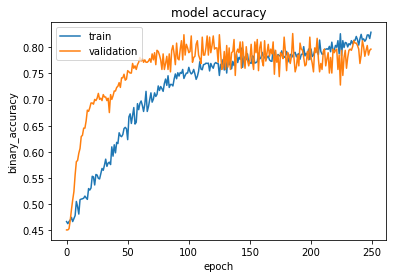

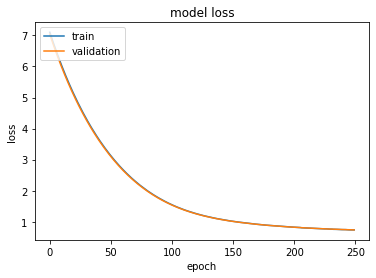

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 0.7315 - binary_accuracy: 0.8175
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 0.7731 - binary_accuracy: 0.7482
Test loss: 0.7730958461761475
Test accuracy: 0.7482143044471741
[0.6545961  0.91542289]

0.7850094929253455

Confusion matrix:
[[235 124]
 [ 17 184]]

Normalized confusion matrix:
[[0.6545961  0.3454039 ]
 [0.08457711 0.91542289]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.93      0.65      0.77       359
     label 1       0.60      0.92      0.72       201

    accuracy                           0.75       560
   macro avg       0.76      0.79      0.75       560
weighted avg       0.81      0.75      0.75       560

AUC-ROC: 0.7850094929253455
MCC: 0.5496154664600528
precision: 0.76497113997114
recall: 0.7850094929253455
f1_score: 0.7461085083874868
Model: "sequential_14"
______________________________________

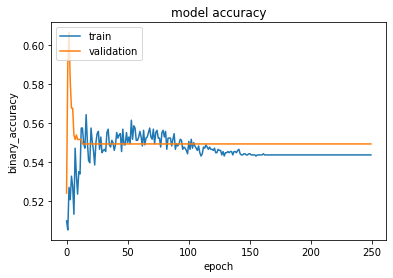

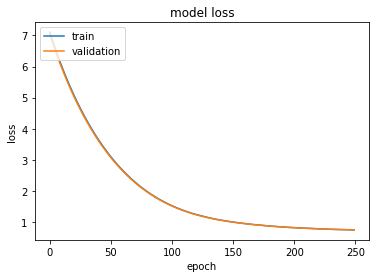

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 0.7528 - binary_accuracy: 0.5447
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 0.7417 - binary_accuracy: 0.6411
Test loss: 0.7416650652885437
Test accuracy: 0.6410714387893677
[1. 0.]

0.5

Confusion matrix:
[[359   0]
 [201   0]]

Normalized confusion matrix:
[[1. 0.]
 [1. 0.]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.64      1.00      0.78       359
     label 1       0.00      0.00      0.00       201

    accuracy                           0.64       560
   macro avg       0.32      0.50      0.39       560
weighted avg       0.41      0.64      0.50       560

AUC-ROC: 0.5
MCC: 0.0
precision: 0.3205357142857143
recall: 0.5
f1_score: 0.39064200217627854
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (D

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

Training time: 52.98957657814026 seconds


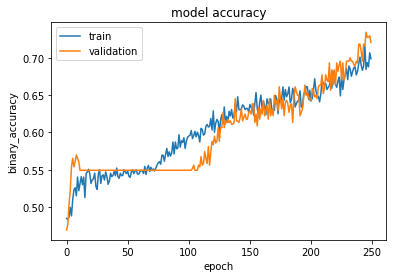

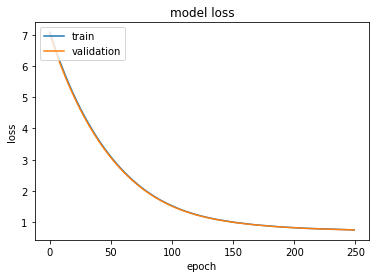

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 0.7529 - binary_accuracy: 0.7180
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 0.7469 - binary_accuracy: 0.7321
Test loss: 0.7469379305839539
Test accuracy: 0.7321428656578064
[0.99721448 0.25870647]

0.6279604761706786

Confusion matrix:
[[358   1]
 [149  52]]

Normalized confusion matrix:
[[0.99721448 0.00278552]
 [0.74129353 0.25870647]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.71      1.00      0.83       359
     label 1       0.98      0.26      0.41       201

    accuracy                           0.73       560
   macro avg       0.84      0.63      0.62       560
weighted avg       0.80      0.73      0.68       560

AUC-ROC: 0.6279604761706786
MCC: 0.41938141600712137
precision: 0.8436232369468945
recall: 0.6279604761706786
f1_score: 0.6181193286174101
Model: "sequential_16"
___________________________________

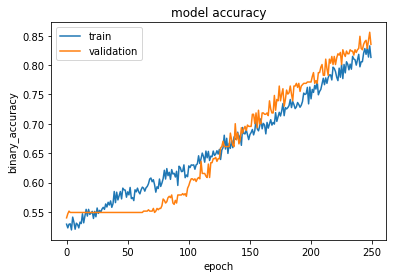

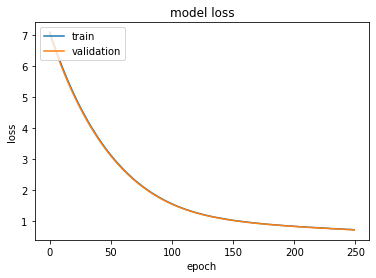

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 0.6947 - binary_accuracy: 0.8597
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 0.7019 - binary_accuracy: 0.8161
Test loss: 0.7018834948539734
Test accuracy: 0.8160714507102966
[0.90529248 0.65671642]

0.7810044485095414

Confusion matrix:
[[325  34]
 [ 69 132]]

Normalized confusion matrix:
[[0.90529248 0.09470752]
 [0.34328358 0.65671642]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.82      0.91      0.86       359
     label 1       0.80      0.66      0.72       201

    accuracy                           0.82       560
   macro avg       0.81      0.78      0.79       560
weighted avg       0.81      0.82      0.81       560

AUC-ROC: 0.7810044485095415
MCC: 0.5903183574129887
precision: 0.8100269096691334
recall: 0.7810044485095414
f1_score: 0.7912799302336522
Model: "sequential_17"
____________________________________

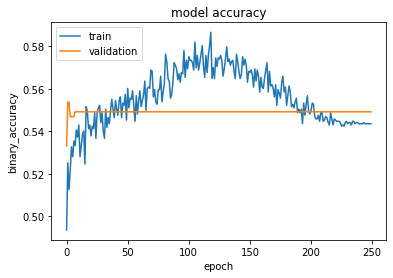

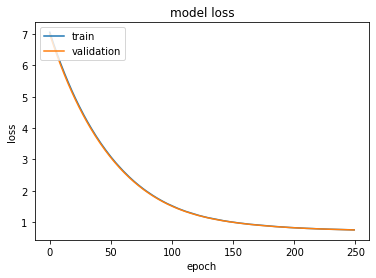

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 0.7504 - binary_accuracy: 0.5447
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 0.7398 - binary_accuracy: 0.6411
Test loss: 0.7397544980049133
Test accuracy: 0.6410714387893677
[1. 0.]

0.5

Confusion matrix:
[[359   0]
 [201   0]]

Normalized confusion matrix:
[[1. 0.]
 [1. 0.]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.64      1.00      0.78       359
     label 1       0.00      0.00      0.00       201

    accuracy                           0.64       560
   macro avg       0.32      0.50      0.39       560
weighted avg       0.41      0.64      0.50       560

AUC-ROC: 0.5
MCC: 0.0
precision: 0.3205357142857143
recall: 0.5
f1_score: 0.39064200217627854
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (D

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

Training time: 53.6427845954895 seconds


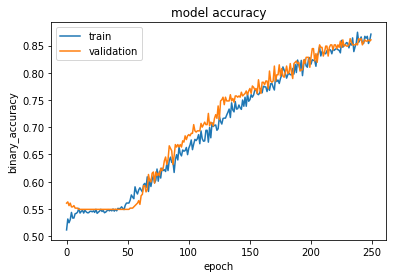

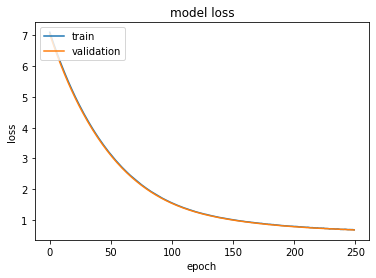

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 0.6619 - binary_accuracy: 0.8927
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 0.6852 - binary_accuracy: 0.8357
Test loss: 0.6851929426193237
Test accuracy: 0.8357142806053162
[0.89972145 0.72139303]

0.8105572416469187

Confusion matrix:
[[323  36]
 [ 56 145]]

Normalized confusion matrix:
[[0.89972145 0.10027855]
 [0.27860697 0.72139303]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.85      0.90      0.88       359
     label 1       0.80      0.72      0.76       201

    accuracy                           0.84       560
   macro avg       0.83      0.81      0.82       560
weighted avg       0.83      0.84      0.83       560

AUC-ROC: 0.8105572416469186
MCC: 0.6370272594695044
precision: 0.8266738582195076
recall: 0.8105572416469187
f1_score: 0.8172505285262277
Model: "sequential_19"
____________________________________

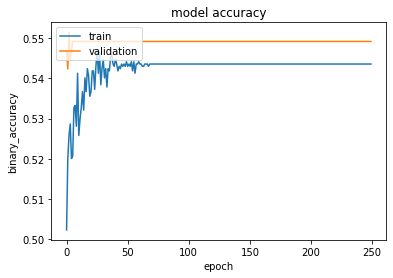

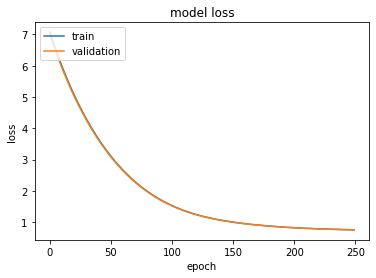

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 0.7550 - binary_accuracy: 0.5447
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 0.7414 - binary_accuracy: 0.6411
Test loss: 0.7413716316223145
Test accuracy: 0.6410714387893677
[1. 0.]

0.5

Confusion matrix:
[[359   0]
 [201   0]]

Normalized confusion matrix:
[[1. 0.]
 [1. 0.]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.64      1.00      0.78       359
     label 1       0.00      0.00      0.00       201

    accuracy                           0.64       560
   macro avg       0.32      0.50      0.39       560
weighted avg       0.41      0.64      0.50       560

AUC-ROC: 0.5
MCC: 0.0
precision: 0.3205357142857143
recall: 0.5
f1_score: 0.39064200217627854


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

In [52]:
for i in range(0, 10):
    # train - validation split:
    X_train1, X_val1, y_train1, y_val1  = train_test_split(X_train, y_train, test_size=0.25, random_state=0)
    m = 'laser_em_l2'
    model2 = build_model(1024)
    model_fit(model2, X_train1, y_train1, X_val1, y_val1)
    results(model2, X_train1, y_train1, X_test1, y_test1)
    i += 1

> use of both regularizers l1 + l2:
* Elastic Net regularization. It combines the penalties of both L1 and L2 regularization and is particularly useful when dealing with high-dimensional data. The Elastic Net penalty term is defined as a linear combination of the L1 and L2 norms of the model parameters.

L1 is the L1 norm penalty, L2 is the L2 norm penalty, and l1_ratio is a hyperparameter that controls the relative weight of the L1 and L2 penalties.

When l1_ratio=1, the penalty becomes the L1 norm penalty, and when l1_ratio=0, the penalty becomes the L2 norm penalty.

In [53]:
def build_model(sh):    
    # Build the model
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(sh,)),
        tf.keras.layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.1), 
                              kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1), 
                              kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.1), 
                              kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(8, activation=tf.keras.layers.LeakyReLU(alpha=0.1), 
                              kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid),
    ])
    model.compile(loss = tf.keras.losses.BinaryCrossentropy(), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  metrics =  [ tf.keras.metrics.BinaryAccuracy() ])
    print(model.summary())
    return model


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 256)               262400    
_________________________________________________________________
batch_normalization_40 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_80 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_101 (Dense)            (None, 128)               32896     
_________________________________________________________________
batch_normalization_41 (Batc (None, 128)               512       
_________________________________________________________________
dropout_81 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_102 (Dense)            (None, 32)              

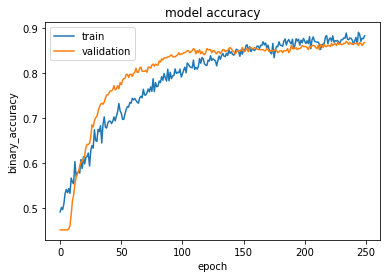

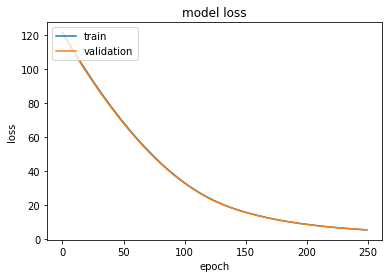

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 5.2718 - binary_accuracy: 0.9248
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 5.4349 - binary_accuracy: 0.8357
Test loss: 5.434947967529297
Test accuracy: 0.8357142806053162
[0.82172702 0.86069652]

0.8412117684557713

Confusion matrix:
[[295  64]
 [ 28 173]]

Normalized confusion matrix:
[[0.82172702 0.17827298]
 [0.13930348 0.86069652]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.91      0.82      0.87       359
     label 1       0.73      0.86      0.79       201

    accuracy                           0.84       560
   macro avg       0.82      0.84      0.83       560
weighted avg       0.85      0.84      0.84       560

AUC-ROC: 0.8412117684557713
MCC: 0.6625578687143041
precision: 0.8216352497028125
recall: 0.8412117684557713
f1_score: 0.8275284885978655
Model: "sequential_21"
_____________________________________

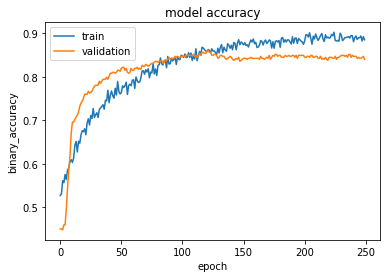

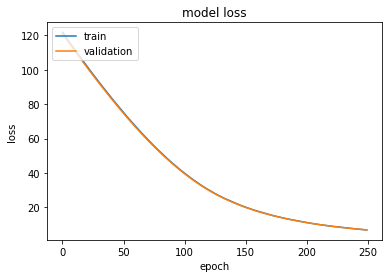

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 6.8100 - binary_accuracy: 0.9298
Test Accuracy: 
18/18 [==============================] - 0s 3ms/step - loss: 7.0104 - binary_accuracy: 0.8250
Test loss: 7.010436058044434
Test accuracy: 0.824999988079071
[0.83844011 0.80099502]

0.8197175681481174

Confusion matrix:
[[301  58]
 [ 40 161]]

Normalized confusion matrix:
[[0.83844011 0.16155989]
 [0.19900498 0.80099502]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.88      0.84      0.86       359
     label 1       0.74      0.80      0.77       201

    accuracy                           0.82       560
   macro avg       0.81      0.82      0.81       560
weighted avg       0.83      0.82      0.83       560

AUC-ROC: 0.8197175681481175
MCC: 0.6285538671400717
precision: 0.8089288822828372
recall: 0.8197175681481174
f1_score: 0.8133333333333332
Model: "sequential_22"
______________________________________

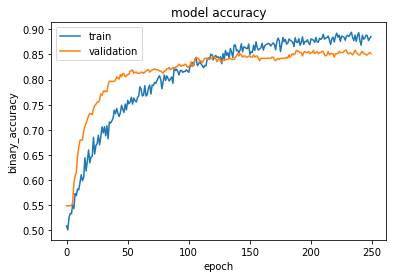

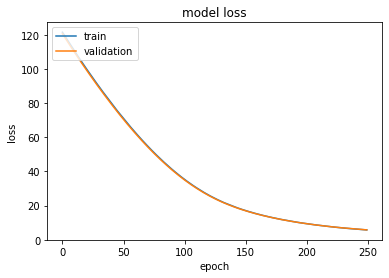

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 5.6806 - binary_accuracy: 0.9243
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 5.8526 - binary_accuracy: 0.8196
Test loss: 5.852642059326172
Test accuracy: 0.8196428418159485
[0.86908078 0.73134328]

0.8002120317631896

Confusion matrix:
[[312  47]
 [ 54 147]]

Normalized confusion matrix:
[[0.86908078 0.13091922]
 [0.26865672 0.73134328]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.85      0.87      0.86       359
     label 1       0.76      0.73      0.74       201

    accuracy                           0.82       560
   macro avg       0.81      0.80      0.80       560
weighted avg       0.82      0.82      0.82       560

AUC-ROC: 0.8002120317631896
MCC: 0.60528781982664
precision: 0.8050954875781646
recall: 0.8002120317631896
f1_score: 0.802496726320384
Model: "sequential_23"
________________________________________

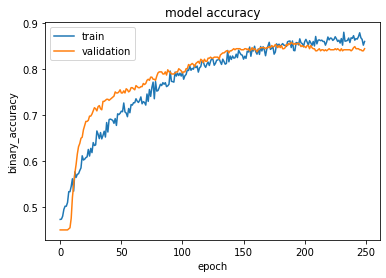

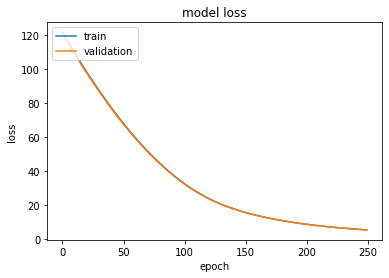

Train Accuracy: 
69/69 [==============================] - 0s 3ms/step - loss: 5.1916 - binary_accuracy: 0.9060
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 5.3203 - binary_accuracy: 0.8286
Test loss: 5.320307731628418
Test accuracy: 0.8285714387893677
[0.80779944 0.86567164]

0.8367355423439904

Confusion matrix:
[[290  69]
 [ 27 174]]

Normalized confusion matrix:
[[0.80779944 0.19220056]
 [0.13432836 0.86567164]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.91      0.81      0.86       359
     label 1       0.72      0.87      0.78       201

    accuracy                           0.83       560
   macro avg       0.82      0.84      0.82       560
weighted avg       0.84      0.83      0.83       560

AUC-ROC: 0.8367355423439903
MCC: 0.6518256392425875
precision: 0.8154379405693811
recall: 0.8367355423439904
f1_score: 0.8208859747321287
Model: "sequential_24"
_____________________________________

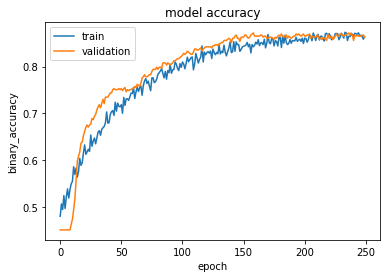

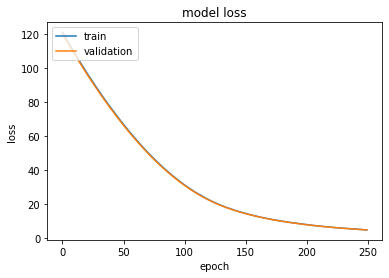

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 4.5287 - binary_accuracy: 0.9115
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 4.6536 - binary_accuracy: 0.8304
Test loss: 4.653603553771973
Test accuracy: 0.8303571343421936
[0.8189415  0.85074627]

0.8348438864174947

Confusion matrix:
[[294  65]
 [ 30 171]]

Normalized confusion matrix:
[[0.8189415  0.1810585 ]
 [0.14925373 0.85074627]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.91      0.82      0.86       359
     label 1       0.72      0.85      0.78       201

    accuracy                           0.83       560
   macro avg       0.82      0.83      0.82       560
weighted avg       0.84      0.83      0.83       560

AUC-ROC: 0.8348438864174947
MCC: 0.6505626350979419
precision: 0.8159918392969241
recall: 0.8348438864174947
f1_score: 0.8217582277675217
Model: "sequential_25"
_____________________________________

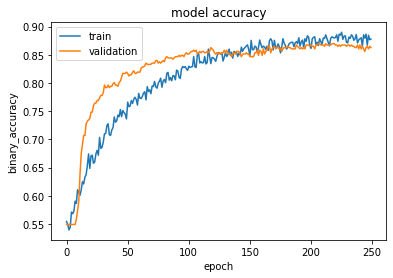

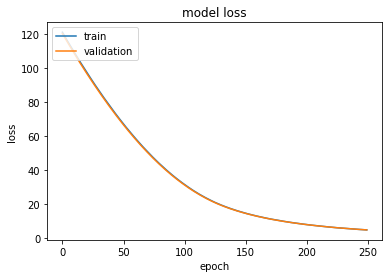

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 4.8186 - binary_accuracy: 0.9239
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 4.9505 - binary_accuracy: 0.8482
Test loss: 4.950473308563232
Test accuracy: 0.8482142686843872
[0.88300836 0.78606965]

0.8345390041436272

Confusion matrix:
[[317  42]
 [ 43 158]]

Normalized confusion matrix:
[[0.88300836 0.11699164]
 [0.21393035 0.78606965]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.88      0.88      0.88       359
     label 1       0.79      0.79      0.79       201

    accuracy                           0.85       560
   macro avg       0.84      0.83      0.83       560
weighted avg       0.85      0.85      0.85       560

AUC-ROC: 0.8345390041436272
MCC: 0.6698163745065244
precision: 0.8352777777777778
recall: 0.8345390041436272
f1_score: 0.8349050877673687
Model: "sequential_26"
_____________________________________

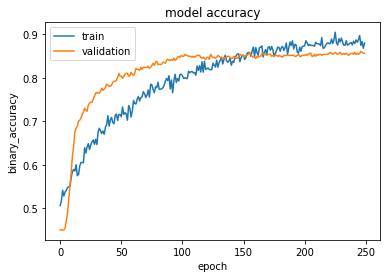

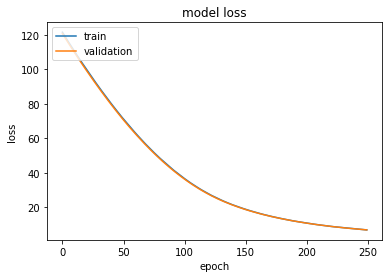

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 6.7073 - binary_accuracy: 0.9216
Test Accuracy: 
18/18 [==============================] - 0s 6ms/step - loss: 6.8759 - binary_accuracy: 0.8321
Test loss: 6.875906944274902
Test accuracy: 0.8321428298950195
[0.83286908 0.83084577]

0.8318574259621114

Confusion matrix:
[[299  60]
 [ 34 167]]

Normalized confusion matrix:
[[0.83286908 0.16713092]
 [0.16915423 0.83084577]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.90      0.83      0.86       359
     label 1       0.74      0.83      0.78       201

    accuracy                           0.83       560
   macro avg       0.82      0.83      0.82       560
weighted avg       0.84      0.83      0.83       560

AUC-ROC: 0.8318574259621115
MCC: 0.6484727688595001
precision: 0.8167903586405789
recall: 0.8318574259621114
f1_score: 0.8222678407433418
Model: "sequential_27"
_____________________________________

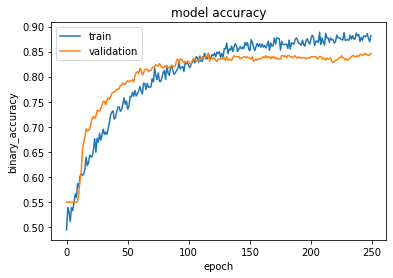

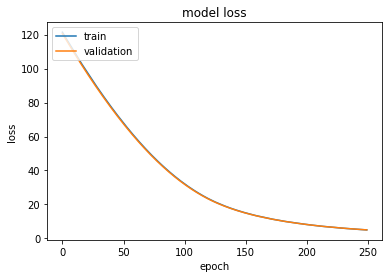

Train Accuracy: 
69/69 [==============================] - 0s 3ms/step - loss: 4.9532 - binary_accuracy: 0.9106
Test Accuracy: 
18/18 [==============================] - 0s 3ms/step - loss: 5.0667 - binary_accuracy: 0.8321
Test loss: 5.066673278808594
Test accuracy: 0.8321428298950195
[0.88857939 0.73134328]

0.8099613353843595

Confusion matrix:
[[319  40]
 [ 54 147]]

Normalized confusion matrix:
[[0.88857939 0.11142061]
 [0.26865672 0.73134328]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.86      0.89      0.87       359
     label 1       0.79      0.73      0.76       201

    accuracy                           0.83       560
   macro avg       0.82      0.81      0.81       560
weighted avg       0.83      0.83      0.83       560

AUC-ROC: 0.8099613353843597
MCC: 0.630532610500842
precision: 0.8206620693610127
recall: 0.8099613353843595
f1_score: 0.8146583291082192
Model: "sequential_28"
______________________________________

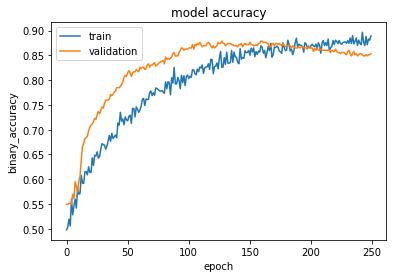

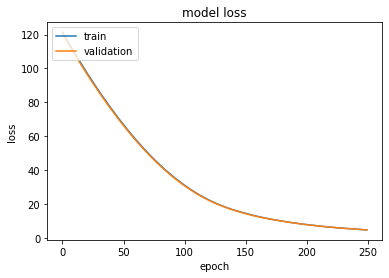

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 4.7281 - binary_accuracy: 0.9239
Test Accuracy: 
18/18 [==============================] - 0s 3ms/step - loss: 4.8696 - binary_accuracy: 0.8268
Test loss: 4.869555950164795
Test accuracy: 0.8267857432365417
[0.83008357 0.82089552]

0.8254895439238349

Confusion matrix:
[[298  61]
 [ 36 165]]

Normalized confusion matrix:
[[0.83008357 0.16991643]
 [0.17910448 0.82089552]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.89      0.83      0.86       359
     label 1       0.73      0.82      0.77       201

    accuracy                           0.83       560
   macro avg       0.81      0.83      0.82       560
weighted avg       0.83      0.83      0.83       560

AUC-ROC: 0.8254895439238349
MCC: 0.6364801114185886
precision: 0.8111520322187484
recall: 0.8254895439238349
f1_score: 0.8164312918411278
Model: "sequential_29"
_____________________________________

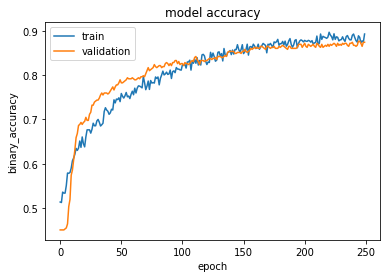

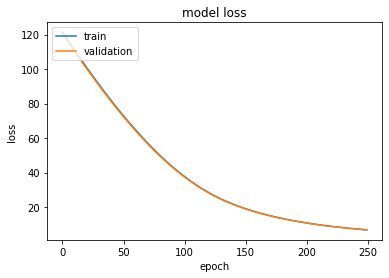

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 6.6736 - binary_accuracy: 0.9321
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 6.8557 - binary_accuracy: 0.8357
Test loss: 6.855748176574707
Test accuracy: 0.8357142806053162
[0.83008357 0.84577114]

0.8379273548691085

Confusion matrix:
[[298  61]
 [ 31 170]]

Normalized confusion matrix:
[[0.83008357 0.16991643]
 [0.15422886 0.84577114]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.91      0.83      0.87       359
     label 1       0.74      0.85      0.79       201

    accuracy                           0.84       560
   macro avg       0.82      0.84      0.83       560
weighted avg       0.84      0.84      0.84       560

AUC-ROC: 0.8379273548691085
MCC: 0.6585589535125593
precision: 0.8208529059592888
recall: 0.8379273548691085
f1_score: 0.8266580534022394


In [54]:
for i in range(0, 10):
    # train - validation split:
    X_train1, X_val1, y_train1, y_val1  = train_test_split(X_train, y_train, test_size=0.25, random_state=0)
    m = 'laser_em_batchnorm_l1_l2'
    model3 = build_model(1024)
    model_fit(model3, X_train1, y_train1, X_val1, y_val1)
    results(model3, X_train1, y_train1, X_test1, y_test1)
    i += 1

L1 regularization, also known as Lasso regularization, adds a penalty term to the loss function that is proportional to the absolute value of the weights in the model. This penalty encourages the model to use fewer features and encourages sparsity in the weights, as it tends to drive some of the weights to zero. This can help prevent overfitting and improve the model's generalization performance.

In a neural network, L1 regularization can be applied to the weights of the hidden layers and/or the output layer, depending on the specific architecture and problem at hand. It can be added to the model using the tf.keras.regularizers.l1() function, which creates a regularizer object that can be passed to the kernel_regularizer argument of the Dense layers in the model.

In [55]:
def build_model(sh):    
    # Build the model
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(sh,)),
        tf.keras.layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l1(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l1(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l1(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(8, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l1(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid),
    ])
    model.compile(loss = tf.keras.losses.BinaryCrossentropy(), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  metrics =  [tf.keras.metrics.BinaryAccuracy()])
    print(model.summary())
    return model


Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_150 (Dense)            (None, 256)               262400    
_________________________________________________________________
batch_normalization_80 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_120 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_151 (Dense)            (None, 128)               32896     
_________________________________________________________________
batch_normalization_81 (Batc (None, 128)               512       
_________________________________________________________________
dropout_121 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_152 (Dense)            (None, 32)              

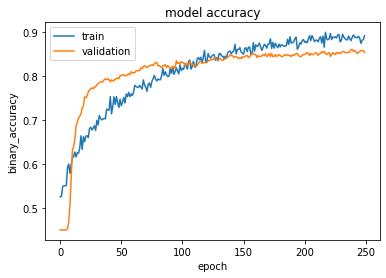

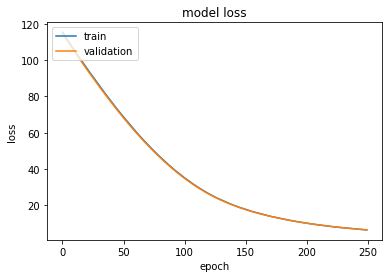

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 6.3924 - binary_accuracy: 0.9285
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 6.5532 - binary_accuracy: 0.8411
Test loss: 6.553230285644531
Test accuracy: 0.8410714268684387
[0.85236769 0.82089552]

0.8366316052051719

Confusion matrix:
[[306  53]
 [ 36 165]]

Normalized confusion matrix:
[[0.85236769 0.14763231]
 [0.17910448 0.82089552]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.89      0.85      0.87       359
     label 1       0.76      0.82      0.79       201

    accuracy                           0.84       560
   macro avg       0.83      0.84      0.83       560
weighted avg       0.85      0.84      0.84       560

AUC-ROC: 0.8366316052051719
MCC: 0.6623519768305788
precision: 0.8258087880251086
recall: 0.8366316052051719
f1_score: 0.830314007605909
Model: "sequential_31"
______________________________________

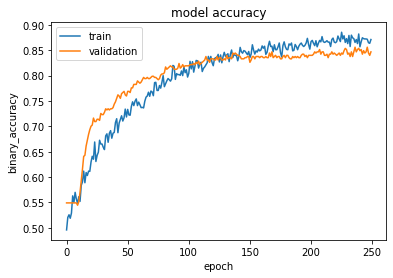

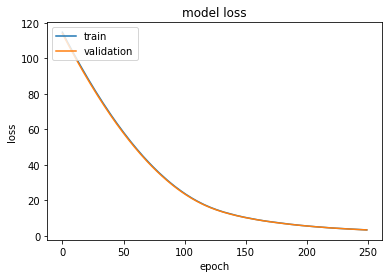

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 3.2906 - binary_accuracy: 0.9051
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 3.3992 - binary_accuracy: 0.8268
Test loss: 3.3992035388946533
Test accuracy: 0.8267857432365417
[0.8718663  0.74626866]

0.809067475990521

Confusion matrix:
[[313  46]
 [ 51 150]]

Normalized confusion matrix:
[[0.8718663  0.1281337 ]
 [0.25373134 0.74626866]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.86      0.87      0.87       359
     label 1       0.77      0.75      0.76       201

    accuracy                           0.83       560
   macro avg       0.81      0.81      0.81       560
weighted avg       0.83      0.83      0.83       560

AUC-ROC: 0.8090674759905209
MCC: 0.6216555662548606
precision: 0.8125981161695448
recall: 0.809067475990521
f1_score: 0.8107521487226119
Model: "sequential_32"
______________________________________

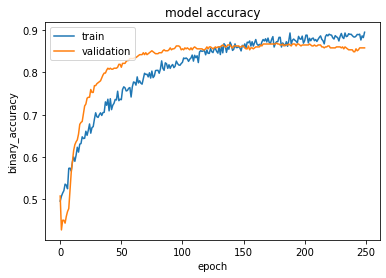

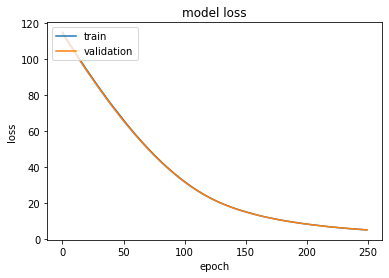

Train Accuracy: 
69/69 [==============================] - 0s 3ms/step - loss: 5.1170 - binary_accuracy: 0.9225
Test Accuracy: 
18/18 [==============================] - 0s 3ms/step - loss: 5.2731 - binary_accuracy: 0.8232
Test loss: 5.273083209991455
Test accuracy: 0.8232142925262451
[0.82729805 0.8159204 ]

0.821609224074613

Confusion matrix:
[[297  62]
 [ 37 164]]

Normalized confusion matrix:
[[0.82729805 0.17270195]
 [0.1840796  0.8159204 ]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.89      0.83      0.86       359
     label 1       0.73      0.82      0.77       201

    accuracy                           0.82       560
   macro avg       0.81      0.82      0.81       560
weighted avg       0.83      0.82      0.83       560

AUC-ROC: 0.8216092240746129
MCC: 0.6288923211006594
precision: 0.8074426368501935
recall: 0.821609224074613
f1_score: 0.8126463700234192
Model: "sequential_33"
_______________________________________

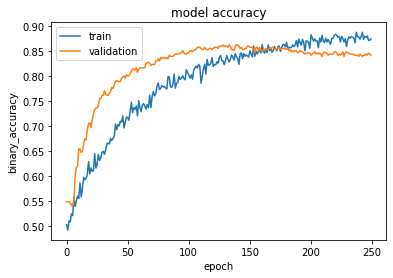

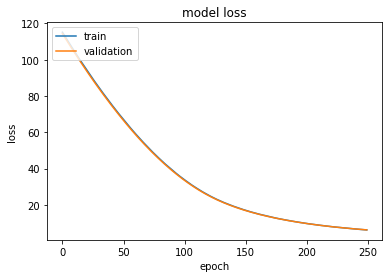

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 6.0982 - binary_accuracy: 0.9156
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 6.2338 - binary_accuracy: 0.8411
Test loss: 6.233833312988281
Test accuracy: 0.8410714268684387
[0.86072423 0.80597015]

0.8333471916185091

Confusion matrix:
[[309  50]
 [ 39 162]]

Normalized confusion matrix:
[[0.86072423 0.13927577]
 [0.19402985 0.80597015]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.89      0.86      0.87       359
     label 1       0.76      0.81      0.78       201

    accuracy                           0.84       560
   macro avg       0.83      0.83      0.83       560
weighted avg       0.84      0.84      0.84       560

AUC-ROC: 0.8333471916185091
MCC: 0.6593477019464048
precision: 0.8260409889394926
recall: 0.8333471916185091
f1_score: 0.8293098074940666
Model: "sequential_34"
_____________________________________

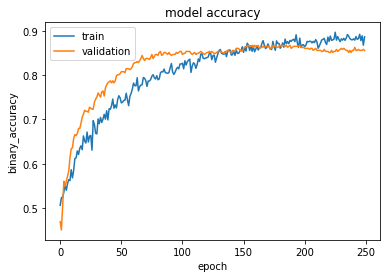

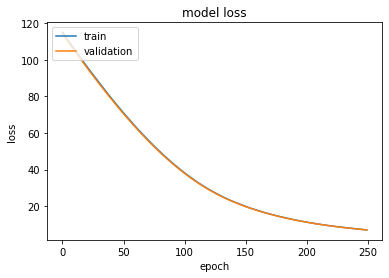

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 6.8522 - binary_accuracy: 0.9243
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 7.0082 - binary_accuracy: 0.8393
Test loss: 7.008150100708008
Test accuracy: 0.8392857313156128
[0.83008357 0.85572139]

0.842902479247218

Confusion matrix:
[[298  61]
 [ 29 172]]

Normalized confusion matrix:
[[0.83008357 0.16991643]
 [0.14427861 0.85572139]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.91      0.83      0.87       359
     label 1       0.74      0.86      0.79       201

    accuracy                           0.84       560
   macro avg       0.82      0.84      0.83       560
weighted avg       0.85      0.84      0.84       560

AUC-ROC: 0.842902479247218
MCC: 0.6674120399789375
precision: 0.824756204801092
recall: 0.842902479247218
f1_score: 0.8307156964168156
Model: "sequential_35"
_________________________________________

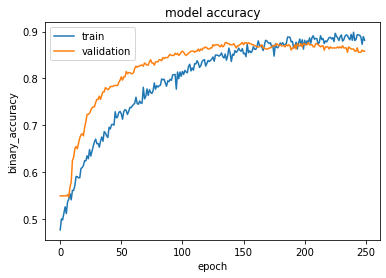

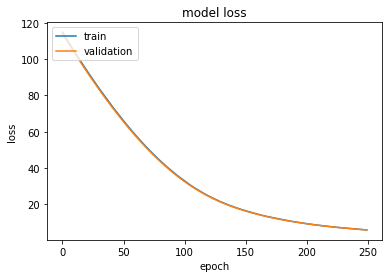

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 5.8938 - binary_accuracy: 0.9239
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 6.0538 - binary_accuracy: 0.8393
Test loss: 6.053793430328369
Test accuracy: 0.8392857313156128
[0.84958217 0.82089552]

0.8352388475450048

Confusion matrix:
[[305  54]
 [ 36 165]]

Normalized confusion matrix:
[[0.84958217 0.15041783]
 [0.17910448 0.82089552]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.89      0.85      0.87       359
     label 1       0.75      0.82      0.79       201

    accuracy                           0.84       560
   macro avg       0.82      0.84      0.83       560
weighted avg       0.84      0.84      0.84       560

AUC-ROC: 0.8352388475450048
MCC: 0.6590681746408575
precision: 0.8239264050134576
recall: 0.8352388475450048
f1_score: 0.8285714285714286
Model: "sequential_36"
_____________________________________

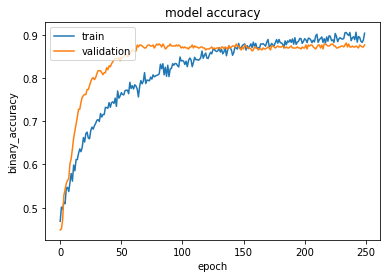

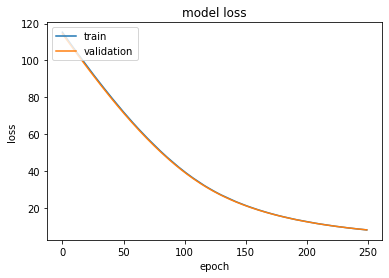

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 7.9092 - binary_accuracy: 0.9363
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 8.1347 - binary_accuracy: 0.8214
Test loss: 8.134661674499512
Test accuracy: 0.8214285969734192
[0.81337047 0.8358209 ]

0.8245956845299962

Confusion matrix:
[[292  67]
 [ 33 168]]

Normalized confusion matrix:
[[0.81337047 0.18662953]
 [0.1641791  0.8358209 ]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.90      0.81      0.85       359
     label 1       0.71      0.84      0.77       201

    accuracy                           0.82       560
   macro avg       0.81      0.82      0.81       560
weighted avg       0.83      0.82      0.82       560

AUC-ROC: 0.8245956845299962
MCC: 0.6310189166006779
precision: 0.8066775777414075
recall: 0.8245956845299962
f1_score: 0.8122216857127529
Model: "sequential_37"
_____________________________________

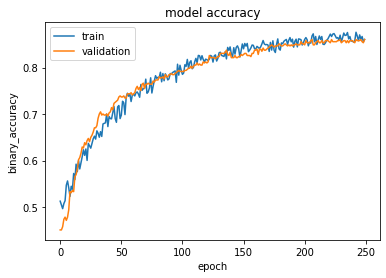

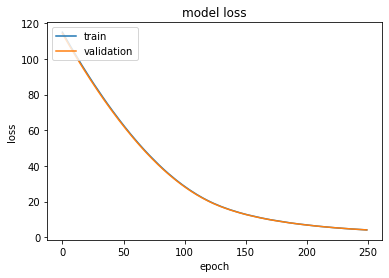

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 4.0690 - binary_accuracy: 0.9019
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 4.1821 - binary_accuracy: 0.8250
Test loss: 4.1820807456970215
Test accuracy: 0.824999988079071
[0.7994429  0.87064677]

0.8350448315525437

Confusion matrix:
[[287  72]
 [ 26 175]]

Normalized confusion matrix:
[[0.7994429  0.2005571 ]
 [0.12935323 0.87064677]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.92      0.80      0.85       359
     label 1       0.71      0.87      0.78       201

    accuracy                           0.82       560
   macro avg       0.81      0.84      0.82       560
weighted avg       0.84      0.82      0.83       560

AUC-ROC: 0.8350448315525436
MCC: 0.6473773881103875
precision: 0.8127174658198704
recall: 0.8350448315525437
f1_score: 0.8177083333333335
Model: "sequential_38"
_____________________________________

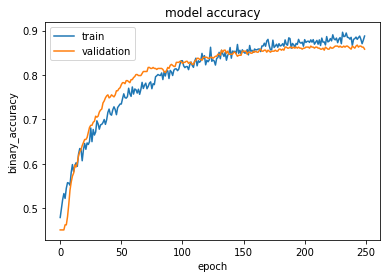

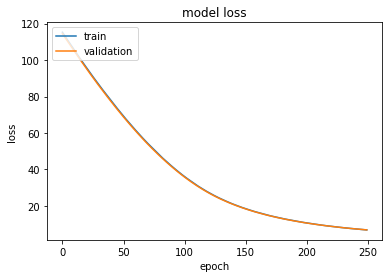

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 6.7606 - binary_accuracy: 0.9276
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 6.9236 - binary_accuracy: 0.8375
Test loss: 6.923637390136719
Test accuracy: 0.8374999761581421
[0.83286908 0.84577114]

0.8393201125292756

Confusion matrix:
[[299  60]
 [ 31 170]]

Normalized confusion matrix:
[[0.83286908 0.16713092]
 [0.15422886 0.84577114]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.91      0.83      0.87       359
     label 1       0.74      0.85      0.79       201

    accuracy                           0.84       560
   macro avg       0.82      0.84      0.83       560
weighted avg       0.85      0.84      0.84       560

AUC-ROC: 0.8393201125292755
MCC: 0.6617043094642804
precision: 0.8225955204216073
recall: 0.8393201125292756
f1_score: 0.8283938186753053
Model: "sequential_39"
_____________________________________

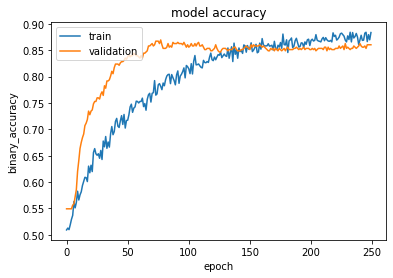

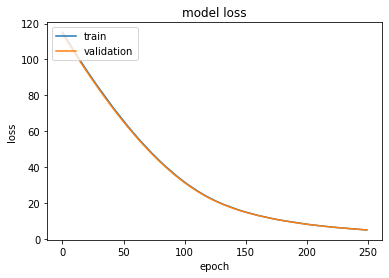

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 4.8684 - binary_accuracy: 0.9147
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 4.9838 - binary_accuracy: 0.8464
Test loss: 4.983790397644043
Test accuracy: 0.8464285731315613
[0.86072423 0.82089552]

0.8408098781856733

Confusion matrix:
[[309  50]
 [ 36 165]]

Normalized confusion matrix:
[[0.86072423 0.13927577]
 [0.17910448 0.82089552]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.90      0.86      0.88       359
     label 1       0.77      0.82      0.79       201

    accuracy                           0.85       560
   macro avg       0.83      0.84      0.84       560
weighted avg       0.85      0.85      0.85       560

AUC-ROC: 0.8408098781856733
MCC: 0.6722930865062755
precision: 0.83154701718908
recall: 0.8408098781856733
f1_score: 0.83555506993007


In [56]:
for i in range(0, 10):
    # train - validation split:
    X_train1, X_val1, y_train1, y_val1  = train_test_split(X_train, y_train, test_size=0.25, random_state=0)
    m = 'laser_em_batchnorm_l1'
    model4 = build_model(1024)
    model_fit(model4, X_train1, y_train1, X_val1, y_val1)
    results(model4, X_train1, y_train1, X_test1, y_test1)
    i += 1

**Conclusion on regularizers**
From the metrics you provided, it seems like all three models have similar accuracy and performance on the test data. However, there are some slight differences in the other metrics.

The model that uses L2 regularization has the highest precision and recall for label 0, which means it does a better job of correctly identifying negative cases. This model also has the highest overall F1-score, indicating that it has a better balance of precision and recall than the other models.

The model that uses L1 regularization has the highest precision and recall for label 1, which means it does a better job of correctly identifying positive cases. However, this model has the lowest overall F1-score, indicating that it may be biased towards identifying positive cases at the expense of identifying negative cases.

The model that uses both L1 and L2 regularization has similar metrics to the L2 regularization model, but with slightly lower precision and recall for label 0.

Overall, it seems like the model that uses L2 regularization performs the best based on the metrics provided. However, it's important to note that these metrics are just one way of evaluating model performance, and it's possible that other metrics or real-world performance could favor a different model.

In [57]:
def build_model(sh):    
    # Build the model
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(sh,)),
        tf.keras.layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(8, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid),
    ])
    model.compile(loss = tf.keras.losses.BinaryCrossentropy(), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  metrics =  [ tf.keras.metrics.BinaryAccuracy() ])
    print(model.summary())
    return model

In [58]:
# drop columns to concat u2v part
X_train2 = result_train
X_test2 = result_test
X_train2 = X_train2.drop(['author_id', 'full_text_clean', 'label'], axis=1)
u2v_train = X_train2.to_numpy()
print('u2v em shape: ', u2v_train.shape)
X_test2 = X_test2.drop(['author_id', 'full_text_clean', 'label'], axis=1)
u2v_test = X_test2.to_numpy()
print('u2v em shape: ', u2v_test.shape)
# concatenate the arrays along the second axis
c_train = np.concatenate((X_train, u2v_train), axis=1)
c_test = np.concatenate((X_test1, u2v_test), axis=1)

u2v em shape:  (2908, 768)
u2v em shape:  (560, 768)


Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_200 (Dense)            (None, 256)               459008    
_________________________________________________________________
batch_normalization_120 (Bat (None, 256)               1024      
_________________________________________________________________
dropout_160 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_201 (Dense)            (None, 128)               32896     
_________________________________________________________________
batch_normalization_121 (Bat (None, 128)               512       
_________________________________________________________________
dropout_161 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_202 (Dense)            (None, 32)              

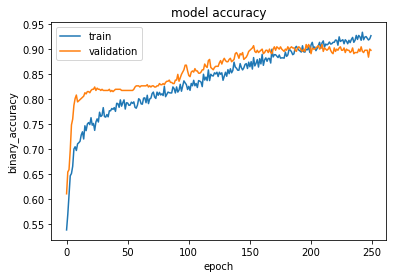

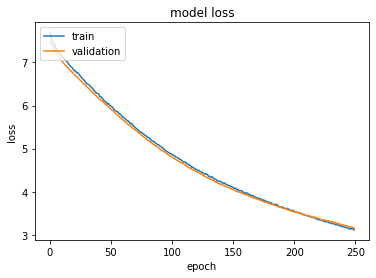

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 3.0414 - binary_accuracy: 0.9523
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 3.3753 - binary_accuracy: 0.8500
Test loss: 3.375336170196533
Test accuracy: 0.8500000238418579
[0.87465181 0.80597015]

0.8403109799193448

Confusion matrix:
[[314  45]
 [ 39 162]]

Normalized confusion matrix:
[[0.87465181 0.12534819]
 [0.19402985 0.80597015]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.89      0.87      0.88       359
     label 1       0.78      0.81      0.79       201

    accuracy                           0.85       560
   macro avg       0.84      0.84      0.84       560
weighted avg       0.85      0.85      0.85       560

AUC-ROC: 0.8403109799193448
MCC: 0.6763611981466597
precision: 0.8360635546249539
recall: 0.8403109799193448
f1_score: 0.838070059484468
Model: "sequential_41"
______________________________________

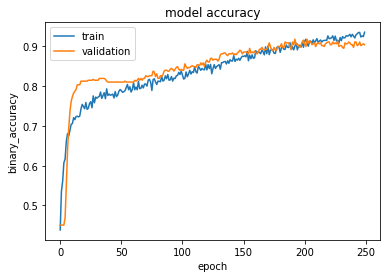

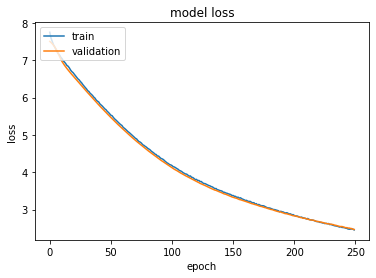

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.3899 - binary_accuracy: 0.9532
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 2.6555 - binary_accuracy: 0.8500
Test loss: 2.655547618865967
Test accuracy: 0.8500000238418579
[0.88300836 0.79104478]

0.8370265663326819

Confusion matrix:
[[317  42]
 [ 42 159]]

Normalized confusion matrix:
[[0.88300836 0.11699164]
 [0.20895522 0.79104478]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.88      0.88      0.88       359
     label 1       0.79      0.79      0.79       201

    accuracy                           0.85       560
   macro avg       0.84      0.84      0.84       560
weighted avg       0.85      0.85      0.85       560

AUC-ROC: 0.8370265663326819
MCC: 0.674053132665364
precision: 0.8370265663326819
recall: 0.8370265663326819
f1_score: 0.8370265663326819
Model: "sequential_42"
______________________________________

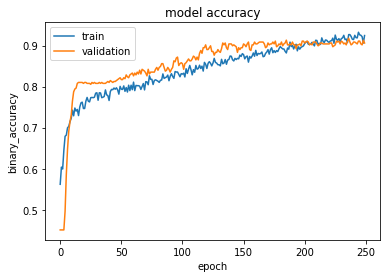

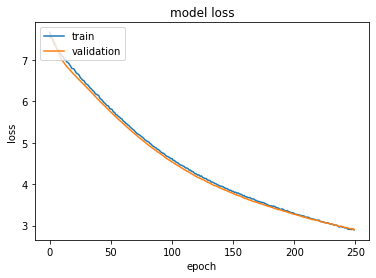

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.8186 - binary_accuracy: 0.9528
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 3.0736 - binary_accuracy: 0.8339
Test loss: 3.073612928390503
Test accuracy: 0.8339285850524902
[0.84679666 0.81094527]

0.8288709655067281

Confusion matrix:
[[304  55]
 [ 38 163]]

Normalized confusion matrix:
[[0.84679666 0.15320334]
 [0.18905473 0.81094527]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.89      0.85      0.87       359
     label 1       0.75      0.81      0.78       201

    accuracy                           0.83       560
   macro avg       0.82      0.83      0.82       560
weighted avg       0.84      0.83      0.84       560

AUC-ROC: 0.8288709655067281
MCC: 0.6470822428951655
precision: 0.8182976554536188
recall: 0.8288709655067281
f1_score: 0.8226876708690959
Model: "sequential_43"
_____________________________________

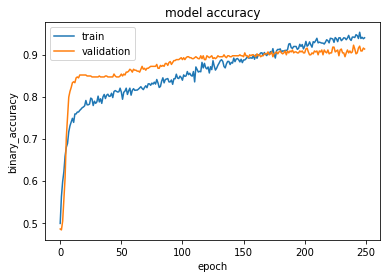

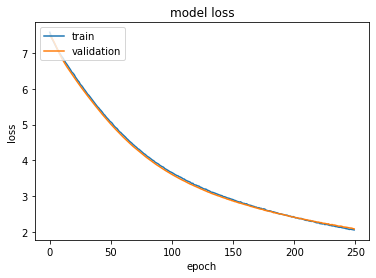

Train Accuracy: 
69/69 [==============================] - 0s 4ms/step - loss: 1.9890 - binary_accuracy: 0.9642
Test Accuracy: 
18/18 [==============================] - 0s 3ms/step - loss: 2.2355 - binary_accuracy: 0.8482
Test loss: 2.235549211502075
Test accuracy: 0.8482142686843872
[0.88300836 0.78606965]

0.8345390041436272

Confusion matrix:
[[317  42]
 [ 43 158]]

Normalized confusion matrix:
[[0.88300836 0.11699164]
 [0.21393035 0.78606965]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.88      0.88      0.88       359
     label 1       0.79      0.79      0.79       201

    accuracy                           0.85       560
   macro avg       0.84      0.83      0.83       560
weighted avg       0.85      0.85      0.85       560

AUC-ROC: 0.8345390041436272
MCC: 0.6698163745065244
precision: 0.8352777777777778
recall: 0.8345390041436272
f1_score: 0.8349050877673687
Model: "sequential_44"
_____________________________________

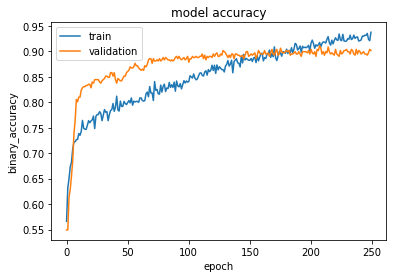

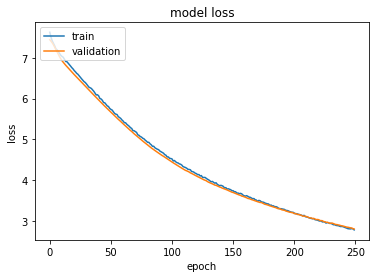

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.7117 - binary_accuracy: 0.9578
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 2.9339 - binary_accuracy: 0.8554
Test loss: 2.9339303970336914
Test accuracy: 0.8553571701049805
[0.88579387 0.80099502]

0.8433944483709586

Confusion matrix:
[[318  41]
 [ 40 161]]

Normalized confusion matrix:
[[0.88579387 0.11420613]
 [0.19900498 0.80099502]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.89      0.89      0.89       359
     label 1       0.80      0.80      0.80       201

    accuracy                           0.86       560
   macro avg       0.84      0.84      0.84       560
weighted avg       0.86      0.86      0.86       560

AUC-ROC: 0.8433944483709586
MCC: 0.6860429729932417
precision: 0.8426489296974391
recall: 0.8433944483709586
f1_score: 0.8430183664358317
Model: "sequential_45"
____________________________________

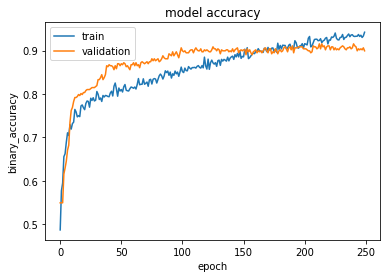

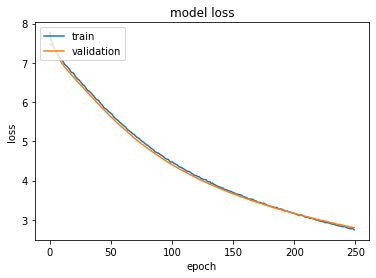

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.6833 - binary_accuracy: 0.9606
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 2.9949 - binary_accuracy: 0.8464
Test loss: 2.9948501586914062
Test accuracy: 0.8464285731315613
[0.88857939 0.77114428]

0.8298618328967974

Confusion matrix:
[[319  40]
 [ 46 155]]

Normalized confusion matrix:
[[0.88857939 0.11142061]
 [0.22885572 0.77114428]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.87      0.89      0.88       359
     label 1       0.79      0.77      0.78       201

    accuracy                           0.85       560
   macro avg       0.83      0.83      0.83       560
weighted avg       0.85      0.85      0.85       560

AUC-ROC: 0.8298618328967973
MCC: 0.6642683778698044
precision: 0.8344221988057604
recall: 0.8298618328967974
f1_score: 0.8320218762207713
Model: "sequential_46"
____________________________________

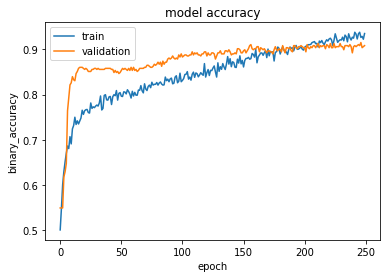

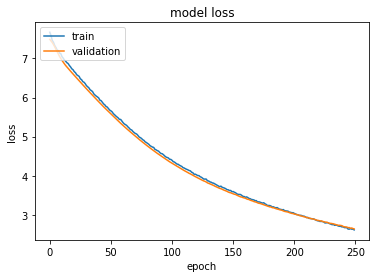

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.5460 - binary_accuracy: 0.9574
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 2.8042 - binary_accuracy: 0.8429
Test loss: 2.8041698932647705
Test accuracy: 0.8428571224212646
[0.88022284 0.7761194 ]

0.8281711221053507

Confusion matrix:
[[316  43]
 [ 45 156]]

Normalized confusion matrix:
[[0.88022284 0.11977716]
 [0.2238806  0.7761194 ]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.88      0.88      0.88       359
     label 1       0.78      0.78      0.78       201

    accuracy                           0.84       560
   macro avg       0.83      0.83      0.83       560
weighted avg       0.84      0.84      0.84       560

AUC-ROC: 0.8281711221053507
MCC: 0.6578024270395741
precision: 0.8296329291888807
recall: 0.8281711221053507
f1_score: 0.8288888888888889
Model: "sequential_47"
____________________________________

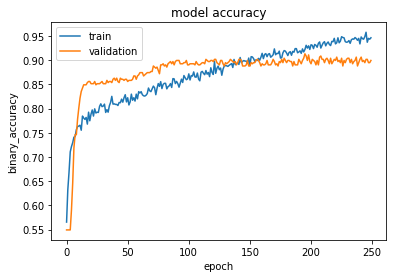

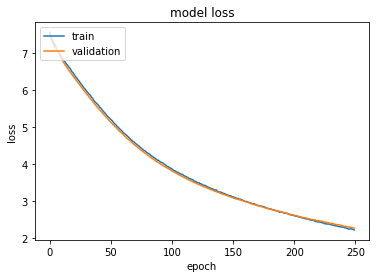

Train Accuracy: 
69/69 [==============================] - 0s 3ms/step - loss: 2.1597 - binary_accuracy: 0.9688
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 2.4528 - binary_accuracy: 0.8500
Test loss: 2.452772855758667
Test accuracy: 0.8500000238418579
[0.88022284 0.7960199 ]

0.8381213708615696

Confusion matrix:
[[316  43]
 [ 41 160]]

Normalized confusion matrix:
[[0.88022284 0.11977716]
 [0.2039801  0.7960199 ]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.89      0.88      0.88       359
     label 1       0.79      0.80      0.79       201

    accuracy                           0.85       560
   macro avg       0.84      0.84      0.84       560
weighted avg       0.85      0.85      0.85       560

AUC-ROC: 0.8381213708615696
MCC: 0.6747855015160836
precision: 0.8366657007630638
recall: 0.8381213708615696
f1_score: 0.8373803860833011
Model: "sequential_48"
_____________________________________

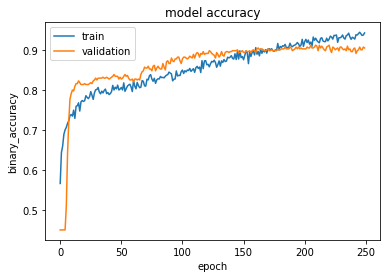

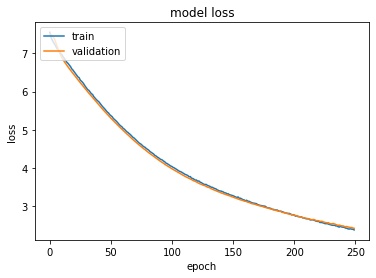

Train Accuracy: 
69/69 [==============================] - 0s 3ms/step - loss: 2.3193 - binary_accuracy: 0.9624
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 2.6066 - binary_accuracy: 0.8518
Test loss: 2.606644630432129
Test accuracy: 0.8517857193946838
[0.87743733 0.80597015]

0.8417037375795119

Confusion matrix:
[[315  44]
 [ 39 162]]

Normalized confusion matrix:
[[0.87743733 0.12256267]
 [0.19402985 0.80597015]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.89      0.88      0.88       359
     label 1       0.79      0.81      0.80       201

    accuracy                           0.85       560
   macro avg       0.84      0.84      0.84       560
weighted avg       0.85      0.85      0.85       560

AUC-ROC: 0.8417037375795119
MCC: 0.6798134247286807
precision: 0.8381191377324337
recall: 0.8417037375795119
f1_score: 0.8398296294509477
Model: "sequential_49"
_____________________________________

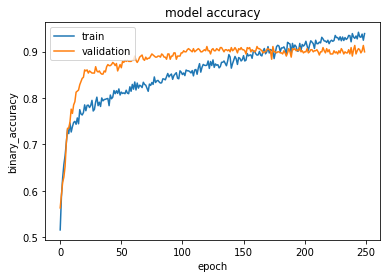

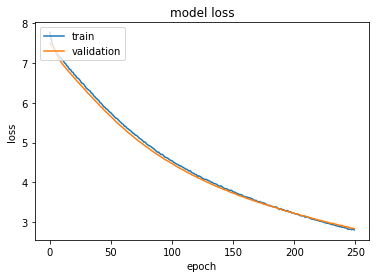

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.7231 - binary_accuracy: 0.9597
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 3.0177 - binary_accuracy: 0.8464
Test loss: 3.017712116241455
Test accuracy: 0.8464285731315613
[0.88579387 0.7761194 ]

0.8309566374256849

Confusion matrix:
[[318  41]
 [ 45 156]]

Normalized confusion matrix:
[[0.88579387 0.11420613]
 [0.2238806  0.7761194 ]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.88      0.89      0.88       359
     label 1       0.79      0.78      0.78       201

    accuracy                           0.85       560
   macro avg       0.83      0.83      0.83       560
weighted avg       0.85      0.85      0.85       560

AUC-ROC: 0.8309566374256849
MCC: 0.6649054894122894
precision: 0.833955615220036
recall: 0.8309566374256849
f1_score: 0.8324030122913737


In [59]:
for i in range(0, 10):
    # train - validation split:
    X_train1, X_val1, y_train1, y_val1  = train_test_split(c_train, y_train, test_size=0.25, random_state=0)
    m = 'laser_em_batchnorm_l2_u2v'
    i += 1
    model5 = build_model(c_test.shape[1])
    model_fit(model5, X_train1, y_train1, X_val1, y_val1)
    results(model5, X_train1, y_train1, c_test, y_test1)

> **train and test the model with laser embeddings concatenated with user embeddings**

* Normalize the vectors:
Normalize the data: Scaling the data to a common range can help the optimizer converge faster and can improve the performance of the model. StandardScaler is a good choice for normalizing the data.

In [60]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [61]:
scaled_vectors_train = scaler.fit_transform(c_train)
scaled_vectors_test = scaler.transform(c_test)
    
print()
print(scaled_vectors_train.shape)
print(scaled_vectors_test.shape)
print()


(2908, 1792)
(560, 1792)



Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_250 (Dense)            (None, 256)               459008    
_________________________________________________________________
batch_normalization_160 (Bat (None, 256)               1024      
_________________________________________________________________
dropout_200 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_251 (Dense)            (None, 128)               32896     
_________________________________________________________________
batch_normalization_161 (Bat (None, 128)               512       
_________________________________________________________________
dropout_201 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_252 (Dense)            (None, 32)              

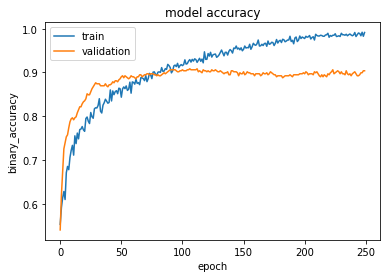

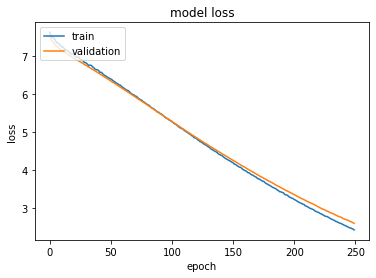

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.4190 - binary_accuracy: 0.9803
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 2.6830 - binary_accuracy: 0.8661
Test loss: 2.6829755306243896
Test accuracy: 0.8660714030265808
[0.90807799 0.79104478]

0.8495613852741861

Confusion matrix:
[[326  33]
 [ 42 159]]

Normalized confusion matrix:
[[0.90807799 0.09192201]
 [0.20895522 0.79104478]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.89      0.91      0.90       359
     label 1       0.83      0.79      0.81       201

    accuracy                           0.87       560
   macro avg       0.86      0.85      0.85       560
weighted avg       0.87      0.87      0.87       560

AUC-ROC: 0.8495613852741861
MCC: 0.7065195387186848
precision: 0.8569972826086957
recall: 0.8495613852741861
f1_score: 0.8529983094805591
Model: "sequential_51"
____________________________________

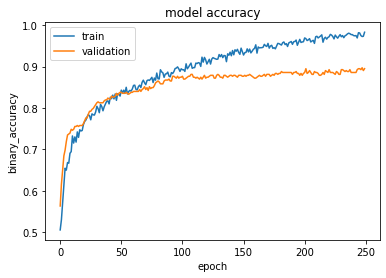

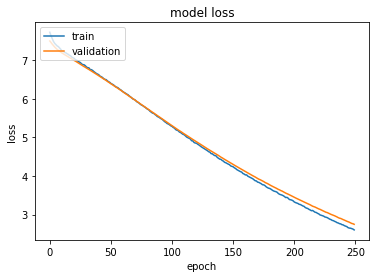

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.5719 - binary_accuracy: 0.9780
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 2.8542 - binary_accuracy: 0.8411
Test loss: 2.8542091846466064
Test accuracy: 0.8410714268684387
[0.83844011 0.84577114]

0.84210562784961

Confusion matrix:
[[301  58]
 [ 31 170]]

Normalized confusion matrix:
[[0.83844011 0.16155989]
 [0.15422886 0.84577114]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.91      0.84      0.87       359
     label 1       0.75      0.85      0.79       201

    accuracy                           0.84       560
   macro avg       0.83      0.84      0.83       560
weighted avg       0.85      0.84      0.84       560

AUC-ROC: 0.8421056278496099
MCC: 0.6680346694985627
precision: 0.8261202705559079
recall: 0.84210562784961
f1_score: 0.8318709751415975
Model: "sequential_52"
________________________________________

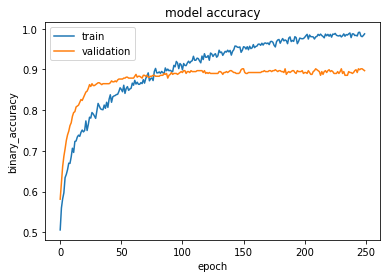

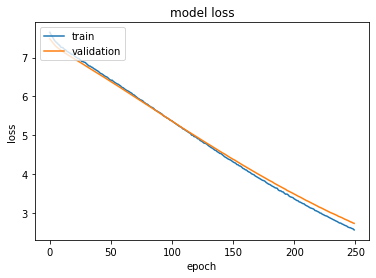

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.5444 - binary_accuracy: 0.9785
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 2.8232 - binary_accuracy: 0.8589
Test loss: 2.823188066482544
Test accuracy: 0.8589285612106323
[0.89415042 0.7960199 ]

0.8450851591624053

Confusion matrix:
[[321  38]
 [ 41 160]]

Normalized confusion matrix:
[[0.89415042 0.10584958]
 [0.2039801  0.7960199 ]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.89      0.89      0.89       359
     label 1       0.81      0.80      0.80       201

    accuracy                           0.86       560
   macro avg       0.85      0.85      0.85       560
weighted avg       0.86      0.86      0.86       560

AUC-ROC: 0.8450851591624052
MCC: 0.6924918245564883
precision: 0.8474105697862604
recall: 0.8450851591624053
f1_score: 0.8462174854612259
Model: "sequential_53"
_____________________________________

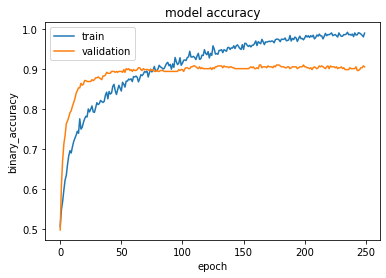

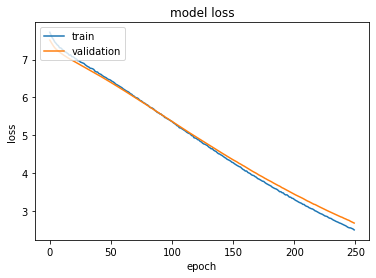

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.4896 - binary_accuracy: 0.9807
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 2.7429 - binary_accuracy: 0.8643
Test loss: 2.74288010597229
Test accuracy: 0.8642857074737549
[0.90529248 0.79104478]

0.848168627614019

Confusion matrix:
[[325  34]
 [ 42 159]]

Normalized confusion matrix:
[[0.90529248 0.09470752]
 [0.20895522 0.79104478]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.89      0.91      0.90       359
     label 1       0.82      0.79      0.81       201

    accuracy                           0.86       560
   macro avg       0.85      0.85      0.85       560
weighted avg       0.86      0.86      0.86       560

AUC-ROC: 0.848168627614019
MCC: 0.7028347041104458
precision: 0.8546963899987294
recall: 0.848168627614019
f1_score: 0.8512117016962425
Model: "sequential_54"
_________________________________________

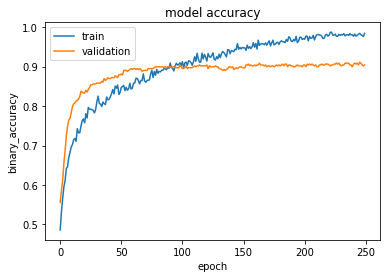

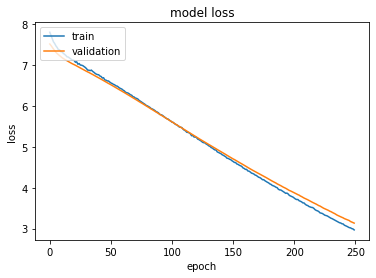

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.9487 - binary_accuracy: 0.9803
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 3.2404 - binary_accuracy: 0.8429
Test loss: 3.2404136657714844
Test accuracy: 0.8428571224212646
[0.86629526 0.80099502]

0.8336451447497887

Confusion matrix:
[[311  48]
 [ 40 161]]

Normalized confusion matrix:
[[0.86629526 0.13370474]
 [0.19900498 0.80099502]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.89      0.87      0.88       359
     label 1       0.77      0.80      0.79       201

    accuracy                           0.84       560
   macro avg       0.83      0.83      0.83       560
weighted avg       0.84      0.84      0.84       560

AUC-ROC: 0.8336451447497888
MCC: 0.6618100481514012
precision: 0.8281874071347756
recall: 0.8336451447497887
f1_score: 0.8307110958433528
Model: "sequential_55"
____________________________________

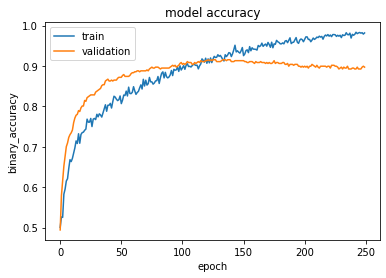

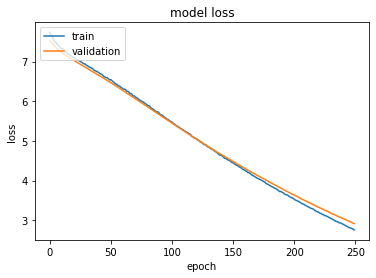

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.7376 - binary_accuracy: 0.9785
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 2.9992 - binary_accuracy: 0.8571
Test loss: 2.999159336090088
Test accuracy: 0.8571428656578064
[0.89693593 0.78606965]

0.8415027924444629

Confusion matrix:
[[322  37]
 [ 43 158]]

Normalized confusion matrix:
[[0.89693593 0.10306407]
 [0.21393035 0.78606965]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.88      0.90      0.89       359
     label 1       0.81      0.79      0.80       201

    accuracy                           0.86       560
   macro avg       0.85      0.84      0.84       560
weighted avg       0.86      0.86      0.86       560

AUC-ROC: 0.8415027924444629
MCC: 0.6877106817206872
precision: 0.846224095539164
recall: 0.8415027924444629
f1_score: 0.8437412802053686
Model: "sequential_56"
______________________________________

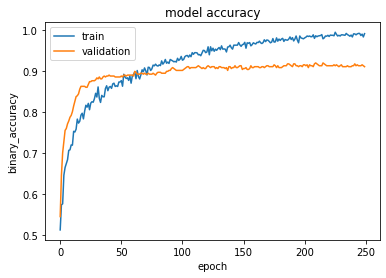

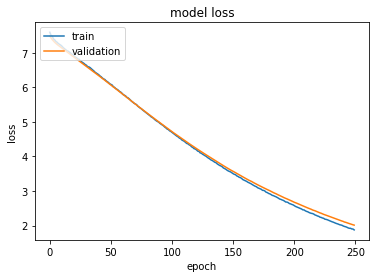

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 1.8619 - binary_accuracy: 0.9817
Test Accuracy: 
18/18 [==============================] - 0s 3ms/step - loss: 2.0761 - binary_accuracy: 0.8714
Test loss: 2.0761191844940186
Test accuracy: 0.8714285492897034
[0.88300836 0.85074627]

0.8668773126013387

Confusion matrix:
[[317  42]
 [ 30 171]]

Normalized confusion matrix:
[[0.88300836 0.11699164]
 [0.14925373 0.85074627]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.91      0.88      0.90       359
     label 1       0.80      0.85      0.83       201

    accuracy                           0.87       560
   macro avg       0.86      0.87      0.86       560
weighted avg       0.87      0.87      0.87       560

AUC-ROC: 0.8668773126013387
MCC: 0.7250059415634268
precision: 0.8581807849981735
recall: 0.8668773126013387
f1_score: 0.862051976844439
Model: "sequential_57"
_____________________________________

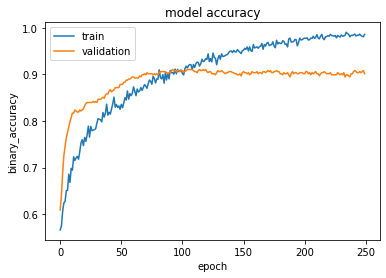

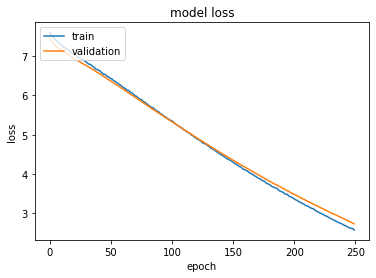

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.5486 - binary_accuracy: 0.9798
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 2.8511 - binary_accuracy: 0.8393
Test loss: 2.85109281539917
Test accuracy: 0.8392857313156128
[0.88022284 0.76616915]

0.8231959977272412

Confusion matrix:
[[316  43]
 [ 47 154]]

Normalized confusion matrix:
[[0.88022284 0.11977716]
 [0.23383085 0.76616915]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.87      0.88      0.88       359
     label 1       0.78      0.77      0.77       201

    accuracy                           0.84       560
   macro avg       0.83      0.82      0.82       560
weighted avg       0.84      0.84      0.84       560

AUC-ROC: 0.8231959977272413
MCC: 0.6493140452370542
precision: 0.8261246521514173
recall: 0.8231959977272412
f1_score: 0.82460780356074
Model: "sequential_58"
________________________________________

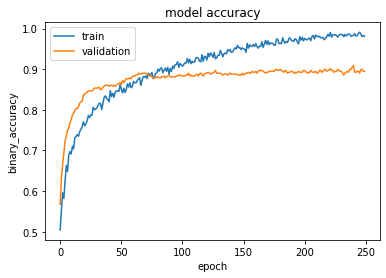

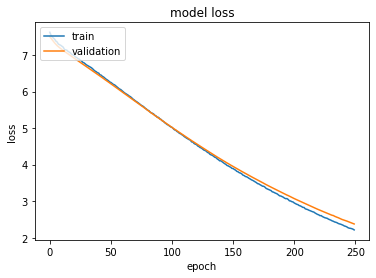

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.1965 - binary_accuracy: 0.9785
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 2.4402 - binary_accuracy: 0.8714
Test loss: 2.4401636123657227
Test accuracy: 0.8714285492897034
[0.88022284 0.85572139]

0.8679721171302264

Confusion matrix:
[[316  43]
 [ 29 172]]

Normalized confusion matrix:
[[0.88022284 0.11977716]
 [0.14427861 0.85572139]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.92      0.88      0.90       359
     label 1       0.80      0.86      0.83       201

    accuracy                           0.87       560
   macro avg       0.86      0.87      0.86       560
weighted avg       0.87      0.87      0.87       560

AUC-ROC: 0.8679721171302264
MCC: 0.7258742372454156
precision: 0.8579710144927537
recall: 0.8679721171302264
f1_score: 0.8623251748251749
Model: "sequential_59"
____________________________________

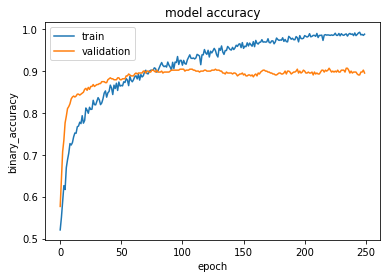

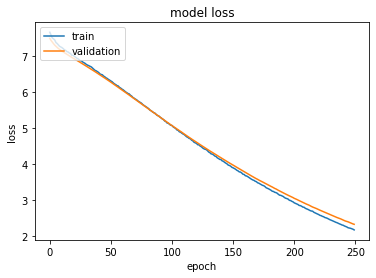

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.1490 - binary_accuracy: 0.9785
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 2.4028 - binary_accuracy: 0.8518
Test loss: 2.40279221534729
Test accuracy: 0.8517857193946838
[0.88022284 0.80099502]

0.8406089330506243

Confusion matrix:
[[316  43]
 [ 40 161]]

Normalized confusion matrix:
[[0.88022284 0.11977716]
 [0.19900498 0.80099502]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.89      0.88      0.88       359
     label 1       0.79      0.80      0.80       201

    accuracy                           0.85       560
   macro avg       0.84      0.84      0.84       560
weighted avg       0.85      0.85      0.85       560

AUC-ROC: 0.8406089330506243
MCC: 0.6790334987522713
precision: 0.838428067856356
recall: 0.8406089330506243
f1_score: 0.8394889061555728


In [62]:
for i in range(0, 10):
    # train - validation split:
    X_train1, X_val1, y_train1, y_val1  = train_test_split(scaled_vectors_train, y_train , test_size=0.25, random_state=0)
    m = 'laser_em_batchnorm_l2_u2v_scaled'
    i += 1
    model6 = build_model(1792)
    model_fit(model6, X_train1, y_train1 , X_val1, y_val1)
    results(model6, X_train1, y_train1, scaled_vectors_test, y_test1)

normalize vectors separately before concatenationg 

In [63]:
X_train= X_train.astype(np.float64)
X_test1 = X_test1.astype(np.float64)
    
scaler = StandardScaler()
x_vectors_train = scaler.fit_transform(X_train)
x_vectors_test = scaler.transform(X_test1)

w_vectors_train = scaler.fit_transform(u2v_train)
w_vectors_test = scaler.transform(u2v_test)

# concatenate the arrays along the second axis
c1_test = np.concatenate((x_vectors_test, w_vectors_test), axis=1)
# print the shape of the concatenated array
print(c1_test.shape)

# concatenate the arrays along the second axis
c1_train = np.concatenate((x_vectors_train, w_vectors_train), axis=1)
# print the shape of the concatenated array
print(c1_train.shape)


(560, 1792)
(2908, 1792)


Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_300 (Dense)            (None, 256)               459008    
_________________________________________________________________
batch_normalization_200 (Bat (None, 256)               1024      
_________________________________________________________________
dropout_240 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_301 (Dense)            (None, 128)               32896     
_________________________________________________________________
batch_normalization_201 (Bat (None, 128)               512       
_________________________________________________________________
dropout_241 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_302 (Dense)            (None, 32)              

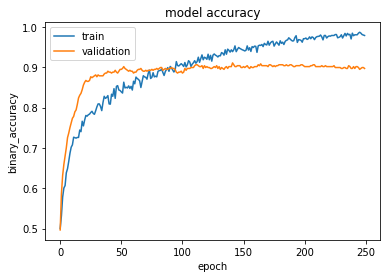

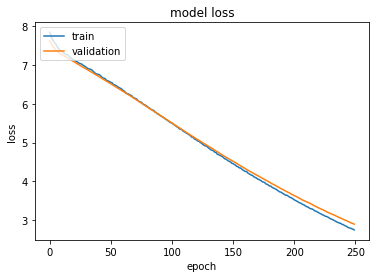

Train Accuracy: 
69/69 [==============================] - 0s 4ms/step - loss: 2.7292 - binary_accuracy: 0.9789
Test Accuracy: 
18/18 [==============================] - 0s 3ms/step - loss: 3.0214 - binary_accuracy: 0.8482
Test loss: 3.0213706493377686
Test accuracy: 0.8482142686843872
[0.8718663  0.80597015]

0.8389182222591777

Confusion matrix:
[[313  46]
 [ 39 162]]

Normalized confusion matrix:
[[0.8718663  0.1281337 ]
 [0.19402985 0.80597015]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.89      0.87      0.88       359
     label 1       0.78      0.81      0.79       201

    accuracy                           0.85       560
   macro avg       0.83      0.84      0.84       560
weighted avg       0.85      0.85      0.85       560

AUC-ROC: 0.8389182222591776
MCC: 0.6729257839999794
precision: 0.8340253496503496
recall: 0.8389182222591777
f1_score: 0.8363130547216462
Model: "sequential_61"
____________________________________

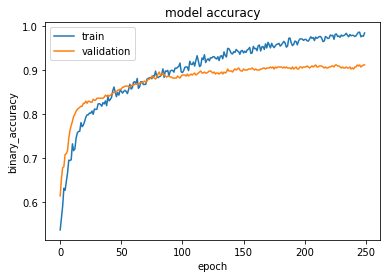

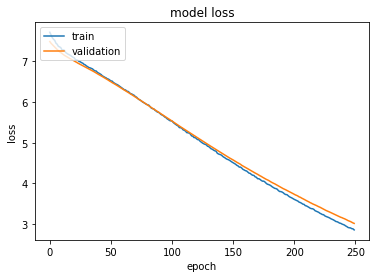

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.8330 - binary_accuracy: 0.9821
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 3.1228 - binary_accuracy: 0.8518
Test loss: 3.122814893722534
Test accuracy: 0.8517857193946838
[0.85793872 0.84079602]

0.8493673692817251

Confusion matrix:
[[308  51]
 [ 32 169]]

Normalized confusion matrix:
[[0.85793872 0.14206128]
 [0.15920398 0.84079602]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.91      0.86      0.88       359
     label 1       0.77      0.84      0.80       201

    accuracy                           0.85       560
   macro avg       0.84      0.85      0.84       560
weighted avg       0.86      0.85      0.85       560

AUC-ROC: 0.849367369281725
MCC: 0.6862886072088143
precision: 0.8370320855614973
recall: 0.8493673692817251
f1_score: 0.8420546488196574
Model: "sequential_62"
______________________________________

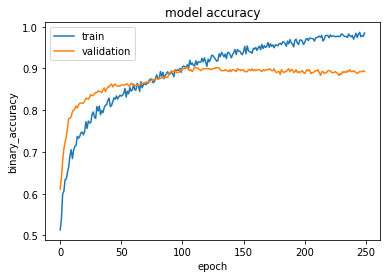

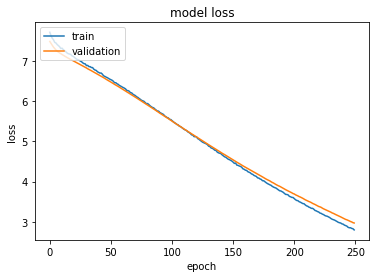

Train Accuracy: 
69/69 [==============================] - 0s 3ms/step - loss: 2.7763 - binary_accuracy: 0.9780
Test Accuracy: 
18/18 [==============================] - 0s 3ms/step - loss: 3.0529 - binary_accuracy: 0.8554
Test loss: 3.0529325008392334
Test accuracy: 0.8553571701049805
[0.86629526 0.8358209 ]

0.8510580800731717

Confusion matrix:
[[311  48]
 [ 33 168]]

Normalized confusion matrix:
[[0.86629526 0.13370474]
 [0.1641791  0.8358209 ]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.90      0.87      0.88       359
     label 1       0.78      0.84      0.81       201

    accuracy                           0.86       560
   macro avg       0.84      0.85      0.85       560
weighted avg       0.86      0.86      0.86       560

AUC-ROC: 0.8510580800731717
MCC: 0.6919076385290327
precision: 0.8409237726098191
recall: 0.8510580800731717
f1_score: 0.8452674560209585
Model: "sequential_63"
____________________________________

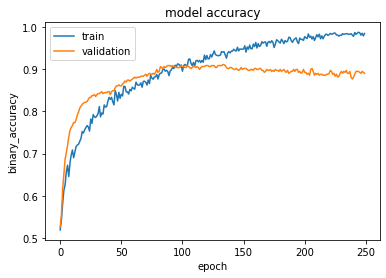

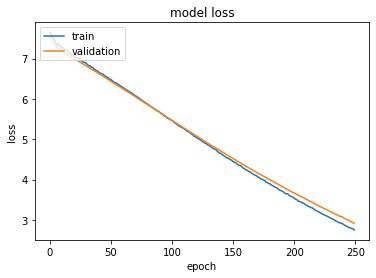

Train Accuracy: 
69/69 [==============================] - 0s 5ms/step - loss: 2.7372 - binary_accuracy: 0.9780
Test Accuracy: 
18/18 [==============================] - 0s 4ms/step - loss: 3.0341 - binary_accuracy: 0.8518
Test loss: 3.0340888500213623
Test accuracy: 0.8517857193946838
[0.87743733 0.80597015]

0.8417037375795119

Confusion matrix:
[[315  44]
 [ 39 162]]

Normalized confusion matrix:
[[0.87743733 0.12256267]
 [0.19402985 0.80597015]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.89      0.88      0.88       359
     label 1       0.79      0.81      0.80       201

    accuracy                           0.85       560
   macro avg       0.84      0.84      0.84       560
weighted avg       0.85      0.85      0.85       560

AUC-ROC: 0.8417037375795119
MCC: 0.6798134247286807
precision: 0.8381191377324337
recall: 0.8417037375795119
f1_score: 0.8398296294509477
Model: "sequential_64"
____________________________________

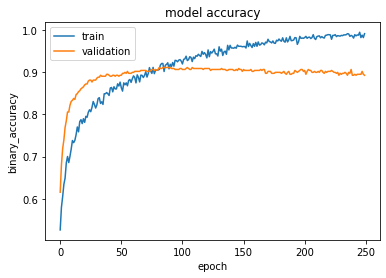

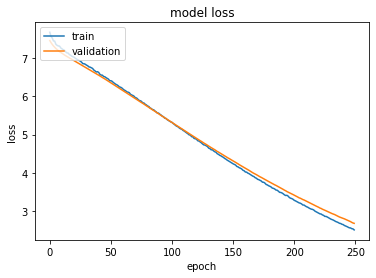

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.4896 - binary_accuracy: 0.9780
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 2.7901 - binary_accuracy: 0.8607
Test loss: 2.7901275157928467
Test accuracy: 0.8607142567634583
[0.87743733 0.83084577]

0.8541415485247855

Confusion matrix:
[[315  44]
 [ 34 167]]

Normalized confusion matrix:
[[0.87743733 0.12256267]
 [0.16915423 0.83084577]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.90      0.88      0.89       359
     label 1       0.79      0.83      0.81       201

    accuracy                           0.86       560
   macro avg       0.85      0.85      0.85       560
weighted avg       0.86      0.86      0.86       560

AUC-ROC: 0.8541415485247855
MCC: 0.7011294177807355
precision: 0.8470239954372003
recall: 0.8541415485247855
f1_score: 0.8502550600625308
Model: "sequential_65"
____________________________________

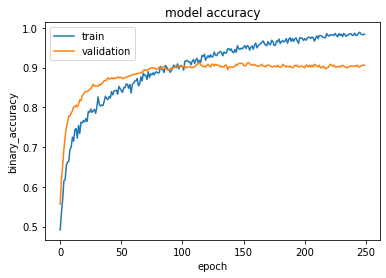

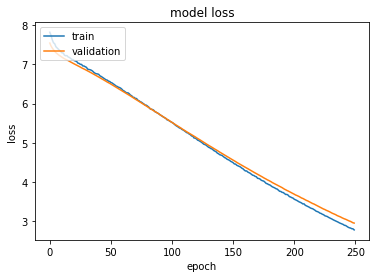

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.7652 - binary_accuracy: 0.9812
Test Accuracy: 
18/18 [==============================] - 0s 3ms/step - loss: 3.0541 - binary_accuracy: 0.8643
Test loss: 3.054133415222168
Test accuracy: 0.8642857074737549
[0.88300836 0.83084577]

0.8569270638451199

Confusion matrix:
[[317  42]
 [ 34 167]]

Normalized confusion matrix:
[[0.88300836 0.11699164]
 [0.16915423 0.83084577]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.90      0.88      0.89       359
     label 1       0.80      0.83      0.81       201

    accuracy                           0.86       560
   macro avg       0.85      0.86      0.85       560
weighted avg       0.87      0.86      0.86       560

AUC-ROC: 0.8569270638451199
MCC: 0.7079914724580347
precision: 0.8510884826674301
recall: 0.8569270638451199
f1_score: 0.8537959464101683
Model: "sequential_66"
_____________________________________

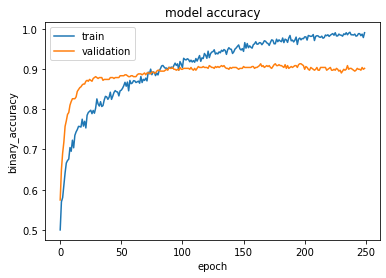

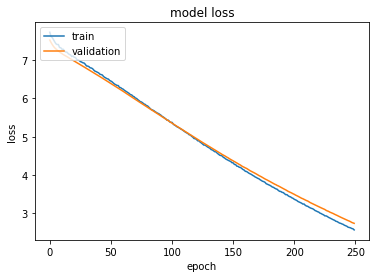

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.5533 - binary_accuracy: 0.9798
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 2.8429 - binary_accuracy: 0.8607
Test loss: 2.8429269790649414
Test accuracy: 0.8607142567634583
[0.87465181 0.8358209 ]

0.8552363530536731

Confusion matrix:
[[314  45]
 [ 33 168]]

Normalized confusion matrix:
[[0.87465181 0.12534819]
 [0.1641791  0.8358209 ]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.90      0.87      0.89       359
     label 1       0.79      0.84      0.81       201

    accuracy                           0.86       560
   macro avg       0.85      0.86      0.85       560
weighted avg       0.86      0.86      0.86       560

AUC-ROC: 0.8552363530536731
MCC: 0.7020016168268685
precision: 0.8468157649064415
recall: 0.8552363530536731
f1_score: 0.8505563082481422
Model: "sequential_67"
____________________________________

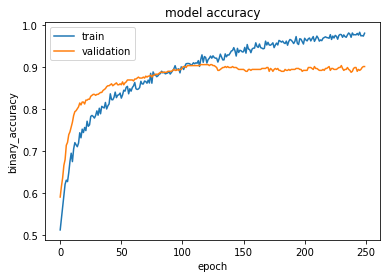

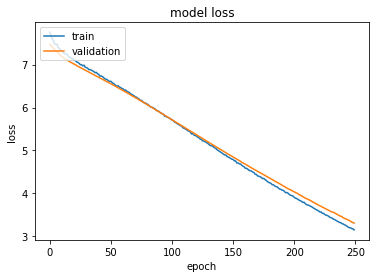

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 3.1194 - binary_accuracy: 0.9794
Test Accuracy: 
18/18 [==============================] - 0s 3ms/step - loss: 3.4239 - binary_accuracy: 0.8589
Test loss: 3.4239208698272705
Test accuracy: 0.8589285612106323
[0.86908078 0.84079602]

0.8549383999223936

Confusion matrix:
[[312  47]
 [ 32 169]]

Normalized confusion matrix:
[[0.86908078 0.13091922]
 [0.15920398 0.84079602]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.91      0.87      0.89       359
     label 1       0.78      0.84      0.81       201

    accuracy                           0.86       560
   macro avg       0.84      0.85      0.85       560
weighted avg       0.86      0.86      0.86       560

AUC-ROC: 0.8549383999223935
MCC: 0.6995554412602868
precision: 0.8446920757967269
recall: 0.8549383999223936
f1_score: 0.8490880126624163
Model: "sequential_68"
____________________________________

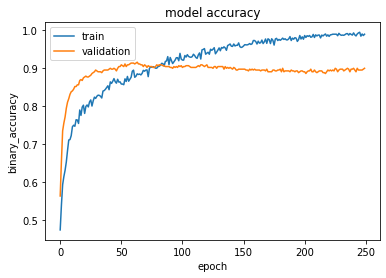

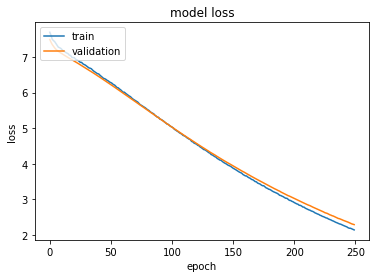

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.1269 - binary_accuracy: 0.9794
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 2.3723 - binary_accuracy: 0.8661
Test loss: 2.372281312942505
Test accuracy: 0.8660714030265808
[0.88579387 0.83084577]

0.858319821505287

Confusion matrix:
[[318  41]
 [ 34 167]]

Normalized confusion matrix:
[[0.88579387 0.11420613]
 [0.16915423 0.83084577]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.90      0.89      0.89       359
     label 1       0.80      0.83      0.82       201

    accuracy                           0.87       560
   macro avg       0.85      0.86      0.86       560
weighted avg       0.87      0.87      0.87       560

AUC-ROC: 0.8583198215052869
MCC: 0.7114478684618689
precision: 0.8531468531468531
recall: 0.858319821505287
f1_score: 0.8555703424014526
Model: "sequential_69"
_______________________________________

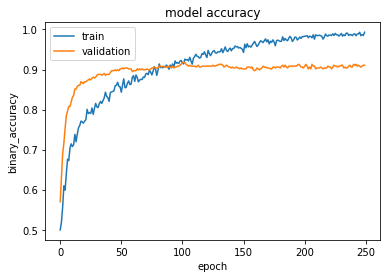

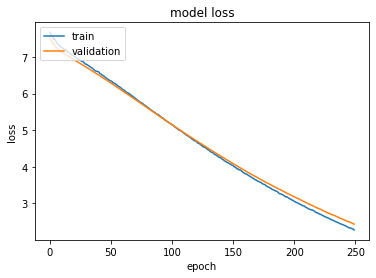

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.2678 - binary_accuracy: 0.9812
Test Accuracy: 
18/18 [==============================] - 0s 3ms/step - loss: 2.5319 - binary_accuracy: 0.8643
Test loss: 2.5318572521209717
Test accuracy: 0.8642857074737549
[0.88300836 0.83084577]

0.8569270638451199

Confusion matrix:
[[317  42]
 [ 34 167]]

Normalized confusion matrix:
[[0.88300836 0.11699164]
 [0.16915423 0.83084577]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.90      0.88      0.89       359
     label 1       0.80      0.83      0.81       201

    accuracy                           0.86       560
   macro avg       0.85      0.86      0.85       560
weighted avg       0.87      0.86      0.86       560

AUC-ROC: 0.8569270638451199
MCC: 0.7079914724580347
precision: 0.8510884826674301
recall: 0.8569270638451199
f1_score: 0.8537959464101683


In [64]:
scaler = StandardScaler()
for i in range(0, 10):
    # train - validation split:
    X_train1, X_val1, y_train1, y_val1  = train_test_split(c1_train, y_train , test_size=0.25, random_state=0)
    m = 'laser_em_batchnorm_l2_u2v_scaled_each_embed'
    i += 1
    model7 = build_model(1792)
    model_fit(model7, X_train1, y_train1 , X_val1, y_val1)
    results(model7, X_train1, y_train1, c1_test, y_test1)

> dimension drop

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_350 (Dense)            (None, 256)               433408    
_________________________________________________________________
batch_normalization_240 (Bat (None, 256)               1024      
_________________________________________________________________
dropout_280 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_351 (Dense)            (None, 128)               32896     
_________________________________________________________________
batch_normalization_241 (Bat (None, 128)               512       
_________________________________________________________________
dropout_281 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_352 (Dense)            (None, 32)              

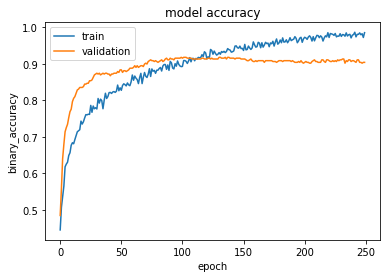

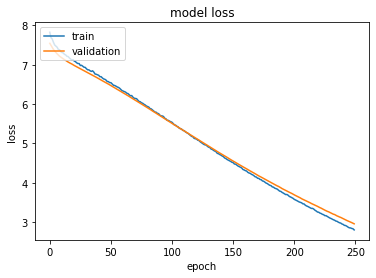

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.7819 - binary_accuracy: 0.9794
Test Accuracy: 
18/18 [==============================] - 0s 6ms/step - loss: 3.0369 - binary_accuracy: 0.8714
Test loss: 3.036914825439453
Test accuracy: 0.8714285492897034
[0.88022284 0.85572139]

0.8679721171302264

Confusion matrix:
[[316  43]
 [ 29 172]]

Normalized confusion matrix:
[[0.88022284 0.11977716]
 [0.14427861 0.85572139]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.92      0.88      0.90       359
     label 1       0.80      0.86      0.83       201

    accuracy                           0.87       560
   macro avg       0.86      0.87      0.86       560
weighted avg       0.87      0.87      0.87       560

AUC-ROC: 0.8679721171302264
MCC: 0.7258742372454156
precision: 0.8579710144927537
recall: 0.8679721171302264
f1_score: 0.8623251748251749


In [65]:
# select 100 random indices
indices_to_drop = np.random.choice(1792, 100, replace=False)

# drop selected dimensions from all vectors
c_tr = np.delete(scaled_vectors_train, indices_to_drop, axis=1)
c_ts = np.delete(scaled_vectors_test, indices_to_drop, axis=1)
X_train1, X_val1, y_train1, y_val1  = train_test_split(c_tr, y_train , test_size=0.25, random_state=0)
b = X_train1.shape[1]

m = 'laser_em_batchnorm_l2_u2v_scaled_drop100dim'
model8 = build_model(b)
model_fit(model8, X_train1, y_train1, X_val1, y_val1)
results(model8, X_train1, y_train1, c_ts, y_test1)

Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_355 (Dense)            (None, 256)               407808    
_________________________________________________________________
batch_normalization_244 (Bat (None, 256)               1024      
_________________________________________________________________
dropout_284 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_356 (Dense)            (None, 128)               32896     
_________________________________________________________________
batch_normalization_245 (Bat (None, 128)               512       
_________________________________________________________________
dropout_285 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_357 (Dense)            (None, 32)              

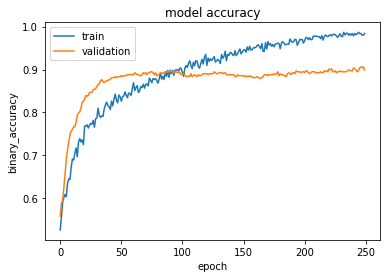

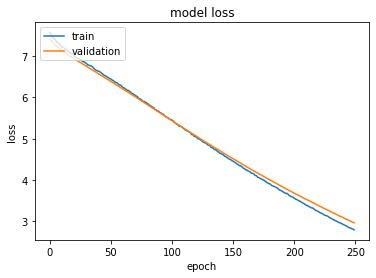

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.7687 - binary_accuracy: 0.9794
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 3.0411 - binary_accuracy: 0.8464
Test loss: 3.0410516262054443
Test accuracy: 0.8464285731315613
[0.88857939 0.77114428]

0.8298618328967974

Confusion matrix:
[[319  40]
 [ 46 155]]

Normalized confusion matrix:
[[0.88857939 0.11142061]
 [0.22885572 0.77114428]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.87      0.89      0.88       359
     label 1       0.79      0.77      0.78       201

    accuracy                           0.85       560
   macro avg       0.83      0.83      0.83       560
weighted avg       0.85      0.85      0.85       560

AUC-ROC: 0.8298618328967973
MCC: 0.6642683778698044
precision: 0.8344221988057604
recall: 0.8298618328967974
f1_score: 0.8320218762207713


In [66]:
# select 100 random indices
indices_to_drop = np.random.choice(1792, 200, replace=False)
# drop selected dimensions from all vectors
c_tr = np.delete(scaled_vectors_train, indices_to_drop, axis=1)
c_ts = np.delete(scaled_vectors_test, indices_to_drop, axis=1)

# drop selected dimensions from all vectors
X_train1, X_val1, y_train1, y_val1  = train_test_split(c_tr, y_train , test_size=0.25, random_state=0)
b = X_train1.shape[1]

m = 'laser_em_batchnorm_l2_u2v_scaled_drop200dim'
b = c_tr.shape[1]
model9 = build_model(b)
model_fit(model9, X_train1, y_train1, X_val1, y_val1)
results(model9, X_train1, y_train1, c_ts, y_test1)

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_360 (Dense)            (None, 256)               331008    
_________________________________________________________________
batch_normalization_248 (Bat (None, 256)               1024      
_________________________________________________________________
dropout_288 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_361 (Dense)            (None, 128)               32896     
_________________________________________________________________
batch_normalization_249 (Bat (None, 128)               512       
_________________________________________________________________
dropout_289 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_362 (Dense)            (None, 32)              

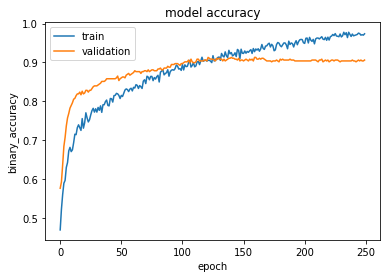

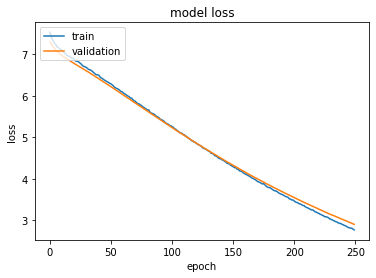

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 2.7376 - binary_accuracy: 0.9798
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 2.9790 - binary_accuracy: 0.8429
Test loss: 2.9790308475494385
Test accuracy: 0.8428571224212646
[0.85793872 0.8159204 ]

0.8369295583364514

Confusion matrix:
[[308  51]
 [ 37 164]]

Normalized confusion matrix:
[[0.85793872 0.14206128]
 [0.1840796  0.8159204 ]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.89      0.86      0.88       359
     label 1       0.76      0.82      0.79       201

    accuracy                           0.84       560
   macro avg       0.83      0.84      0.83       560
weighted avg       0.85      0.84      0.84       560

AUC-ROC: 0.8369295583364514
MCC: 0.6646386364006841
precision: 0.8277721604314122
recall: 0.8369295583364514
f1_score: 0.8317307692307693


In [67]:
# select 100 random indices
indices_to_drop = np.random.choice(1792, 500, replace=False)

# drop selected dimensions from all vectors
c_tr = np.delete(scaled_vectors_train, indices_to_drop, axis=1)
c_ts = np.delete(scaled_vectors_test, indices_to_drop, axis=1)
X_train1, X_val1, y_train1, y_val1  = train_test_split(c_tr, y_train , test_size=0.25, random_state=0)
b = X_train1.shape[1]

model10 = build_model(b)
model_fit(model10, X_train1, y_train1, X_val1, y_val1)
results(model10, X_train1, y_train1, c_ts, y_test1)


Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_365 (Dense)            (None, 256)               203008    
_________________________________________________________________
batch_normalization_252 (Bat (None, 256)               1024      
_________________________________________________________________
dropout_292 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_366 (Dense)            (None, 128)               32896     
_________________________________________________________________
batch_normalization_253 (Bat (None, 128)               512       
_________________________________________________________________
dropout_293 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_367 (Dense)            (None, 32)              

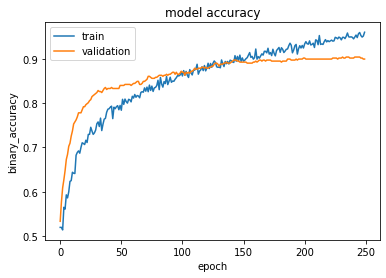

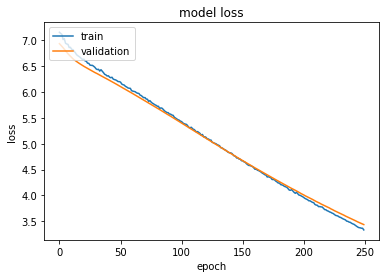

Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 3.2885 - binary_accuracy: 0.9739
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 3.5466 - binary_accuracy: 0.8500
Test loss: 3.5465755462646484
Test accuracy: 0.8500000238418579
[0.85236769 0.84577114]

0.8490694161504455

Confusion matrix:
[[306  53]
 [ 31 170]]

Normalized confusion matrix:
[[0.85236769 0.14763231]
 [0.15422886 0.84577114]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.91      0.85      0.88       359
     label 1       0.76      0.85      0.80       201

    accuracy                           0.85       560
   macro avg       0.84      0.85      0.84       560
weighted avg       0.86      0.85      0.85       560

AUC-ROC: 0.8490694161504455
MCC: 0.6841001195323855
precision: 0.8351718540006121
recall: 0.8490694161504455
f1_score: 0.8405985686402082


In [68]:
# select 100 random indices
indices_to_drop = np.random.choice(1792, 1000, replace=False)

# drop selected dimensions from all vectors
c_tr = np.delete(scaled_vectors_train, indices_to_drop, axis=1)
c_ts = np.delete(scaled_vectors_test, indices_to_drop, axis=1)
X_train1, X_val1, y_train1, y_val1  = train_test_split(c_tr, y_train , test_size=0.25, random_state=0)
b = X_train1.shape[1]
m = 'laser_em_batchnorm_l2_u2v_scaled_drop1000dim'
model11 = build_model(b)
model_fit(model11, X_train1, y_train1, X_val1, y_val1)
results(model11, X_train1, y_train1, c_ts, y_test1)

from 10 epochs we can have an idea if it is good to drop dimentions of the concatenated embeddings, so better to not i guess

In [69]:
# maxi = []
# mini = []
# sumi = []
# for i in range (0, len(X_train)):
# #     print('sum = ', sum(X_train[i]))
# #     print('max = ', max(X_train[i]))
#     maxi.append(max(X_train[i]))
# #     print('min = ', min(X_train[i]))
#     mini.append(min(X_train[i]))
#     sumi.append(sum(X_train[i]))
# print('overall max: ', max(maxi))
# print('overall min: ', min(mini))
# print('overall max sum: ', max(sumi))

In [70]:
# maxii = []
# minii = []
# sumii = []
# for i in range (0, len(X_train_em)):
# #     print('sum = ', sum(X_train_em[i]))
# #     print('max = ', max(X_train_em[i]))
#     maxii.append(max(X_train_em[i]))
# #     print('min = ', min(X_train_em[i]))
#     minii.append(min(X_train_em[i]))
#     sumii.append(sum(X_train_em[i]))

# print('overall max: ', max(maxii))
# print('overall min: ', min(minii))
# print('overall max sum: ', max(sumii))

> tuning - laser only

In [71]:
def show_best_hps():
    print("Best Hyperparameters:")
    print(f" units_1 : {best_hps.get('units_1')}")
    print(f" act_1 : {best_hps.get('act_1')}")
    print(f" dropout_1 : {best_hps.get('dropout_1')}")
    print(f" units_2 : {best_hps.get('units_2')}")
    print(f" act_2 : {best_hps.get('act_2')}")
    print(f" dropout_2 : {best_hps.get('dropout_2')}")
    print(f" units_3 : {best_hps.get('units_3')}")
    print(f" act_3 : {best_hps.get('act_3')}")
    print(f" dropout_3 : {best_hps.get('dropout_3')}")
    print(f" units_4 : {best_hps.get('units_4')}")
    print(f" act_4 : {best_hps.get('act_4')}")
    print(f" dropout_4 : {best_hps.get('dropout_4')}")
    # print(f"Kernel size: {best_hps.get('kernel_size')}")
    print(f"Learning rate: {best_hps.get('learning_rate')}")
    
    
def build_model_tune(hp):
        
    #hyperparameters for layer 1 - 3
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=512, step=128)
    hp_act_1 = hp.Choice('act_1', ['relu', 'sigmoid'])
    hp_dropout_1 = hp.Float('dropout_1', 0, 0.5, step=0.1, default=0.25)
    #hyperparameters for layer 4 - 6
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=256, step=64)
    hp_act_2 = hp.Choice('act_2' , ['relu', 'sigmoid' ])
    hp_dropout_2 = hp.Float('dropout_2', 0, 0.5, step=0.1, default=0.25)
    #hyperparameters for layer 7 - 9 
    hp_units_3 = hp.Int('units_3', min_value=32, max_value=128, step=32)
    hp_act_3 = hp.Choice('act_3' , ['relu', 'sigmoid' ])
    hp_dropout_3 = hp.Float('dropout_3', 0, 0.5, step=0.1, default=0.25)
    #hyperparameters for layer 10 - 12
    hp_units_4 = hp.Int('units_4', min_value=32, max_value=64, step=16)
    hp_act_4 = hp.Choice('act_4' , ['relu', 'sigmoid' ])
    hp_dropout_4 = hp.Float('dropout_4', 0, 0.5, step=0.1, default=0.25)
    #hyperparameters for compiling model
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-4])
    
    #simple layers to train laser embedded sentences
    seq_input  = tfkl.Input(shape=(1792,),  name = "Sequential_Input")
    #input folowed by dense layer 1
    layer1 = Dense(units = hp_units_1, activation=hp_act_1, 
                   kernel_regularizer=tfk.regularizers.L2(0.001),  
                   name="layer1")(seq_input)
    layer2 = tfkl.BatchNormalization()(layer1)
    layer3 = tfkl.Dropout(hp_dropout_1)(layer2)   
    
    #Dense layer 2
    layer4 = Dense(units=hp_units_2, kernel_regularizer=tfk.regularizers.L2(0.001),  
                   activation=hp_act_2,name="layer4")(layer3)
    layer5 = tfkl.BatchNormalization()(layer4)
    layer6 = tfkl.Dropout(hp_dropout_2)(layer5)
        
    #Dense layer 3
    layer7 = Dense(units=hp_units_3, kernel_regularizer=tfk.regularizers.L2(0.001),  
                   activation=hp_act_3,name="layer7")(layer6)
    layer8 = tfkl.BatchNormalization()(layer7)
    layer9 = tfkl.Dropout(hp_dropout_3)(layer8)
    
    #Dense layer 4
    layer10 = Dense(units=hp_units_4, kernel_regularizer=tfk.regularizers.L2(0.001),  
                   activation=hp_act_4 ,name="layer10")(layer9)
    layer11 = tfkl.BatchNormalization()(layer10)
    layer12 = tfkl.Dropout(hp_dropout_4)(layer11)
    
    # the last layer of binary classification will have the activation function sigmoid
    output_layer  = tfkl.Dense(units=1, activation=tfk.activations.sigmoid, kernel_initializer=tfk.initializers.GlorotNormal(seed), name='Output')(layer12) 
        
    model = Model(inputs=seq_input,outputs=[output_layer], name = "CS_AWARE_Model")
    
    model.compile(loss = tfk.losses.BinaryCrossentropy(from_logits=True), 
                  optimizer=tfk.optimizers.Adam(learning_rate=hp_learning_rate),
                  metrics =  ['binary_accuracy'])
    return model


In [72]:
def model_fit(model,x, y, x_v, y_v):
    global num_saved_models, m, best_epoch
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10, restore_best_weights=True)
    history = model.fit(x, y, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_split=0.2, 
                        validation_data=([x_v,y_v]),
                        verbose=0,
                        callbacks=[callback,TrainingTimeCallback()])
    
    plot_history(history)
    model.save(f"model_{m}_{num_saved_models}.h5")
    val_acc_per_epoch = history.history['val_binary_accuracy']
    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
    print('Best epoch: %d' % (best_epoch,))
    # Increment the counter for saved models
    num_saved_models += 1

In [73]:
X_train1, X_val1, y_train1, y_val1  = train_test_split(scaled_vectors_train, y_train , test_size=0.25, random_state=0)

Search space summary
Default search space size: 13
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 128, 'sampling': None}
act_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 64, 'sampling': None}
act_2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
dropout_2 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
act_3 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
dropout_3 (Float)
{'default': 0.25, 'conditions': [], '

/opt/conda/lib/python3.7/site-packages/keras/backend.py:4994: UserWarning:

"`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"



Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units_1: 160
act_1: relu
dropout_1: 0.4
units_2: 32
act_2: sigmoid
dropout_2: 0.1
units_3: 64
act_3: relu
dropout_3: 0.4
units_4: 64
act_4: relu
dropout_4: 0.0
learning_rate: 0.0001
Score: 0.912356972694397
Trial summary
Hyperparameters:
units_1: 288
act_1: relu
dropout_1: 0.4
units_2: 160
act_2: relu
dropout_2: 0.1
units_3: 96
act_3: sigmoid
dropout_3: 0.4
units_4: 48
act_4: sigmoid
dropout_4: 0.30000000000000004
learning_rate: 0.0001
Score: 0.9109839767217636
Trial summary
Hyperparameters:
units_1: 416
act_1: relu
dropout_1: 0.30000000000000004
units_2: 224
act_2: sigmoid
dropout_2: 0.2
units_3: 64
act_3: sigmoid
dropout_3: 0.4
units_4: 48
act_4: relu
dropout_4: 0.30000000000000004
learning_rate: 0.0001
Score: 0.9108695656061172
Trial summary
Hyperparameters:
units_1: 288
act_1: relu
dropout_1: 0.2
units_2: 96
act_2: sigmoid
dropout_2: 0.4
units_3: 64
act_3: sigmoid
dropout_3: 0.1
unit

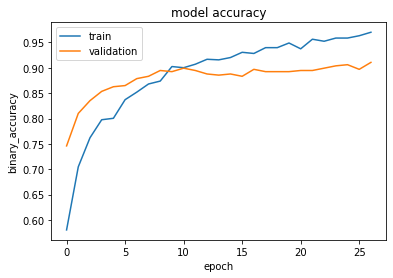

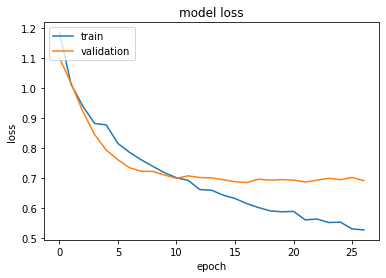

Best epoch: 27
Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 0.5508 - binary_accuracy: 0.9624
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 0.7983 - binary_accuracy: 0.8607
Test loss: 0.7983272671699524
Test accuracy: 0.8607142567634583
[0.8718663  0.84079602]

0.8563311575825607

Confusion matrix:
[[313  46]
 [ 32 169]]

Normalized confusion matrix:
[[0.8718663  0.1281337 ]
 [0.15920398 0.84079602]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.91      0.87      0.89       359
     label 1       0.79      0.84      0.81       201

    accuracy                           0.86       560
   macro avg       0.85      0.86      0.85       560
weighted avg       0.86      0.86      0.86       560

AUC-ROC: 0.8563311575825605
MCC: 0.7029108869286412
precision: 0.8466464442197505
recall: 0.8563311575825607
f1_score: 0.8508522727272727
Best epoch: 27

Retrain the model with best 

/opt/conda/lib/python3.7/site-packages/keras/backend.py:4994: UserWarning:

"`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"



Training time: 9.782851219177246 seconds


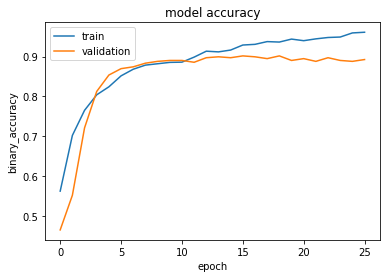

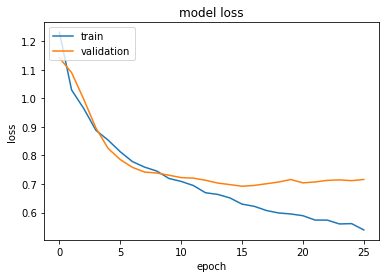

Best epoch: 16
Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 0.5673 - binary_accuracy: 0.9578
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 0.8258 - binary_accuracy: 0.8393
Test loss: 0.8258256316184998
Test accuracy: 0.8392857313156128
[0.85793872 0.80597015]

0.831954433958342

Confusion matrix:
[[308  51]
 [ 39 162]]

Normalized confusion matrix:
[[0.85793872 0.14206128]
 [0.19402985 0.80597015]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.89      0.86      0.87       359
     label 1       0.76      0.81      0.78       201

    accuracy                           0.84       560
   macro avg       0.82      0.83      0.83       560
weighted avg       0.84      0.84      0.84       560

AUC-ROC: 0.831954433958342
MCC: 0.6559929673537517
precision: 0.8240857247229776
recall: 0.831954433958342
f1_score: 0.8275649710555488


In [74]:
    epochs = 50
    #Tuner
    tuner = RandomSearch(
        build_model_tune,
        objective = 'val_binary_accuracy',
        max_trials = 20,
        executions_per_trial = 20,
        #overwrite=True,
    )
    # not necessary to see it every time
    tuner.search_space_summary()
    
    tuner.search(X_train1, y_train1, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_split=0.2, 
                    verbose=0,#not necessary to see all trainings
                    validation_data=([X_val1, y_val1])
                )
    tuner.results_summary()
    
    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
    print()
    print('best parameters that have been found: ')
    show_best_hps()
    print()

    print()
    # Build the model with the optimal hyperparameters and train it on the data for 50 epochs
    tuned_model = tuner.hypermodel.build(best_hps)
    #sow only the model with best params
    print(tuned_model.summary())
    global history
    epochs = 250
    m = 'tunned_model_laser'        
    history = model_fit(tuned_model, X_train1, y_train1, X_val1, y_val1)
    results(tuned_model, X_train1, y_train1, scaled_vectors_test, y_test1)

#     print("Tuned model history: ")
#     plot_history(history)
    
#     val_acc_per_epoch = history.history['val_binary_accuracy']
#     best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
    print('Best epoch: %d' % (best_epoch,))
    
#     #now include best epoch
    hypermodel = tuner.hypermodel.build(best_hps)
    
    # Retrain the model with best epoch
    print()
    print("Retrain the model with best hps and epoch: ")
    print('Hypermodel: ')
    m = 'hypermodel_laser'        
    model_fit(hypermodel, X_train1, y_train1, X_val1, y_val1)
    results(hypermodel, X_train1, y_train1, scaled_vectors_test, y_test1)
    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               459008    
_________________________________________________________________
batch_normalization_12 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_13 (Batc (None, 128)               512       
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4

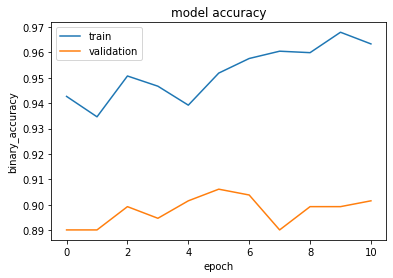

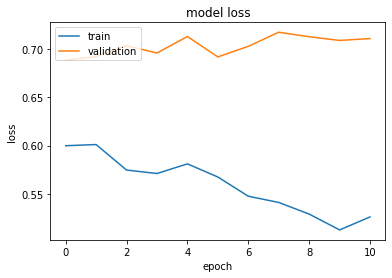

Best epoch: 6
Train Accuracy: 
69/69 [==============================] - 0s 4ms/step - loss: 0.5435 - binary_accuracy: 0.9633
Test Accuracy: 
18/18 [==============================] - 0s 4ms/step - loss: 0.8096 - binary_accuracy: 0.8625
Test loss: 0.8095664381980896
Test accuracy: 0.862500011920929
[0.87465181 0.84079602]

0.8577239152427278

Confusion matrix:
[[314  45]
 [ 32 169]]

Normalized confusion matrix:
[[0.87465181 0.12534819]
 [0.15920398 0.84079602]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.91      0.87      0.89       359
     label 1       0.79      0.84      0.81       201

    accuracy                           0.86       560
   macro avg       0.85      0.86      0.85       560
weighted avg       0.87      0.86      0.86       560

AUC-ROC: 0.8577239152427277
MCC: 0.7062822436925748
precision: 0.8486170385176381
recall: 0.8577239152427278
f1_score: 0.8526189865846364
Model: "sequential_1"
________________________

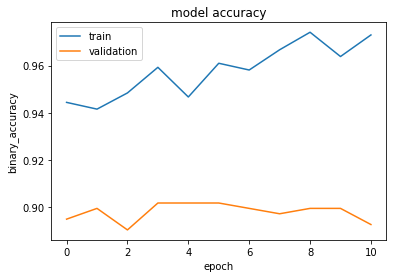

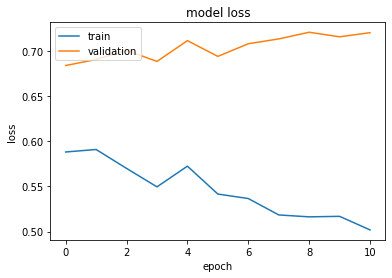

Best epoch: 4
Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 0.5355 - binary_accuracy: 0.9647
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 0.7975 - binary_accuracy: 0.8625
Test loss: 0.7974897623062134
Test accuracy: 0.862500011920929
[0.88022284 0.83084577]

0.8555343061849527

Confusion matrix:
[[316  43]
 [ 34 167]]

Normalized confusion matrix:
[[0.88022284 0.11977716]
 [0.16915423 0.83084577]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.90      0.88      0.89       359
     label 1       0.80      0.83      0.81       201

    accuracy                           0.86       560
   macro avg       0.85      0.86      0.85       560
weighted avg       0.86      0.86      0.86       560

AUC-ROC: 0.8555343061849527
MCC: 0.7045520649706589
precision: 0.849047619047619
recall: 0.8555343061849527
f1_score: 0.8520242004948542
Model: "sequential_2"
_________________________

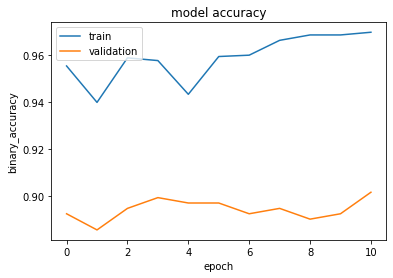

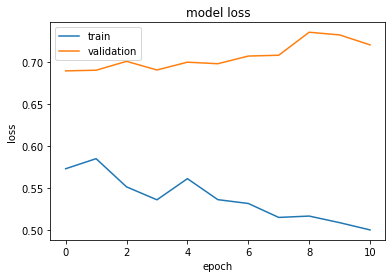

Best epoch: 11
Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 0.5287 - binary_accuracy: 0.9670
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 0.7850 - binary_accuracy: 0.8643
Test loss: 0.7850450873374939
Test accuracy: 0.8642857074737549
[0.88022284 0.8358209 ]

0.8580218683740074

Confusion matrix:
[[316  43]
 [ 33 168]]

Normalized confusion matrix:
[[0.88022284 0.11977716]
 [0.1641791  0.8358209 ]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.91      0.88      0.89       359
     label 1       0.80      0.84      0.82       201

    accuracy                           0.86       560
   macro avg       0.85      0.86      0.85       560
weighted avg       0.87      0.86      0.86       560

AUC-ROC: 0.8580218683740075
MCC: 0.7088116747992099
precision: 0.8508263284400929
recall: 0.8580218683740074
f1_score: 0.8540946739070814
Model: "sequential_3"
______________________

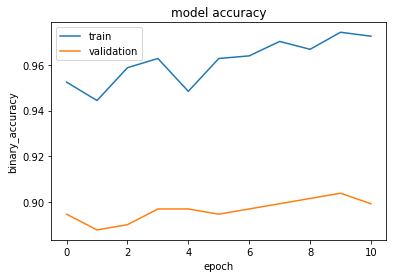

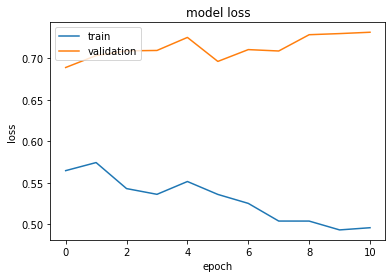

Best epoch: 10
Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 0.5225 - binary_accuracy: 0.9693
Test Accuracy: 
18/18 [==============================] - 0s 3ms/step - loss: 0.7906 - binary_accuracy: 0.8625
Test loss: 0.7906489372253418
Test accuracy: 0.862500011920929
[0.88022284 0.83084577]

0.8555343061849527

Confusion matrix:
[[316  43]
 [ 34 167]]

Normalized confusion matrix:
[[0.88022284 0.11977716]
 [0.16915423 0.83084577]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.90      0.88      0.89       359
     label 1       0.80      0.83      0.81       201

    accuracy                           0.86       560
   macro avg       0.85      0.86      0.85       560
weighted avg       0.86      0.86      0.86       560

AUC-ROC: 0.8555343061849527
MCC: 0.7045520649706589
precision: 0.849047619047619
recall: 0.8555343061849527
f1_score: 0.8520242004948542
Model: "sequential_4"
________________________

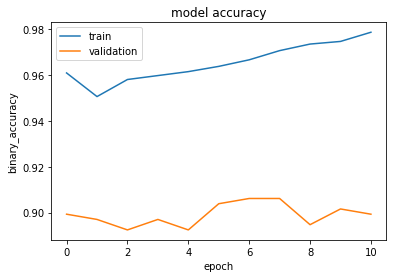

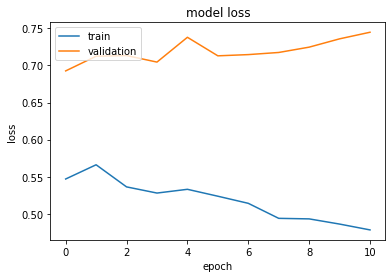

Best epoch: 7
Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 0.5187 - binary_accuracy: 0.9716
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 0.7974 - binary_accuracy: 0.8607
Test loss: 0.7973983287811279
Test accuracy: 0.8607142567634583
[0.88022284 0.82587065]

0.853046743995898

Confusion matrix:
[[316  43]
 [ 35 166]]

Normalized confusion matrix:
[[0.88022284 0.11977716]
 [0.17412935 0.82587065]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.90      0.88      0.89       359
     label 1       0.79      0.83      0.81       201

    accuracy                           0.86       560
   macro avg       0.85      0.85      0.85       560
weighted avg       0.86      0.86      0.86       560

AUC-ROC: 0.853046743995898
MCC: 0.7002945684069292
precision: 0.847271636745321
recall: 0.853046743995898
f1_score: 0.8499484713156992
Model: "sequential_5"
___________________________

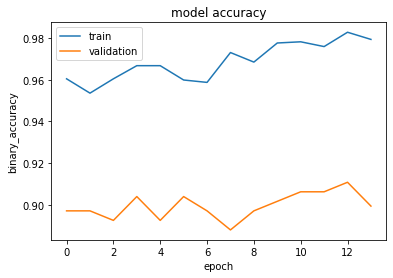

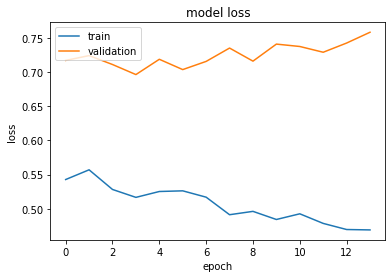

Best epoch: 13
Train Accuracy: 
69/69 [==============================] - 0s 3ms/step - loss: 0.4983 - binary_accuracy: 0.9780
Test Accuracy: 
18/18 [==============================] - 0s 3ms/step - loss: 0.8011 - binary_accuracy: 0.8679
Test loss: 0.801060676574707
Test accuracy: 0.8678571581840515
[0.88579387 0.8358209 ]

0.8608073836943416

Confusion matrix:
[[318  41]
 [ 33 168]]

Normalized confusion matrix:
[[0.88579387 0.11420613]
 [0.1641791  0.8358209 ]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.91      0.89      0.90       359
     label 1       0.80      0.84      0.82       201

    accuracy                           0.87       560
   macro avg       0.85      0.86      0.86       560
weighted avg       0.87      0.87      0.87       560

AUC-ROC: 0.8608073836943416
MCC: 0.7156883765091403
precision: 0.8549053285895392
recall: 0.8608073836943416
f1_score: 0.8576434215046376
Model: "sequential_6"
_______________________

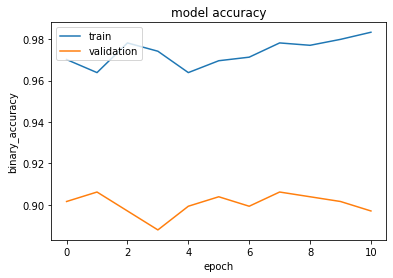

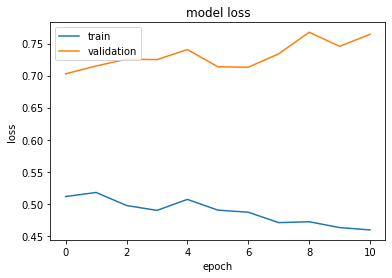

Best epoch: 2
Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 0.4969 - binary_accuracy: 0.9757
Test Accuracy: 
18/18 [==============================] - 0s 3ms/step - loss: 0.8212 - binary_accuracy: 0.8679
Test loss: 0.8211782574653625
Test accuracy: 0.8678571581840515
[0.88300836 0.84079602]

0.8619021882232292

Confusion matrix:
[[317  42]
 [ 32 169]]

Normalized confusion matrix:
[[0.88300836 0.11699164]
 [0.15920398 0.84079602]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.91      0.88      0.90       359
     label 1       0.80      0.84      0.82       201

    accuracy                           0.87       560
   macro avg       0.85      0.86      0.86       560
weighted avg       0.87      0.87      0.87       560

AUC-ROC: 0.8619021882232292
MCC: 0.7164939318176844
precision: 0.8546286614429854
recall: 0.8619021882232292
f1_score: 0.8579342877516318
Model: "sequential_7"
_______________________

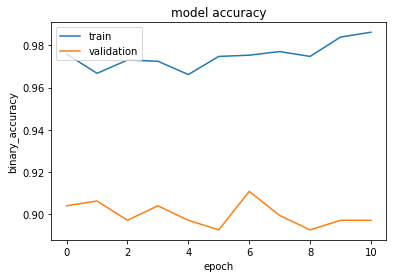

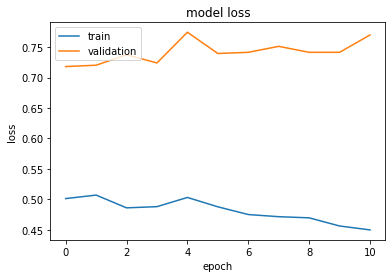

Best epoch: 7
Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 0.4942 - binary_accuracy: 0.9785
Test Accuracy: 
18/18 [==============================] - 0s 3ms/step - loss: 0.8162 - binary_accuracy: 0.8679
Test loss: 0.8161719441413879
Test accuracy: 0.8678571581840515
[0.88300836 0.84079602]

0.8619021882232292

Confusion matrix:
[[317  42]
 [ 32 169]]

Normalized confusion matrix:
[[0.88300836 0.11699164]
 [0.15920398 0.84079602]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.91      0.88      0.90       359
     label 1       0.80      0.84      0.82       201

    accuracy                           0.87       560
   macro avg       0.85      0.86      0.86       560
weighted avg       0.87      0.87      0.87       560

AUC-ROC: 0.8619021882232292
MCC: 0.7164939318176844
precision: 0.8546286614429854
recall: 0.8619021882232292
f1_score: 0.8579342877516318
Model: "sequential_8"
_______________________

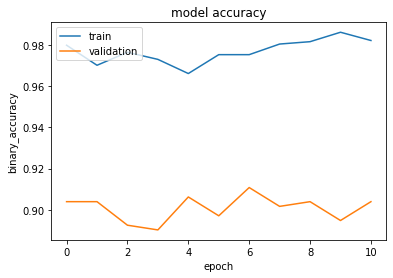

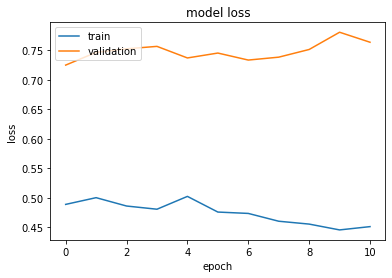

Best epoch: 7
Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 0.4921 - binary_accuracy: 0.9789
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 0.8140 - binary_accuracy: 0.8732
Test loss: 0.8140241503715515
Test accuracy: 0.8732143044471741
[0.89415042 0.8358209 ]

0.8649856566748431

Confusion matrix:
[[321  38]
 [ 33 168]]

Normalized confusion matrix:
[[0.89415042 0.10584958]
 [0.1641791  0.8358209 ]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.91      0.89      0.90       359
     label 1       0.82      0.84      0.83       201

    accuracy                           0.87       560
   macro avg       0.86      0.86      0.86       560
weighted avg       0.87      0.87      0.87       560

AUC-ROC: 0.8649856566748431
MCC: 0.7261323829776235
precision: 0.8611568207997367
recall: 0.8649856566748431
f1_score: 0.8629867914580398
Model: "sequential_9"
_______________________

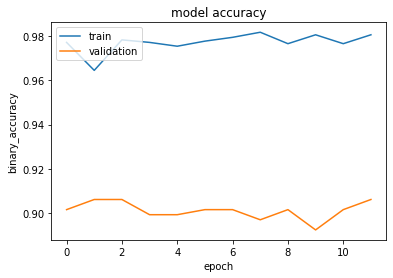

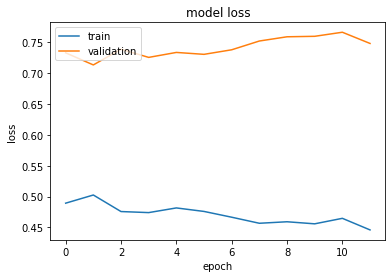

Best epoch: 2
Train Accuracy: 
69/69 [==============================] - 0s 3ms/step - loss: 0.4840 - binary_accuracy: 0.9798
Test Accuracy: 
18/18 [==============================] - 0s 3ms/step - loss: 0.8402 - binary_accuracy: 0.8643
Test loss: 0.8401516675949097
Test accuracy: 0.8642857074737549
[0.88579387 0.82587065]

0.8558322593162322

Confusion matrix:
[[318  41]
 [ 35 166]]

Normalized confusion matrix:
[[0.88579387 0.11420613]
 [0.17412935 0.82587065]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.90      0.89      0.89       359
     label 1       0.80      0.83      0.81       201

    accuracy                           0.86       560
   macro avg       0.85      0.86      0.85       560
weighted avg       0.87      0.86      0.86       560

AUC-ROC: 0.8558322593162322
MCC: 0.7072094274107755
precision: 0.8513911127533496
recall: 0.8558322593162322
f1_score: 0.8534919585811853


In [75]:
epochs = 250
for i in range(0, 10):
    # train - validation split:
    X_train1, X_val1, y_train1, y_val1  = train_test_split(scaled_vectors_train, y_train , test_size=0.25, random_state=0)
    m = 'tunned_model_laser_u2v'
    i += 1
    model65 = build_model(1792)
    model_fit(tuned_model, X_train1, y_train1 , X_val1, y_val1)
    results(tuned_model, X_train1, y_train1, scaled_vectors_test, y_test1)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 256)               459008    
_________________________________________________________________
batch_normalization_52 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_52 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_53 (Batc (None, 128)               512       
_________________________________________________________________
dropout_53 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 32)              

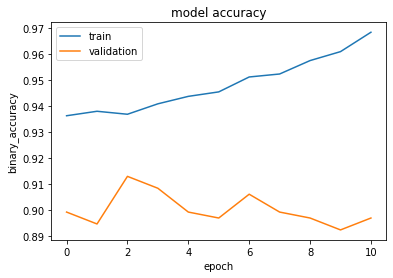

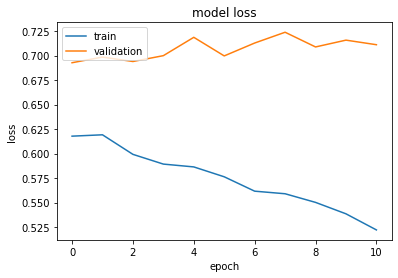

Best epoch: 3
Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 0.5570 - binary_accuracy: 0.9606
Test Accuracy: 
18/18 [==============================] - 0s 3ms/step - loss: 0.8121 - binary_accuracy: 0.8536
Test loss: 0.8121362328529358
Test accuracy: 0.8535714149475098
[0.8718663  0.82089552]

0.8463809088263419

Confusion matrix:
[[313  46]
 [ 36 165]]

Normalized confusion matrix:
[[0.8718663  0.1281337 ]
 [0.17910448 0.82089552]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.90      0.87      0.88       359
     label 1       0.78      0.82      0.80       201

    accuracy                           0.85       560
   macro avg       0.84      0.85      0.84       560
weighted avg       0.86      0.85      0.85       560

AUC-ROC: 0.8463809088263418
MCC: 0.6857649037437865
precision: 0.8394193294314154
recall: 0.8463809088263419
f1_score: 0.8425758323734298
Model: "sequential_11"
______________________

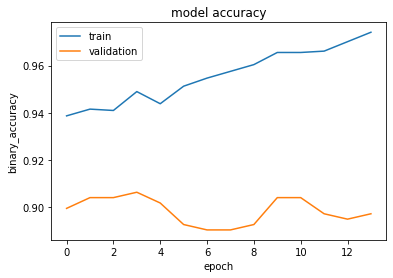

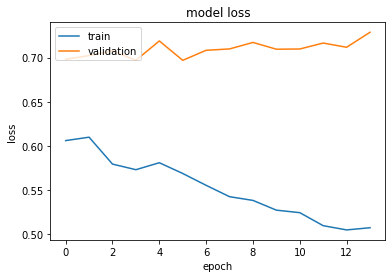

Best epoch: 4
Train Accuracy: 
69/69 [==============================] - 0s 3ms/step - loss: 0.5289 - binary_accuracy: 0.9725
Test Accuracy: 
18/18 [==============================] - 0s 3ms/step - loss: 0.8181 - binary_accuracy: 0.8554
Test loss: 0.8180563449859619
Test accuracy: 0.8553571701049805
[0.86908078 0.83084577]

0.8499632755442841

Confusion matrix:
[[312  47]
 [ 34 167]]

Normalized confusion matrix:
[[0.86908078 0.13091922]
 [0.16915423 0.83084577]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.90      0.87      0.89       359
     label 1       0.78      0.83      0.80       201

    accuracy                           0.86       560
   macro avg       0.84      0.85      0.84       560
weighted avg       0.86      0.86      0.86       560

AUC-ROC: 0.8499632755442842
MCC: 0.6909598070727382
precision: 0.8410539679109719
recall: 0.8499632755442841
f1_score: 0.8449628300435785
Model: "sequential_12"
______________________

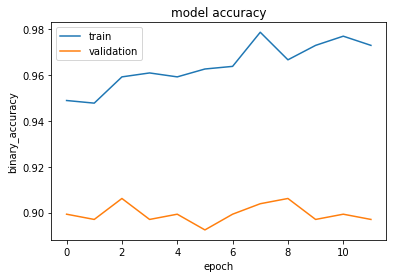

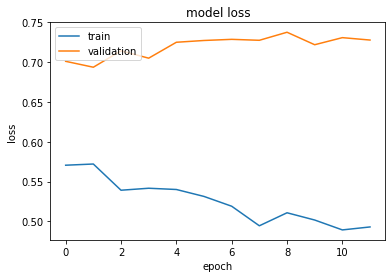

Best epoch: 3
Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 0.5167 - binary_accuracy: 0.9720
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 0.8337 - binary_accuracy: 0.8589
Test loss: 0.8337278366088867
Test accuracy: 0.8589285612106323
[0.87743733 0.82587065]

0.8516539863357309

Confusion matrix:
[[315  44]
 [ 35 166]]

Normalized confusion matrix:
[[0.87743733 0.12256267]
 [0.17412935 0.82587065]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.90      0.88      0.89       359
     label 1       0.79      0.83      0.81       201

    accuracy                           0.86       560
   macro avg       0.85      0.85      0.85       560
weighted avg       0.86      0.86      0.86       560

AUC-ROC: 0.8516539863357308
MCC: 0.6968625472083597
precision: 0.8452380952380952
recall: 0.8516539863357309
f1_score: 0.8481806732349803
Model: "sequential_13"
______________________

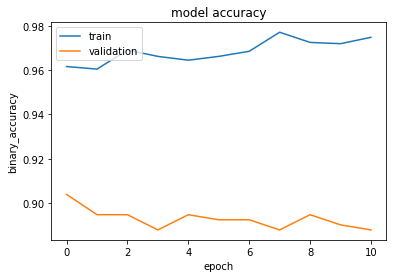

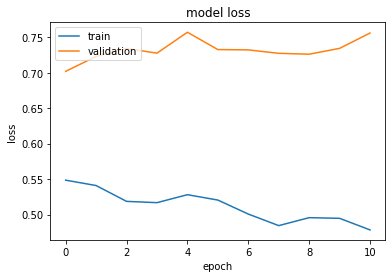

Best epoch: 1
Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 0.5117 - binary_accuracy: 0.9748
Test Accuracy: 
18/18 [==============================] - 0s 3ms/step - loss: 0.8359 - binary_accuracy: 0.8661
Test loss: 0.835934579372406
Test accuracy: 0.8660714030265808
[0.88579387 0.83084577]

0.858319821505287

Confusion matrix:
[[318  41]
 [ 34 167]]

Normalized confusion matrix:
[[0.88579387 0.11420613]
 [0.16915423 0.83084577]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.90      0.89      0.89       359
     label 1       0.80      0.83      0.82       201

    accuracy                           0.87       560
   macro avg       0.85      0.86      0.86       560
weighted avg       0.87      0.87      0.87       560

AUC-ROC: 0.8583198215052869
MCC: 0.7114478684618689
precision: 0.8531468531468531
recall: 0.858319821505287
f1_score: 0.8555703424014526
Model: "sequential_14"
_________________________

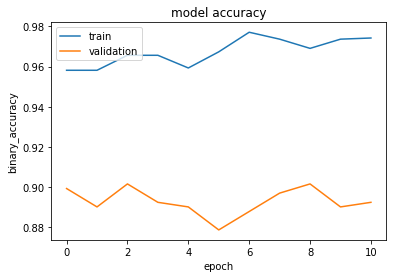

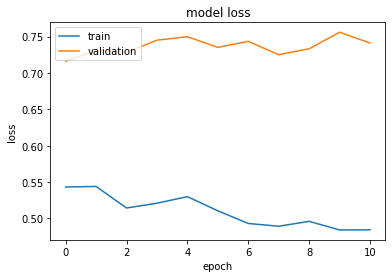

Best epoch: 3
Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 0.5101 - binary_accuracy: 0.9752
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 0.8171 - binary_accuracy: 0.8607
Test loss: 0.8171489834785461
Test accuracy: 0.8607142567634583
[0.88300836 0.82089552]

0.8519519394670103

Confusion matrix:
[[317  42]
 [ 36 165]]

Normalized confusion matrix:
[[0.88300836 0.11699164]
 [0.17910448 0.82089552]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.90      0.88      0.89       359
     label 1       0.80      0.82      0.81       201

    accuracy                           0.86       560
   macro avg       0.85      0.85      0.85       560
weighted avg       0.86      0.86      0.86       560

AUC-ROC: 0.8519519394670103
MCC: 0.6994973700947466
precision: 0.8475592232212505
recall: 0.8519519394670103
f1_score: 0.849636483807006
Model: "sequential_15"
_______________________

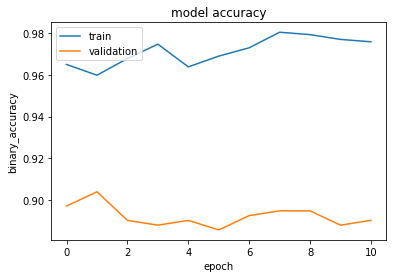

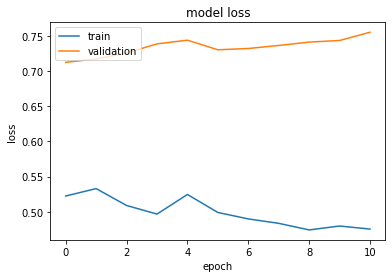

Best epoch: 2
Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 0.5056 - binary_accuracy: 0.9739
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 0.8280 - binary_accuracy: 0.8607
Test loss: 0.8280229568481445
Test accuracy: 0.8607142567634583
[0.87743733 0.83084577]

0.8541415485247855

Confusion matrix:
[[315  44]
 [ 34 167]]

Normalized confusion matrix:
[[0.87743733 0.12256267]
 [0.16915423 0.83084577]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.90      0.88      0.89       359
     label 1       0.79      0.83      0.81       201

    accuracy                           0.86       560
   macro avg       0.85      0.85      0.85       560
weighted avg       0.86      0.86      0.86       560

AUC-ROC: 0.8541415485247855
MCC: 0.7011294177807355
precision: 0.8470239954372003
recall: 0.8541415485247855
f1_score: 0.8502550600625308
Model: "sequential_16"
______________________

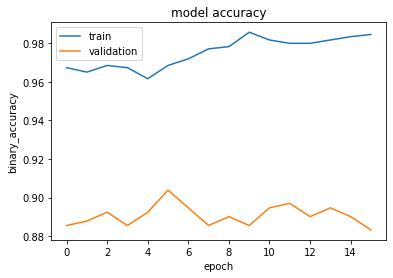

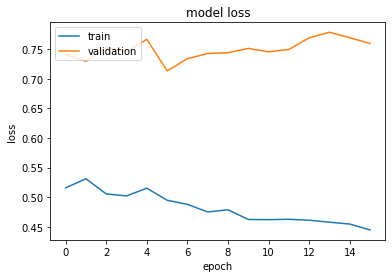

Best epoch: 6
Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 0.4852 - binary_accuracy: 0.9803
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 0.8857 - binary_accuracy: 0.8625
Test loss: 0.8857010006904602
Test accuracy: 0.862500011920929
[0.8718663  0.84577114]

0.8588187197716155

Confusion matrix:
[[313  46]
 [ 31 170]]

Normalized confusion matrix:
[[0.8718663  0.1281337 ]
 [0.15422886 0.84577114]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.91      0.87      0.89       359
     label 1       0.79      0.85      0.82       201

    accuracy                           0.86       560
   macro avg       0.85      0.86      0.85       560
weighted avg       0.87      0.86      0.86       560

AUC-ROC: 0.8588187197716154
MCC: 0.707203243991541
precision: 0.8484603789836348
recall: 0.8588187197716155
f1_score: 0.852908569303874
Model: "sequential_17"
_________________________

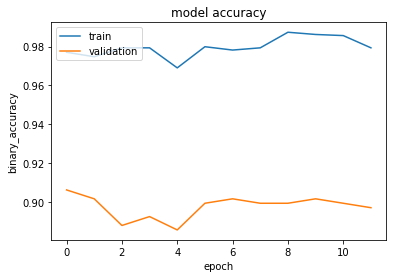

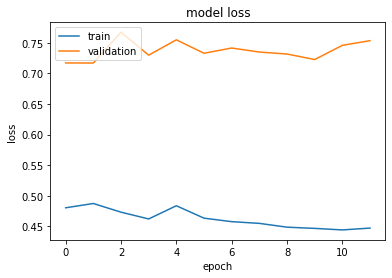

Best epoch: 1
Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 0.4829 - binary_accuracy: 0.9780
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 0.9114 - binary_accuracy: 0.8625
Test loss: 0.911441445350647
Test accuracy: 0.862500011920929
[0.87465181 0.84079602]

0.8577239152427278

Confusion matrix:
[[314  45]
 [ 32 169]]

Normalized confusion matrix:
[[0.87465181 0.12534819]
 [0.15920398 0.84079602]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.91      0.87      0.89       359
     label 1       0.79      0.84      0.81       201

    accuracy                           0.86       560
   macro avg       0.85      0.86      0.85       560
weighted avg       0.87      0.86      0.86       560

AUC-ROC: 0.8577239152427277
MCC: 0.7062822436925748
precision: 0.8486170385176381
recall: 0.8577239152427278
f1_score: 0.8526189865846364
Model: "sequential_18"
________________________

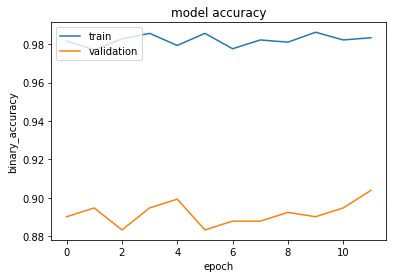

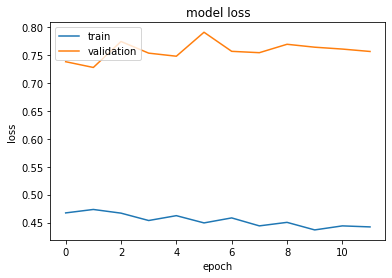

Best epoch: 12
Train Accuracy: 
69/69 [==============================] - 0s 2ms/step - loss: 0.4786 - binary_accuracy: 0.9775
Test Accuracy: 
18/18 [==============================] - 0s 2ms/step - loss: 0.8811 - binary_accuracy: 0.8643
Test loss: 0.8810730576515198
Test accuracy: 0.8642857074737549
[0.87743733 0.84079602]

0.859116672902895

Confusion matrix:
[[315  44]
 [ 32 169]]

Normalized confusion matrix:
[[0.87743733 0.12256267]
 [0.15920398 0.84079602]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.91      0.88      0.89       359
     label 1       0.79      0.84      0.82       201

    accuracy                           0.86       560
   macro avg       0.85      0.86      0.85       560
weighted avg       0.87      0.86      0.87       560

AUC-ROC: 0.8591166729028948
MCC: 0.7096697250723879
precision: 0.8506041049370189
recall: 0.859116672902895
f1_score: 0.8543881977802412
Model: "sequential_19"
_______________________

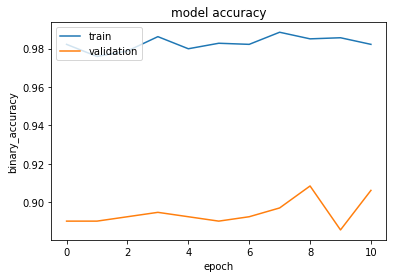

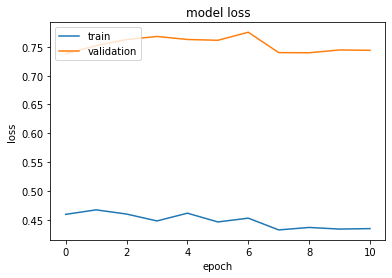

Best epoch: 9
Train Accuracy: 
69/69 [==============================] - 0s 3ms/step - loss: 0.4772 - binary_accuracy: 0.9775
Test Accuracy: 
18/18 [==============================] - 0s 3ms/step - loss: 0.8901 - binary_accuracy: 0.8643
Test loss: 0.8900656700134277
Test accuracy: 0.8642857074737549
[0.87465181 0.84577114]

0.8602114774317826

Confusion matrix:
[[314  45]
 [ 31 170]]

Normalized confusion matrix:
[[0.87465181 0.12534819]
 [0.15422886 0.84577114]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.91      0.87      0.89       359
     label 1       0.79      0.85      0.82       201

    accuracy                           0.86       560
   macro avg       0.85      0.86      0.85       560
weighted avg       0.87      0.86      0.87       560

AUC-ROC: 0.8602114774317826
MCC: 0.7105653370342326
precision: 0.8504213009774182
recall: 0.8602114774317826
f1_score: 0.8546765734265734


In [76]:
for i in range(0, 10):
    # train - validation split:
    X_train1, X_val1, y_train1, y_val1  = train_test_split(scaled_vectors_train, y_train , test_size=0.25, random_state=0)
    m = 'hypermodel_laser_u2v'
    i += 1
    model66 = build_model(1792)
    model_fit(hypermodel, X_train1, y_train1 , X_val1, y_val1)
    results(hypermodel, X_train1, y_train1, scaled_vectors_test, y_test1)

In [77]:
# loss, accuracy = tuned_model.evaluate(scaled_vectors_test, y_test1, verbose =1)
# # Print the evaluation results
# print('Test loss:', loss)
# print('Test accuracy:', accuracy)



In [78]:
# def prediction(model):
#     predictions = model.predict(X_test1)
#     for i in range(len(predictions)):
#         if (predictions[i] < 0.5):
#             predictions[i] = 0
#         else: 
#             predictions[i] = 1
#     return predictions

# def confusion(predictions):
#     cm = confusion_matrix(y_test1, predictions)
#     accuracies = cm.diagonal()/cm.sum(axis=1)
#     print('accuracies per class: ',accuracies)
#     print()

#     # Calculate the average accuracy across all classes
#     avg_accuracy = accuracies.mean()
#     # Print the average accuracy
#     print("the average accuracy: ", avg_accuracy)
#     print()
    
#     # Print confusion matrix
#     classes = np.unique(y_test1)
#     print("Confusion matrix:")
#     print(cm)
#     print()

#     # Print normalized confusion matrix
#     cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print("Normalized confusion matrix:")
#     print(cm_norm)
#     print()

#     # Print classification report
#     from sklearn.metrics import classification_report
#     print("Classification report:")
#     print(classification_report(y_test1, predictions, target_names=[f"label {c}" for c in classes]))

# print('!!! Tunned Moldel results !!!')
# print()
# confusion(prediction(tuned_model))
# print('!!! Hypermodel resuls !!!')
# print()
# confusion(prediction(hypermodel))

tuned model on concat vect:
best parameters that have been found: 
* Best Hyperparameters:
*  units_1 : 288
*  act_1 : sigmoid
*  dropout_1 : 0.30000000000000004
*  units_2 : 32
*  act_2 : sigmoid
*  dropout_2 : 0.4
*  units_3 : 96
*  act_3 : sigmoid
*  dropout_3 : 0.30000000000000004
*  units_4 : 32
*  act_4 : relu
*  dropout_4 : 0.4
* Learning rate: 0.0001

LR

In [79]:
# Compute confusion matrix
def confusion(predictions):
    cm = confusion_matrix(y_test1, predictions)
    accuracies = cm.diagonal()/cm.sum(axis=1)
    print(accuracies)
    print()

    # Calculate the average accuracy across all classes
    avg_accuracy = accuracies.mean()
    # Print the average accuracy
    print(avg_accuracy)
    print()
    
    # Print confusion matrix
    classes = np.unique(y_test1)
    print("Confusion matrix:")
    print(cm)
    print()

    # Print normalized confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix:")
    print(cm_norm)
    print()

    print("Classification report:")
    print(classification_report(y_test1, predictions, target_names=[f"label {c}" for c in classes]))
    
    auc_roc = roc_auc_score(y_test1, predictions) # y_pred_prob is the predicted probability of class 1
    mcc = matthews_corrcoef(y_test1, predictions)
    print("AUC-ROC:", auc_roc)
    print("MCC:", mcc)
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test1, predictions, average='macro')
    accuracy = accuracy_score(y_test1, predictions) 
    loss = log_loss(y_test1, predictions)  
    
    print("precision:", precision)
    print("recall:", recall)
    print("f1_score:", f1_score)
    print('Test loss:', loss)
    print('Test accuracy:', accuracy)

                              
    accuracy_list.append(accuracy)
    loss_list.append(loss)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_score_list.append(f1_score)
    auc_roc_list.append(auc_roc)
    mcc_list.append(mcc)
    model_name.append(m)
    
def results(model, x, y, x_t, y_t):    
    # Print the evaluation results

    prediction = model.predict(x_t)
    for i in range(len(prediction)):
        if (prediction[i] < 0.5):
            prediction[i] = 0
        else: 
            prediction[i] = 1
    confusion(prediction)

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

def LR_model():       
    global m
    time_callback = TrainingTimeCallback()
    #stic regression classifier on the embeddings
    LR = LogisticRegression()
    m = 'LR_laser_u2v'
    time_callback.on_train_begin()
    LR.fit(scaled_vectors_train , y_train)
    time_callback.on_train_end()
    filename = f"LR_{m}.h5"
    results(LR, scaled_vectors_train , y_train , scaled_vectors_test, y_test1)
LR_model()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Training time: 0.6540875434875488 seconds
[0.85236769 0.82089552]

0.8366316052051719

Confusion matrix:
[[306  53]
 [ 36 165]]

Normalized confusion matrix:
[[0.85236769 0.14763231]
 [0.17910448 0.82089552]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.89      0.85      0.87       359
     label 1       0.76      0.82      0.79       201

    accuracy                           0.84       560
   macro avg       0.83      0.84      0.83       560
weighted avg       0.85      0.84      0.84       560

AUC-ROC: 0.8366316052051719
MCC: 0.6623519768305788
precision: 0.8258087880251086
recall: 0.8366316052051719
f1_score: 0.830314007605909
Test loss: 5.4892740675193785
Test accuracy: 0.8410714285714286


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



> k - fold cross validation

In [81]:
# X_test1

In [82]:
#     # train - validation split:
#     X_test = result_test
#     X_train = result_train  
#     X_train1 = X_train['full_text_clean']
#     y_train1 = X_train['label']
#     X_train1 =laser_encode(X_train1)
#     y_train1 = lb.fit_transform(y_train1)

#     # drop a column
#     X_train = X_train.drop(['author_id', 'full_text_clean', 'label'], axis=1)
#     X_test = X_test.drop(['author_id', 'full_text_clean', 'label'], axis=1)

#     # print the resulting DataFrame
# #     print(X_train)
# #     print(X_val)
# #     print(X_test)

#     word_embeddings_train = X_train.to_numpy()
#     word_embeddings_test = X_test.to_numpy()

#     X_train1 = X_train1.astype(np.float64)
#     X_test1 = X_test1.astype(np.float64)

#     # concatenate the arrays along the second axis
#     c_train = np.concatenate((X_train1, word_embeddings_train), axis=1)
#     # concatenate the arrays along the second axis
#     c_test = np.concatenate((X_test1, word_embeddings_test), axis=1)
#     # print the shape of the concatenated array
    
#     scaled_vectors_train = scaler.fit_transform(c_train)
#     scaled_vectors_test = scaler.transform(c_test)

In [83]:
# k = 1
# metrics = ['binary_accuracy']
# metrics_t = []
# callback = tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)
# # Initialize the k-fold cross-validation object
# kf = KFold(n_splits=k, shuffle=True, random_state=42)
# data = 
# # # Iterate over each fold
# for fold, (train_index, val_index) in enumerate(kf.split(data['full_text_clean'])):
    
#     # Split the data and embeddings into training and validation sets
#     X_train, y_train = data['full_text_clean'][train_index], data['label'][train_index]
#     X_val, y_val = data['full_text_clean'][val_index], data['label'][val_index]

#         # train_test split: test 30%
#     # X_train, X_test, y_train, y_test = train_test_split(data['full_text_clean'], data['label'], test_size=0.3, random_state=0)
#     X_train, X_val  = train_test_split(result_train , test_size=0.25, random_state=0)
#     X_test1 = result_test['full_text_clean']
#     y_test1 = result_test['label']

#     X_train1 = X_train['full_text_clean']
#     y_train1 = X_train['label']
#     X_val1 = X_val['full_text_clean']
#     y_val1 = X_val['label']

#     X_train =laser_encode(X_train)
#     X_val = laser_encode(X_val)
#     y_train = lb.fit_transform(y_train)
#     y_val = lb.transform(y_val)
    
#       #Tuner
#     tuner = RandomSearch(
#         build_model,
#         objective = 'val_binary_accuracy',
#         max_trials = 15,
#         executions_per_trial = 25,
#         #overwrite=True,
#     )
#     # not necessary to see it every time
#     #tuner.search_space_summary()

#     tuner.search(X_train, y_train, 
#                     epochs=epochs, 
#                     batch_size=batch_size, 
#                     validation_split=0.2, 
#                     verbose=0,#not necessary to see all trainings
#                     validation_data=([X_val, y_val]),
#                     callbacks=[callback]
#                 )
# #     tuner.results_summary()
    
#     # Get the optimal hyperparameters
#     best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
#     print()
#     print('best parameters that have been found: ')
#     show_best_hps()

#     print()
#     # Build the model with the optimal hyperparameters and train it on the data for 50 epochs
#     tuned_model = tuner.hypermodel.build(best_hps)
#     #sow only the model with best params
# #     print(tuned_model.summary())    
    
#      # go fit it
#     history = tuned_model.fit(X_train, y_train, 
#                         epochs=epochs, 
#                         batch_size=batch_size, 
#                         validation_split=0.2, 
#                         verbose=0,# to see the training, put verbose=1
#                         validation_data=([X_val, y_val]),
#                         callbacks=[callback]
#                        )
# #     print("Tuned model history: ")
# #     plot_history(history)
        
#     # Evaluate the model on the held-out fold
#     print('Evaluate the model on X_val on the held-out fold: ')
#     scores = tuned_model.evaluate(X_val, y_val, verbose=0)
#     print(f"Fold {fold+1} - {metrics[0]}: {scores[1]*100:.2f}%")
            
#     # every fold's evaluation on tuned model
#     print("Evaluate on X_test: ")
#     print(tuned_model.evaluate(X_test, y_test))
#     metrics_t.append(tuned_model.evaluate(X_test, y_test))
#     #plot_history(history)?

In [84]:

# metrics_t = np.array(metrics_t)
# metrics_t[:,1]
# mean = np.average(metrics_t[:,1])
# std = np.std(metrics_t[:,1])
# print(mean, std)
# tuned_model.save('models/tuned_model.h5')
#     # Evaluate the model on the held-out fold
#     scores = tuned_model.evaluate(X_val, y_val, verbose=0)
#     print(f"Fold {fold+1} - {metrics[0]}: {scores[1]*100:.2f}%")
    

In [85]:
len(training_time)

97

In [86]:
data = {
    "Model": model_name,
    "Accuracy": accuracy_list,
    "Loss": loss_list,
    "Precision": precision_list,
    "Recall": recall_list,
    "F1 Score": f1_score_list,
    "AUC-ROC": auc_roc_list,
    "MCC": mcc_list,
    "Training time":training_time

}

df = pd.DataFrame(data)
print(df)


                    Model  Accuracy      Loss  Precision    Recall  F1 Score  \
0   laser_em_batchnorm_l2  0.848214  2.574097   0.833632  0.841108  0.836981   
1   laser_em_batchnorm_l2  0.855357  3.136978   0.840774  0.855437  0.846433   
2   laser_em_batchnorm_l2  0.835714  2.564697   0.821961  0.842307  0.827807   
3   laser_em_batchnorm_l2  0.846429  3.000840   0.831425  0.842999  0.836190   
4   laser_em_batchnorm_l2  0.825000  2.929216   0.812717  0.835045  0.817708   
..                    ...       ...       ...        ...       ...       ...   
92   hypermodel_laser_u2v  0.862500  0.885701   0.848460  0.858819  0.852909   
93   hypermodel_laser_u2v  0.862500  0.911441   0.848617  0.857724  0.852619   
94   hypermodel_laser_u2v  0.864286  0.881073   0.850604  0.859117  0.854388   
95   hypermodel_laser_u2v  0.864286  0.890066   0.850421  0.860211  0.854677   
96           LR_laser_u2v  0.841071  5.489274   0.825809  0.836632  0.830314   

     AUC-ROC       MCC  Training time  

In [87]:
grouped_results = df.reset_index().groupby('Model').mean().sort_values('index')
grouped_results = grouped_results.drop('index', axis=1)

grouped_results.reset_index(level=0, inplace=True)
grouped_results

Model  Accuracy      Loss  \
0                          laser_em_batchnorm_l2  0.845893  2.889331   
1                                    laser_em_l2  0.757321  0.724428   
2                       laser_em_batchnorm_l1_l2  0.831429  5.689030   
3                          laser_em_batchnorm_l1  0.834107  5.874546   
4                      laser_em_batchnorm_l2_u2v  0.847500  2.815013   
5               laser_em_batchnorm_l2_u2v_scaled  0.856429  2.711299   
6    laser_em_batchnorm_l2_u2v_scaled_each_embed  0.858214  2.924645   
7    laser_em_batchnorm_l2_u2v_scaled_drop100dim  0.871429  3.036915   
8    laser_em_batchnorm_l2_u2v_scaled_drop200dim  0.844643  3.010041   
9   laser_em_batchnorm_l2_u2v_scaled_drop1000dim  0.850000  3.546576   
10                            tunned_model_laser  0.860714  0.798327   
11                              hypermodel_laser  0.839286  0.825826   
12                        tunned_model_laser_u2v  0.865357  0.807274   
13                          hypermodel_laser_u2v  0.860893  0.851331   
14                                  LR_laser_u2v  0.841071  5.489274   

    Precision    Recall  F1 Score   AUC-ROC       MCC  Training time  
0    0.831879  0.842363  0.835531  0.842363  0.674119      82.779909  
1    0.669014  0.697850  0.661885  0.697850  0.415306      53.119084  
2    0.817182  0.827250  0.820092  0.827250  0.644265      87.271933  
3    0.819411  0.831857  0.823619  0.831857  0.651112      83.489194  
4    0.834211  0.835296  0.834623  0.835296  0.669493      84.669432  
5    0.844034  0.845872  0.844522  0.845872  0.689863      84.485583  
6    0.844396  0.851754  0.847653  0.851754  0.696105      84.611090  
7    0.857971  0.867972  0.862325  0.867972  0.725874      84.686997  
8    0.831097  0.833396  0.831876  0.833396  0.664454      83.385271  
9    0.835172  0.849069  0.840599  0.849069  0.684100      80.512728  
10   0.846646  0.856331  0.850852  0.856331  0.702911      10.030843  
11   0.824086  0.831954  0.827565  0.831954  0.655993       9.782851  
12   0.852152  0.858529  0.855070  0.858529  0.710651       3.711068  
13   0.847154  0.854828  0.850577  0.854828  0.701938       3.953938  
14   0.825809  0.836632  0.830314  0.836632  0.662352       0.654088

In [88]:
import plotly.graph_objs as go

# Count occurrences by model
counts = grouped_results['Accuracy']
model_names = grouped_results['Model']

# Create a bar chart using plotly
fig = go.Figure(data=[go.Bar(x=model_names, y=counts,
                             marker_color='#008B8B',  # set the color of the bars
                             text=[f'{model}: {accuracy:.0%}' for model, accuracy in zip(model_names, counts)],  # add model name and accuracy values as percentage to the bars
                             textposition='auto')])  # position the labels inside the bars

# Customize the layout
fig.update_layout(title='Accuracy by Model',
                  xaxis_title='Models',
                  yaxis_title='Accuracy',
                  font=dict(size=16),
                  margin=dict(l=50, r=50, t=50, b=50),
                  plot_bgcolor='#F8F8FF',
                  paper_bgcolor='#F8F8FF',
                  width=1000,  # Update width
                  height=600)
# Adjust the width of the bars
fig.update_traces(marker=dict(line=dict(width=0.5)))  # decrease the width of the bars

# Remove model names from the x-axis
fig.update_xaxes(tickvals=[])

# Show the plot
fig.show()


In [89]:
# result_train = result_train.astype(str)
# print(result_train.head())

# result_test = result_test.astype(str)
# print(result_test.head())

# result_train.to_excel('result_train.xlsx', index=False, encoding='utf-8-sig')
# result_test.to_excel('result_test.xlsx', index=False, encoding='utf-8-sig')

In [90]:
df.to_excel('models_results.xlsx', index=False, encoding='utf-8-sig')
grouped_results.to_excel('grouped_results.xlsx', index=False, encoding='utf-8-sig')
